In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/rate/bi.pickle
147


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t0_ = dur - 20.
t_pen = t0_/dur

In [5]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 
convergence_ = [None] * len(exc) 

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)
w_ = [None] * len(exc)
conv = [None] * len(exc)
conv_shift = [None] * len(exc)

In [6]:
file_ = '3.pickle'
folder = str(os.getcwd().split('data')[1])
print(folder)
case = str(folder[1])

/3


In [7]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-12
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [3,4]

    
p_var = [0]

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
    cost_index = 2
else:
    factor_ws = 0.
    factor_we = 1.
    cost_index = 1
    
maxC = [5., -5., 0.3, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [8]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]    

file found


In [9]:
# get initial parameters and target states
i_range = np.arange(0, 73, 6)
#i_range = [1,2,3,4,5]
i_range = [1, 2, 3, 5, 9, 10, 13, 14, 19, 25, 55, 62, 69, 76]
print(i_range)

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

[1, 2, 3, 5, 9, 10, 13, 14, 19, 25, 55, 62, 69, 76]
-------  1 0.4250000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  10 0.4250000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  55 0.4250000000000001 0.6250000000000003
-------  62 0.4250000000000001 0.6500000000000004
-------  69 0.4250000000000001 0.6750000000000004
-------  76 0.4250000000000001 0.7000000000000004


In [10]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  244234.70502182204
RUN  0 , total integrated cost =  244234.70502182204
Gradient descend method:  None
RUN  0 , total integrated cost =  244234.70502182204
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  0 , total integrated cost =  137806.3558139294
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  241480.3484875782
RUN  0 , total integrated cost =  241480.3484875782
Gradient descend method:  None
RUN  0 , total integrated cost =  241480.3484875782
Improved ov

In [132]:
bad = []

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  244234.70502182204
RUN  0 , total integrated cost =  244234.70502182204
Gradient descend method:  None
RUN  1 , total integrated cost =  3150.904206930121
RUN  2 , total integrated cost =  3081.1323811765515
RUN  3 , total integrated cost =  3013.7487991634484
RUN  4 , total integrated cost =  2552.3820951680436
RUN  5 , total integrated cost =  2547.3463217178596
RUN  6 , total integrated cost =  2541.124253433411
RUN  7 , total integrated cost =  2536.5055156586095
RUN  8 , total integrated cost =  2530.5485373660767
RUN  9 , total integrated cost =  2525.679341402481
RUN  10 , total integrated cost =  2518.8804829224637
RUN  10 , total integrated cost =  2518.8804829224637
Improved over  10  iterations in  6.697609240072779  seconds by  98.96866398135457  percent.
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost = 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  22791.92753754145
RUN  20 , total integrated cost =  22791.92753754145
Improved over  20  iterations in  15.454929848900065  seconds by  90.66802257463573  percent.
Problem in initial value trasfer post:  sigmae_f 1.556825345132011 1.5602171313720112
Problem in initial value trasfer post:  tau_exc 18.908482320896447 18.873847685171206
weight =  9900.0


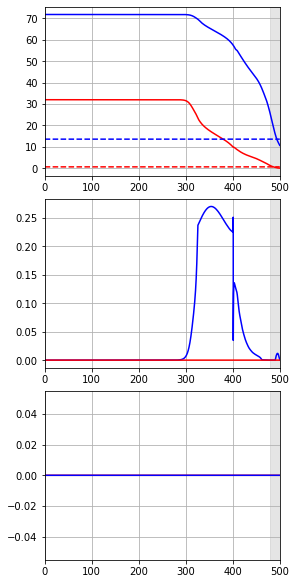

uncontrolled cost :  244234.70502182204
cost splitting :  34.049071324858055 [0.        2.2987756 0.        0.       ]
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  1 , total integrated cost =  1914.415059570241
RUN  2 , total integrated cost =  1276.4552815656548
RUN  3 , total integrated cost =  548.1297425919686
RUN  4 , total integrated cost =  532.1862174426714
RUN  5 , total integrated cost =  523.100051191758
RUN  6 , total integrated cost =  509.6303662123308
RUN  7 , total integrated cost =  501.9213607334367
RUN  8 , total integrated cost =  490.7624876982562
RUN  9 , total integrated cost =  483.80954310023856


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  472.8773478399994
RUN  10 , total integrated cost =  472.8773478399994
Improved over  10  iterations in  7.309297672007233  seconds by  99.65685374593426  percent.
Problem in initial value trasfer post:  sigmae_f 1.5277300865711465 1.527754680493515
Problem in initial value trasfer post:  tau_exc 21.231131790912393 21.230988967251154
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  137806.3558139294
RUN  0 , total integrated cost =  137806.3558139294
Gradient descend method:  None
RUN  1 , total integrated cost =  16004.796445678727
RUN  2 , total integrated cost =  12816.65404520483
RUN  3 , total integrated cost =  6182.933140483769
RUN  4 , total integrated cost =  5718.451595656564
RUN  5 , total integrated cost =  4256.497272536623
RUN  6 , total integrated cost =  3970.0953565979007
RUN  7 , total integrated cost =  3825.1194189138205
RUN  8 , total integrated cost =  3784.4981027725726
RUN  9 , total integr

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  4037.88530891297
RUN  20 , total integrated cost =  4037.88530891297
Improved over  20  iterations in  12.068992259097286  seconds by  97.06988456006698  percent.
Problem in initial value trasfer post:  sigmae_f 1.549826702989431 1.5498351666396826
Problem in initial value trasfer post:  tau_exc 20.70158134878916 20.701523684652702
weight =  9900.0


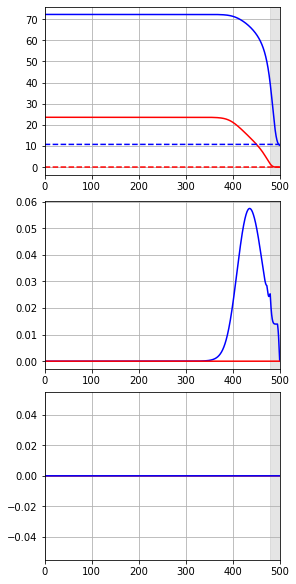

uncontrolled cost :  137806.3558139294
cost splitting :  43.91794740109233 [0.         0.40343105 0.         0.        ]
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  241480.3484875782
RUN  0 , total integrated cost =  241480.3484875782
Gradient descend method:  None
RUN  1 , total integrated cost =  3083.188444557762
RUN  2 , total integrated cost =  2594.5744006782256
RUN  3 , total integrated cost =  2537.429364981927
RUN  4 , total integrated cost =  2537.2457073865216
RUN  5 , total integrated cost =  2398.7073044151293
RUN  6 , total integrated cost =  2227.1212140469615
RUN  7 , total integrated cost =  2215.442773480404
RUN  8 , total integrated cost =  2215.190480851248
RUN  9 , total integrated cost =  2210.261857181446
RUN  10 , total integrated cost =  2197.224959407014
RUN  10 , total integrated cost =  2197.224959407014
Improved over  10  iterations in  6.207756217918359  seconds by 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  22989.214892686385
RUN  20 , total integrated cost =  22989.214892686385
Improved over  20  iterations in  15.4660440729931  seconds by  90.4798816811924  percent.
Problem in initial value trasfer post:  sigmae_f 1.5212871669893586 1.5278376278978387
Problem in initial value trasfer post:  tau_exc 20.076784635757885 20.018915468330064
weight =  9900.0


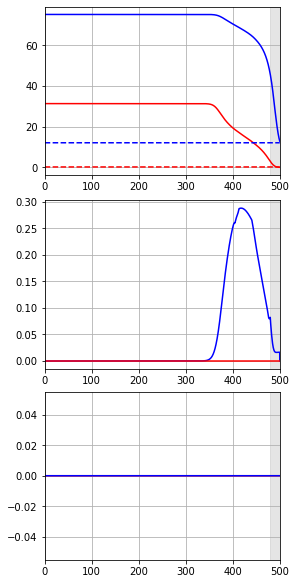

uncontrolled cost :  241480.3484875782
cost splitting :  271.37591585774726 [0.         2.29473121 0.         0.        ]
-------  5 0.4000000000000001 0.40000000000000013
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  1824.5826866486402
RUN  2 , total integrated cost =  1279.5111160526912
RUN  3 , total integrated cost =  487.4153593495827
RUN  4 , total integrated cost =  469.1431750114386
RUN  5 , total integrated cost =  459.6484201930218
RUN  6 , total integrated cost =  445.12419646665126
RUN  7 , total integrated cost =  437.64257000624144
RUN  8 , total integrated cost =  426.67405174709324
RUN  9 , total integrated cost =  421.24929667744937


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  413.7314238254111
RUN  10 , total integrated cost =  413.7314238254111
Improved over  10  iterations in  7.953777017071843  seconds by  99.67377414149995  percent.
Problem in initial value trasfer post:  sigmae_f 1.5294442447064278 1.5294581787099293
Problem in initial value trasfer post:  tau_exc 21.3187710847942 21.31869407809549
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  14446.893559509841
RUN  2 , total integrated cost =  12177.743645738108
RUN  3 , total integrated cost =  8603.83698747732
RUN  4 , total integrated cost =  7690.037679836864
RUN  5 , total integrated cost =  6283.3758122751815
RUN  6 , total integrated cost =  5731.892933107853
RUN  7 , total integrated cost =  3265.010003407077
RUN  8 , total integrated cost =  3196.8349125996206
RUN  9 , total integra

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  3083.2531736511114
RUN  10 , total integrated cost =  3083.2531736511114
Improved over  10  iterations in  7.194025251897983  seconds by  97.56886507617126  percent.
Problem in initial value trasfer post:  sigmae_f 1.5627309148554689 1.5627310330597812
Problem in initial value trasfer post:  tau_exc 20.272038979327846 20.272038067823942
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  15619.777742259805
RUN  2 , total integrated cost =  12539.95492597625
RUN  3 , total integrated cost =  8171.727404014322
RUN  4 , total integrated cost =  7112.512935794803
RUN  5 , total integrated cost =  3622.904277462451
RUN  6 , total integrated cost =  3577.9960803091503
RUN  7 , total integrated cost =  3558.279753034327
RUN  8 , total integrated cost =  3510.6522558534066
RUN  9 , total in

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  3189.4927319917806
RUN  20 , total integrated cost =  3189.4927319917806
Improved over  20  iterations in  13.95454147295095  seconds by  97.4850955360046  percent.
Problem in initial value trasfer post:  sigmae_f 1.560645249408677 1.560645574186442
Problem in initial value trasfer post:  tau_exc 20.262598614013648 20.262596093777105
weight =  9900.0


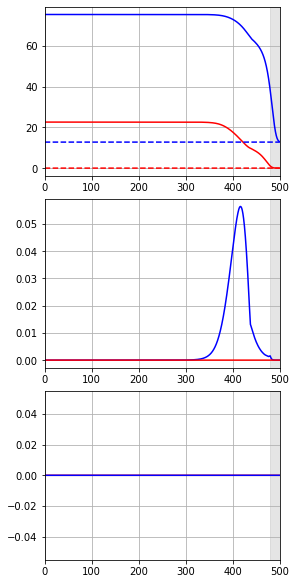

uncontrolled cost :  126823.61408372025
cost splitting :  24.341639387254247 [0.         0.31971223 0.         0.        ]
-------  9 0.4000000000000001 0.42500000000000016
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None
RUN  1 , total integrated cost =  1612.213558418841
RUN  2 , total integrated cost =  1491.4697014731298
RUN  3 , total integrated cost =  787.2342967191012
RUN  4 , total integrated cost =  753.3604672482178
RUN  5 , total integrated cost =  621.9697624012435
RUN  6 , total integrated cost =  601.6915971386278
RUN  7 , total integrated cost =  556.8720547874689
RUN  8 , total integrated cost =  539.6276173830947
RUN  9 , total integrated cost =  507.75268409926866


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  493.3252281134537
RUN  10 , total integrated cost =  493.3252281134537
Improved over  10  iterations in  7.143786025932059  seconds by  99.57288819474871  percent.
Problem in initial value trasfer post:  sigmae_f 1.5213614442889387 1.5213733629985682
Problem in initial value trasfer post:  tau_exc 21.59103121209367 21.590976780616884
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None
RUN  1 , total integrated cost =  11044.02052571364
RUN  2 , total integrated cost =  8806.724830376894
RUN  3 , total integrated cost =  2785.050382081208
RUN  4 , total integrated cost =  2686.2835198906973
RUN  5 , total integrated cost =  2308.704217047079
RUN  6 , total integrated cost =  2305.5685846577653
RUN  7 , total integrated cost =  2303.3426150095447
RUN  8 , total integrated cost =  2300.5436345464846
RUN  9 , total integr

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2295.724711265573
RUN  10 , total integrated cost =  2295.724711265573
Improved over  10  iterations in  7.387871026992798  seconds by  98.0124042519814  percent.
Problem in initial value trasfer post:  sigmae_f 1.5445390224382978 1.544539118408291
Problem in initial value trasfer post:  tau_exc 20.68322904952415 20.68322838140609
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None
RUN  1 , total integrated cost =  11903.03386133404
RUN  2 , total integrated cost =  9638.592814508205
RUN  3 , total integrated cost =  3079.108063995541
RUN  4 , total integrated cost =  2958.759937085031
RUN  5 , total integrated cost =  2887.4041914783725
RUN  6 , total integrated cost =  2849.818193346671
RUN  7 , total integrated cost =  2783.3171849580854
RUN  8 , total integrated cost =  2745.2913324191977
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  2548.1612997008688
RUN  20 , total integrated cost =  2548.1612997008688
Improved over  20  iterations in  13.835228465031832  seconds by  97.7938493497511  percent.
Problem in initial value trasfer post:  sigmae_f 1.5474453662883032 1.5474455081187781
Problem in initial value trasfer post:  tau_exc 20.752819649094505 20.752818696127775
weight =  9900.0


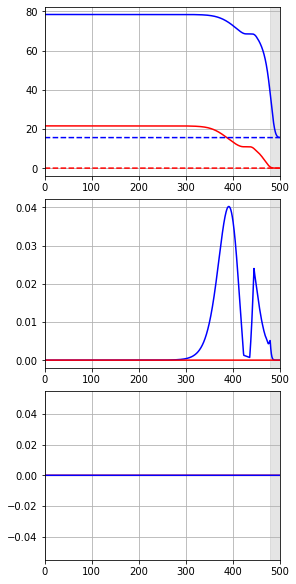

uncontrolled cost :  115502.5972235114
cost splitting :  5.26413870314667 [0.        0.2568583 0.        0.       ]
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  3040.7237851217897
RUN  2 , total integrated cost =  2892.6130899449054
RUN  3 , total integrated cost =  2823.831699129437
RUN  4 , total integrated cost =  2760.1754638579127
RUN  5 , total integrated cost =  2721.595474786291
RUN  6 , total integrated cost =  2679.1939652819888
RUN  7 , total integrated cost =  2652.836799863241
RUN  8 , total integrated cost =  2620.435817553883
RUN  9 , total integrated cost =  2599.825320972345


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2573.2530278617887
RUN  10 , total integrated cost =  2573.2530278617887
Improved over  10  iterations in  6.6878859689459205  seconds by  98.86490061151282  percent.
Problem in initial value trasfer post:  sigmae_f 1.5002188135086165 1.5009436808621366
Problem in initial value trasfer post:  tau_exc 21.56953970509162 21.56583476551267
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  26752.264552321263
RUN  2 , total integrated cost =  22552.3476333138
RUN  3 , total integrated cost =  22398.418063890338
RUN  4 , total integrated cost =  22368.771065613528
RUN  5 , total integrated cost =  22361.230941638685
RUN  6 , total integrated cost =  22344.020459734405
RUN  7 , total integrated cost =  22336.868378114104
RUN  8 , total integrated cost =  22304.65086106701
RUN  9 , total i

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  22276.220580665293
RUN  10 , total integrated cost =  22276.220580665293
Improved over  10  iterations in  7.4158948679687455  seconds by  90.17363466198675  percent.
Problem in initial value trasfer post:  sigmae_f 1.5460641310038037 1.5460641639287762
Problem in initial value trasfer post:  tau_exc 20.308989583706 20.30898932390538
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  29387.205452390153
RUN  2 , total integrated cost =  24810.82640253753
RUN  3 , total integrated cost =  24636.39990319887
RUN  4 , total integrated cost =  24369.798832191565
RUN  5 , total integrated cost =  24352.118186097217
RUN  6 , total integrated cost =  24161.54302753216
RUN  7 , total integrated cost =  24135.026643240253
RUN  8 , total integrated cost =  23875.754024875376
RUN  9 , total int

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  22614.931365953686
RUN  20 , total integrated cost =  22614.931365953686
Improved over  20  iterations in  12.072547755902633  seconds by  90.02422440147524  percent.
Problem in initial value trasfer post:  sigmae_f 1.544939246485559 1.544939789787483
Problem in initial value trasfer post:  tau_exc 20.28777700076001 20.287772681632873
weight =  9900.0


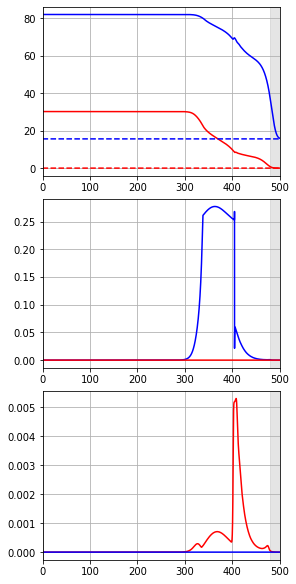

uncontrolled cost :  226698.47715197233
cost splitting :  14.844044215036401 [0.         2.26343183 0.01940528 0.        ]
-------  13 0.4000000000000001 0.4500000000000002
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  103932.40255255786
RUN  0 , total integrated cost =  103932.40255255786
Gradient descend method:  None
RUN  1 , total integrated cost =  1100.6145939702196
RUN  2 , total integrated cost =  1013.0152829366449
RUN  3 , total integrated cost =  818.6395066710921
RUN  4 , total integrated cost =  753.2080715710782
RUN  5 , total integrated cost =  603.4930213775096
RUN  6 , total integrated cost =  559.5103303343129
RUN  7 , total integrated cost =  474.7595272917678
RUN  8 , total integrated cost =  444.3299900694906
RUN  9 , total integrated cost =  385.789531779912


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  363.9614843918044
RUN  10 , total integrated cost =  363.9614843918044
Improved over  10  iterations in  5.271339572966099  seconds by  99.64980941895598  percent.
Problem in initial value trasfer post:  sigmae_f 1.521592276709709 1.5215986972990916
Problem in initial value trasfer post:  tau_exc 21.53286950228577 21.532838522419613
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  103932.40255255786
RUN  0 , total integrated cost =  103932.40255255786
Gradient descend method:  None
RUN  1 , total integrated cost =  7737.417922187702
RUN  2 , total integrated cost =  6834.3721423816905
RUN  3 , total integrated cost =  5376.963631155158
RUN  4 , total integrated cost =  4929.780190831761
RUN  5 , total integrated cost =  4224.828388281475
RUN  6 , total integrated cost =  3928.2520720284974
RUN  7 , total integrated cost =  3458.2486480145812
RUN  8 , total integrated cost =  3253.862765197022
RUN  9 , total integr

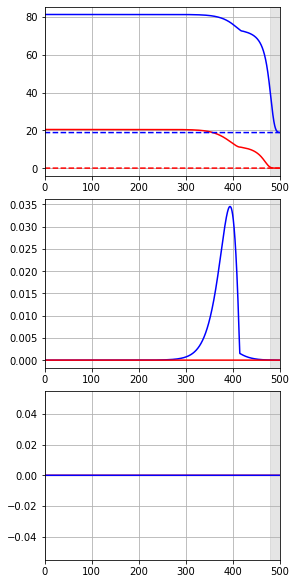

uncontrolled cost :  103932.40255255786
cost splitting :  3.3176458031754437 [0.         0.19894846 0.         0.        ]
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  218854.09939826332
RUN  0 , total integrated cost =  218854.09939826332
Gradient descend method:  None
RUN  1 , total integrated cost =  3017.523107037317
RUN  2 , total integrated cost =  2898.2339681855506
RUN  3 , total integrated cost =  2859.227964775434
RUN  4 , total integrated cost =  2304.9326403498367
RUN  5 , total integrated cost =  2286.031545037788
RUN  6 , total integrated cost =  2262.4918678625672
RUN  7 , total integrated cost =  2249.547596789353
RUN  8 , total integrated cost =  2234.6692395182263
RUN  9 , total integrated cost =  2224.828482004996


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2217.863715700657
RUN  10 , total integrated cost =  2217.863715700657
Improved over  10  iterations in  7.8102637639967725  seconds by  98.98660170323579  percent.
Problem in initial value trasfer post:  sigmae_f 1.5211927065839548 1.523976316439403
Problem in initial value trasfer post:  tau_exc 20.87373760247289 20.854586139143766
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  218854.09939826332
RUN  0 , total integrated cost =  218854.09939826332
Gradient descend method:  None
RUN  1 , total integrated cost =  26539.46882176761
RUN  2 , total integrated cost =  22182.670900627338
RUN  3 , total integrated cost =  21973.5888422096
RUN  4 , total integrated cost =  21970.511305526394
RUN  5 , total integrated cost =  21958.435311381436
RUN  6 , total integrated cost =  21946.006702188173
RUN  7 , total integrated cost =  20246.24568165589
RUN  8 , total integrated cost =  20217.40612642763
RUN  9 , total integ

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  20211.973070836535
RUN  10 , total integrated cost =  20211.973070836535
Improved over  10  iterations in  6.626457263948396  seconds by  90.76463583437135  percent.
Problem in initial value trasfer post:  sigmae_f 1.5338518986575624 1.5338519189923774
Problem in initial value trasfer post:  tau_exc 20.74184912723453 20.74184898478658
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  218854.09939826332
RUN  0 , total integrated cost =  218854.09939826332
Gradient descend method:  None
RUN  1 , total integrated cost =  29152.305049452134
RUN  2 , total integrated cost =  24415.82249348243
RUN  3 , total integrated cost =  24159.543055731858
RUN  4 , total integrated cost =  24118.60774039359
RUN  5 , total integrated cost =  24104.38971838051
RUN  6 , total integrated cost =  24062.34680166791
RUN  7 , total integrated cost =  24047.241770154294
RUN  8 , total integrated cost =  24017.436336849907
RUN  9 , total int

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  23328.688435831347
RUN  20 , total integrated cost =  23328.688435831347
Improved over  20  iterations in  8.885804902063683  seconds by  89.34052937551854  percent.
Problem in initial value trasfer post:  sigmae_f 1.5331363529883808 1.533136366110289
Problem in initial value trasfer post:  tau_exc 20.690188299277622 20.690188205611282
weight =  9900.0


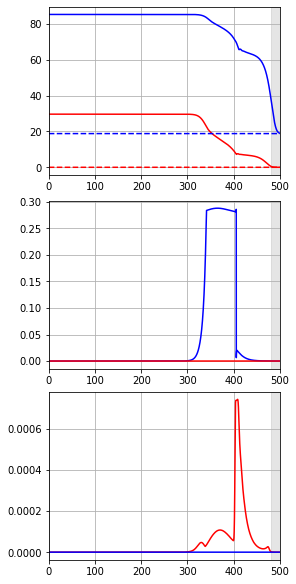

uncontrolled cost :  218854.09939826332
cost splitting :  9.621132262509493 [0.         2.35275045 0.0027109  0.        ]
-------  19 0.4250000000000001 0.4750000000000002
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  211572.5759679924
RUN  0 , total integrated cost =  211572.5759679924
Gradient descend method:  None
RUN  1 , total integrated cost =  2995.1369900480067
RUN  2 , total integrated cost =  2423.585858305369
RUN  3 , total integrated cost =  2396.9253937174344
RUN  4 , total integrated cost =  2396.122318650267
RUN  5 , total integrated cost =  2395.816885044811
RUN  6 , total integrated cost =  2395.0994577590714
RUN  7 , total integrated cost =  2394.768624102803
RUN  8 , total integrated cost =  2394.055771513179
RUN  9 , total integrated cost =  2393.7245634020237
RUN  10 , total integrated cost =  2393.0239512539115
RUN  10 , total integrated cost =  2393.0239512539115
Improved over  10  iterations in  5.965815208037384  seconds

ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  20687.961026639616
RUN  20 , total integrated cost =  20687.961026639616
Improved over  20  iterations in  12.287143627996556  seconds by  90.22181351624259  percent.
Problem in initial value trasfer post:  tau_exc 20.95955620553127 20.959556180467903
weight =  9900.0


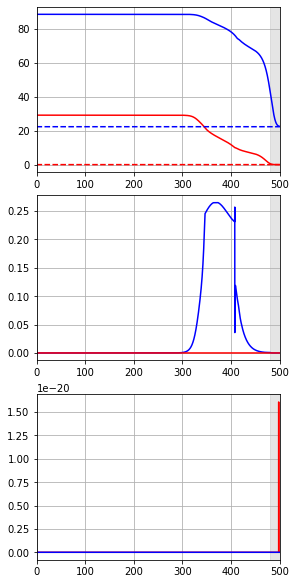

uncontrolled cost :  211572.5759679924
cost splitting :  7.3532222250519625 [0.00000000e+00 2.08895028e+00 5.08035516e-21 0.00000000e+00]
-------  25 0.4250000000000001 0.5000000000000002
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  204814.76624161197
RUN  0 , total integrated cost =  204814.76624161197
Gradient descend method:  None
RUN  1 , total integrated cost =  2973.8191192050426
RUN  2 , total integrated cost =  2373.8243783221233
RUN  3 , total integrated cost =  2364.6815993385253
RUN  4 , total integrated cost =  2364.339245802167
RUN  5 , total integrated cost =  2363.207629755594
RUN  6 , total integrated cost =  2362.8610891706658
RUN  7 , total integrated cost =  2361.6417546555936
RUN  8 , total integrated cost =  2361.280226682371
RUN  9 , total integrated cost =  2359.4856367330167
RUN  10 , total integrated cost =  2351.899117788038
RUN  10 , total integrated cost =  2351.899117788038
Improved over  10  iterations in  6.111060

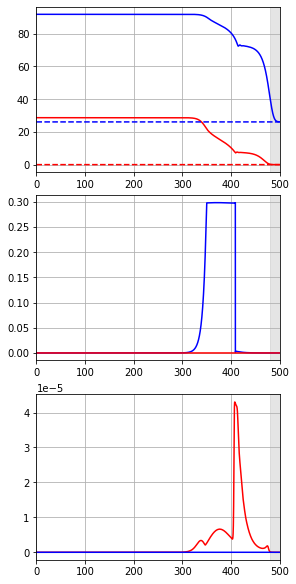

uncontrolled cost :  204814.76624161197
cost splitting :  0.6844920121404283 [0.00000000e+00 2.35490334e+00 1.54649831e-04 0.00000000e+00]
-------  55 0.4250000000000001 0.6250000000000003
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  176973.53086129532
RUN  0 , total integrated cost =  176973.53086129532
Gradient descend method:  None
RUN  1 , total integrated cost =  2871.821942762479
RUN  2 , total integrated cost =  2705.4622720544403
RUN  3 , total integrated cost =  2629.943569565683
RUN  4 , total integrated cost =  2527.3754688111
RUN  5 , total integrated cost =  2470.748987764474
RUN  6 , total integrated cost =  2390.6116525977454
RUN  7 , total integrated cost =  2341.978911630934
RUN  8 , total integrated cost =  2272.982365178096
RUN  9 , total integrated cost =  2235.4198786375346


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2184.8323016527443
RUN  10 , total integrated cost =  2184.8323016527443
Improved over  10  iterations in  7.119260084000416  seconds by  98.7654468490177  percent.
Problem in initial value trasfer post:  sigmae_f 1.5005087510807322 1.500679266789949
Problem in initial value trasfer post:  tau_exc 21.537158531671835 21.536268584306722
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  176973.53086129532
RUN  0 , total integrated cost =  176973.53086129532
Gradient descend method:  None
RUN  1 , total integrated cost =  25187.0760413485
RUN  2 , total integrated cost =  19608.371826763814
RUN  3 , total integrated cost =  17481.65127714098
RUN  4 , total integrated cost =  15483.457172666478
RUN  5 , total integrated cost =  15478.223475052868
RUN  6 , total integrated cost =  15474.620063114739
RUN  7 , total integrated cost =  15469.908925394035
RUN  8 , total integrated cost =  15466.36259471883
RUN  9 , total int

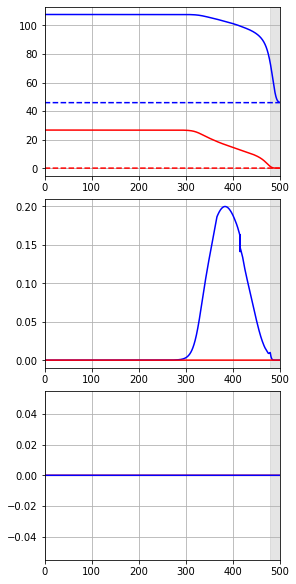

uncontrolled cost :  176973.53086129532
cost splitting :  28.187800767993956 [0.         1.67068634 0.         0.        ]
-------  62 0.4250000000000001 0.6500000000000004
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  172327.22420179544
RUN  0 , total integrated cost =  172327.22420179544
Gradient descend method:  None
RUN  1 , total integrated cost =  2853.013510358498
RUN  2 , total integrated cost =  2671.006481790685
RUN  3 , total integrated cost =  2590.616971241369
RUN  4 , total integrated cost =  2478.917499067982
RUN  5 , total integrated cost =  2418.143448410009
RUN  6 , total integrated cost =  2325.0633208561435
RUN  7 , total integrated cost =  2277.6444477681525
RUN  8 , total integrated cost =  2214.732045675187
RUN  9 , total integrated cost =  2180.8106704102515


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2128.1894086331467
RUN  10 , total integrated cost =  2128.1894086331467
Improved over  10  iterations in  6.657563955057412  seconds by  98.76503006504588  percent.
Problem in initial value trasfer post:  sigmae_f 1.5005499210097308 1.5006565148093904
Problem in initial value trasfer post:  tau_exc 21.54166703325939 21.54111246284453
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  172327.22420179544
RUN  0 , total integrated cost =  172327.22420179544
Gradient descend method:  None
RUN  1 , total integrated cost =  25011.75344251609
RUN  2 , total integrated cost =  19418.262964353395
RUN  3 , total integrated cost =  19094.58799165941
RUN  4 , total integrated cost =  19077.507098558497
RUN  5 , total integrated cost =  19040.87082995958
RUN  6 , total integrated cost =  19023.625330857252
RUN  7 , total integrated cost =  18987.513233646296
RUN  8 , total integrated cost =  18970.18820965435
RUN  9 , total int

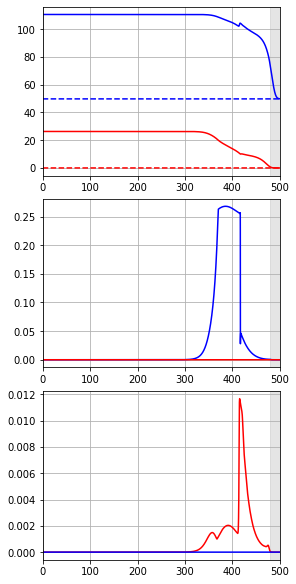

uncontrolled cost :  172327.22420179544
cost splitting :  9.771399537510414 [0.         1.90801679 0.04178277 0.        ]
-------  69 0.4250000000000001 0.6750000000000004
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  167933.86239870195
RUN  0 , total integrated cost =  167933.86239870195
Gradient descend method:  None
RUN  1 , total integrated cost =  2834.886477810384
RUN  2 , total integrated cost =  2649.3358278551295
RUN  3 , total integrated cost =  2563.9439164326145
RUN  4 , total integrated cost =  2443.997520889968
RUN  5 , total integrated cost =  2384.6547602122796
RUN  6 , total integrated cost =  2300.594595195926
RUN  7 , total integrated cost =  2250.211414651913
RUN  8 , total integrated cost =  2180.336523899357
RUN  9 , total integrated cost =  2139.1592068289087


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2070.826267226567
RUN  10 , total integrated cost =  2070.826267226567
Improved over  10  iterations in  6.617854702984914  seconds by  98.76687986708119  percent.
Problem in initial value trasfer post:  sigmae_f 1.5006378766037312 1.5007006203173987
Problem in initial value trasfer post:  tau_exc 21.51645320618579 21.516121348065358
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  167933.86239870195
RUN  0 , total integrated cost =  167933.86239870195
Gradient descend method:  None
RUN  1 , total integrated cost =  24838.357635028646
RUN  2 , total integrated cost =  18996.018370558366
RUN  3 , total integrated cost =  18879.09350263915
RUN  4 , total integrated cost =  18715.50220268699
RUN  5 , total integrated cost =  16552.81707899826
RUN  6 , total integrated cost =  16480.258840960163
RUN  7 , total integrated cost =  16461.02879698336
RUN  8 , total integrated cost =  16411.580929388245
RUN  9 , total inte

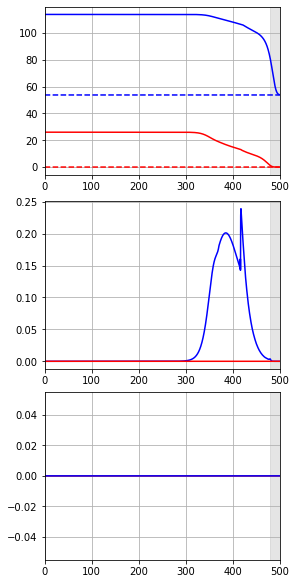

uncontrolled cost :  167933.86239870195
cost splitting :  27.27394946044882 [0.         1.61575306 0.         0.        ]
-------  76 0.4250000000000001 0.7000000000000004
set cost params:  1.0 0.0 1000.0
interpolate adjoint :  True True True
initial cost =  163736.8297408659
RUN  0 , total integrated cost =  163736.8297408659
Gradient descend method:  None
RUN  1 , total integrated cost =  2816.048747313801
RUN  2 , total integrated cost =  2597.332775009569
RUN  3 , total integrated cost =  2496.8104548595343
RUN  4 , total integrated cost =  2369.463136946034
RUN  5 , total integrated cost =  2307.9675392056492
RUN  6 , total integrated cost =  2225.958963660261
RUN  7 , total integrated cost =  2176.6524980792133
RUN  8 , total integrated cost =  2106.1864738360655
RUN  9 , total integrated cost =  2068.037162301238


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  2018.518402239057
RUN  10 , total integrated cost =  2018.518402239057
Improved over  10  iterations in  7.159371104906313  seconds by  98.76721785475289  percent.
Problem in initial value trasfer post:  sigmae_f 1.5005762911127354 1.5006130938813191
Problem in initial value trasfer post:  tau_exc 21.545317796028684 21.545126810984932
set cost params:  1.0 0.0 9000.0
interpolate adjoint :  True True True
initial cost =  163736.8297408659
RUN  0 , total integrated cost =  163736.8297408659
Gradient descend method:  None
RUN  1 , total integrated cost =  24673.39391208435
RUN  2 , total integrated cost =  18692.548213266553
RUN  3 , total integrated cost =  18500.168676914996
RUN  4 , total integrated cost =  18319.154569106115
RUN  5 , total integrated cost =  16156.680328537628
RUN  6 , total integrated cost =  16087.527488655636
RUN  7 , total integrated cost =  16066.238992845681
RUN  8 , total integrated cost =  16015.901897061247
RUN  9 , total in

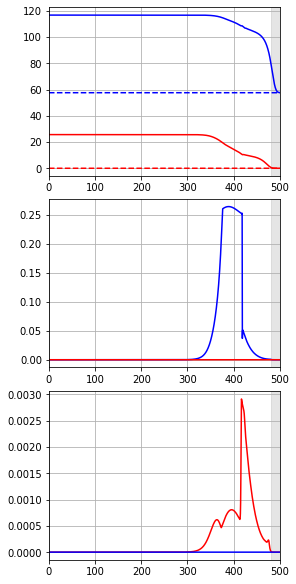

uncontrolled cost :  163736.8297408659
cost splitting :  12.124493127664325 [0.         1.82374606 0.01218507 0.        ]


In [70]:
cgv = None
j = 0

wp = 1.

for i in i_range:

    print("------- ", i, exc[i], inh[i])
    
    if type(bestControl_[i]) != type(None) or i in bad:
        continue
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    found_exponent = False
    found_digit_0 = False
    found_digit_1 = False
    exponent = 3
    sig_digit = [1., 0.]
    
    
    while not found_digit_1:
        
        if exponent < -10:
            bad.append(i)
            break
        
        w_[i] = sig_digit[0] * 10**exponent + sig_digit[1] * 10**(exponent-1.)
    
        aln.params.duration = dur
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        cost.setParams(wp, factor_we * w_[i], factor_ws * w_[i])
        max_it = int(10)
        
        if found_digit_0:
            max_it = int(20)

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if found_exponent == False and cost_[i][-1] == 0.:
            exponent -= 1
            continue
        elif found_exponent == False and found_digit_0 == False:
            found_exponent = True
            sig_digit[0] = 9.
        elif found_exponent == True and found_digit_0 == False and cost_[i][-1] == 0.:
            sig_digit[0] -= 1.
        elif found_exponent == True and found_digit_0 == False:
            found_digit_0 = True
            sig_digit[1] = 9.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False and cost_[i][-1] == 0.:
            sig_digit[1] -= 1.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False:
            print("weight = ", w_[i])
            
            if True:
                plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
                target_ = aln.getZeroTarget()
                target_[:,0,:] = target[i][0]
                target_[:,1,:] = target[i][1]

                fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

                ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
                ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
                ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
                ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

                ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
                ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

                ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
                ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

                for k in range(3):
                    ax[k].set_xlim(0.,dur)
                    ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
                plt.show()
                
            with open(file_,'wb') as f:
                pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

            print('uncontrolled cost : ', cost_uncontrolled[i])
            print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:]) 
            
            break

In [46]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  1 0.4250000000000001 0.3500000000000001
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  22791.92753754145
RUN  0 , total integrated cost =  22791.92753754145
Gradient descend method:  None
RUN  1 , total integrated cost =  22791.61269591905
RUN  2 , total integrated cost =  22791.138546944432
RUN  3 , total integrated cost =  22790.759029272158
RUN  4 , total integrated cost =  22790.484221877618
RUN  5 , total integrated cost =  22790.26770045414
RUN  6 , total integrated cost =  22789.9382412424
RUN  7 , total integrated cost =  22789.677327997888
RUN  8 , total integrated cost =  22789.35779217908
RUN  9 , total integrated cost =  22789.087594478493
RUN  10 , total integrated cost =  22788.783235004437
RUN  11 , total integrated cost =  22788.500183815562
RUN  12 , total integrated cost =  22787.868977624825
RUN  13 , total integrated cost =  22787.38535427458
RUN  14 , total integrated cost =  22786.713103145652
R

RUN  1 , total integrated cost =  31065.893024485056
Control only changes marginally.
RUN  1 , total integrated cost =  31065.893024485056
Improved over  1  iterations in  1.7873189439997077  seconds by  1.0023025481586956e-05  percent.
cost splitting :  21.850349848683962 [0.         2.23858147 0.         0.        ]
--------------- k  15
set cost params:  1.0 0.0 24778.902211411896
interpolate adjoint :  True True True
initial cost =  55491.5194035938
RUN  0 , total integrated cost =  55491.5194035938
Gradient descend method:  None
RUN  1 , total integrated cost =  55491.141510522124
RUN  2 , total integrated cost =  55491.14041328197
RUN  3 , total integrated cost =  55491.13844162758
RUN  4 , total integrated cost =  55491.13844162758
Control only changes marginally.
RUN  4 , total integrated cost =  55491.13844162758
Improved over  4  iterations in  6.429997528088279  seconds by  0.0006865228602634943  percent.
cost splitting :  23.23387833509406 [0.        2.2385134 0.        0. 

RUN  1 , total integrated cost =  150975.61784014694
Control only changes marginally.
RUN  1 , total integrated cost =  150975.61784014694
Improved over  1  iterations in  1.3629793720319867  seconds by  0.0  percent.
cost splitting :  30.364203066963572 [0.         2.23827224 0.         0.        ]
--------------- k  69
set cost params:  1.0 0.0 78350.72505820732
interpolate adjoint :  True True True
initial cost =  175400.616863919
RUN  0 , total integrated cost =  175400.616863919
Gradient descend method:  None
RUN  1 , total integrated cost =  175400.34028913095
RUN  2 , total integrated cost =  175400.3380044603
RUN  3 , total integrated cost =  175400.3270402609
RUN  4 , total integrated cost =  175400.3270402609
Control only changes marginally.
RUN  4 , total integrated cost =  175400.3270402609
Improved over  4  iterations in  5.565506005077623  seconds by  0.00016523525587786025  percent.
cost splitting :  33.355810046788534 [0.         2.23823036 0.         0.        ]
------

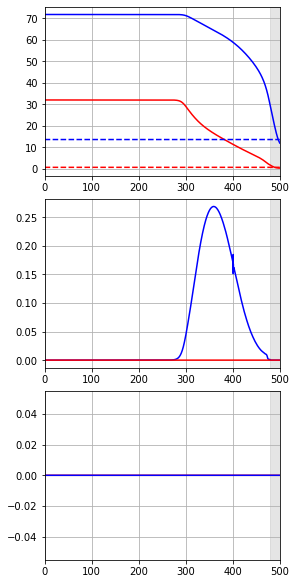

-------  2 0.4000000000000001 0.3750000000000001
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  4037.88530891297
RUN  0 , total integrated cost =  4037.88530891297
Gradient descend method:  None
RUN  1 , total integrated cost =  4015.912287963838
RUN  2 , total integrated cost =  3999.7258378302354
RUN  3 , total integrated cost =  3980.634366472992
RUN  4 , total integrated cost =  3966.5285547139965
RUN  5 , total integrated cost =  3949.7421214910305
RUN  6 , total integrated cost =  3937.0779891525135
RUN  7 , total integrated cost =  3921.88582278618
RUN  8 , total integrated cost =  3910.478827368623
RUN  9 , total integrated cost =  3896.7641274869948
RUN  10 , total integrated cost =  3886.2430847132355
RUN  11 , total integrated cost =  3873.143815547977
RUN  12 , total integrated cost =  3862.847371183059
RUN  13 , total integrated cost =  3850.4272199565316
RUN  14 , total integrated cost =  3841.173761073048
RUN  

RUN  2 , total integrated cost =  12731.778460094509
RUN  3 , total integrated cost =  12731.754170110069
RUN  4 , total integrated cost =  12731.748975537208
RUN  5 , total integrated cost =  12731.734335140178
RUN  6 , total integrated cost =  12731.726115128185
RUN  7 , total integrated cost =  12731.643437085288
RUN  8 , total integrated cost =  12731.569932535567
RUN  9 , total integrated cost =  12731.551267518698
RUN  10 , total integrated cost =  12731.52733885523
RUN  11 , total integrated cost =  12731.520137125597
RUN  12 , total integrated cost =  12731.508890108393
RUN  13 , total integrated cost =  12731.508890108393
Control only changes marginally.
RUN  13 , total integrated cost =  12731.508890108393
Improved over  13  iterations in  17.48409843596164  seconds by  0.0026162066969277475  percent.
cost splitting :  9.832825825443651 [0.        0.3341869 0.        0.       ]
--------------- k  8
set cost params:  1.0 0.0 42094.69688627001
interpolate adjoint :  True True T

RUN  1 , total integrated cost =  43679.72010824656
RUN  2 , total integrated cost =  43679.72010824656
Control only changes marginally.
RUN  2 , total integrated cost =  43679.72010824656
Improved over  2  iterations in  3.2879146239720285  seconds by  8.635223814223991e-05  percent.
cost splitting :  36.173525430305304 [0.        0.3338392 0.        0.       ]
--------------- k  31
set cost params:  1.0 0.0 134763.1180474352
interpolate adjoint :  True True True
initial cost =  45025.38564029615
RUN  0 , total integrated cost =  45025.38564029615
Gradient descend method:  None
RUN  1 , total integrated cost =  44952.75076902387
RUN  2 , total integrated cost =  44952.588057755114
RUN  3 , total integrated cost =  44952.569418716776
RUN  4 , total integrated cost =  44952.569418716776
Control only changes marginally.
RUN  4 , total integrated cost =  44952.569418716776
Improved over  4  iterations in  6.146371309063397  seconds by  0.16172259391866817  percent.
cost splitting :  25.80

RUN  1 , total integrated cost =  89402.01568827129
Control only changes marginally.
RUN  1 , total integrated cost =  89402.01568827129
Improved over  1  iterations in  1.8681164300069213  seconds by  0.0  percent.
cost splitting :  51.71383033866875 [0.         0.33314562 0.         0.        ]
--------------- k  75
set cost params:  1.0 0.0 312597.5872219694
interpolate adjoint :  True True True
initial cost =  104192.23072666682
RUN  0 , total integrated cost =  104192.23072666682
Gradient descend method:  None
RUN  1 , total integrated cost =  104191.31960401485
RUN  2 , total integrated cost =  104191.31960401485
Control only changes marginally.
RUN  2 , total integrated cost =  104191.31960401485
Improved over  2  iterations in  3.732454721000977  seconds by  0.0008744631395387614  percent.
cost splitting :  61.81460695077196 [0.         0.33311039 0.         0.        ]
--------------- k  76
set cost params:  1.0 0.0 316643.74322023
interpolate adjoint :  True True True
initial

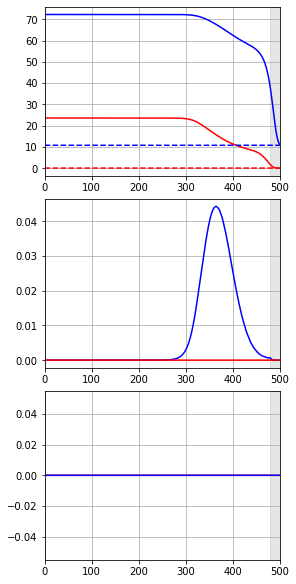

-------  3 0.4250000000000001 0.3750000000000001
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  22989.214892686385
RUN  0 , total integrated cost =  22989.214892686385
Gradient descend method:  None
RUN  1 , total integrated cost =  22976.572973206352
RUN  2 , total integrated cost =  22961.32719824528
RUN  3 , total integrated cost =  22948.348221852848
RUN  4 , total integrated cost =  22932.281889317906
RUN  5 , total integrated cost =  22918.922772471426
RUN  6 , total integrated cost =  22899.60678408593
RUN  7 , total integrated cost =  22884.850835171113
RUN  8 , total integrated cost =  22867.37043829586
RUN  9 , total integrated cost =  22852.69045856395
RUN  10 , total integrated cost =  22829.40090713177
RUN  11 , total integrated cost =  22810.393848588355
RUN  12 , total integrated cost =  22790.65871107365
RUN  13 , total integrated cost =  22774.521409927132
RUN  14 , total integrated cost =  22758.66309543834


RUN  8 , total integrated cost =  30442.99001098037
RUN  9 , total integrated cost =  30441.232816985714
RUN  10 , total integrated cost =  30441.22636400369
RUN  11 , total integrated cost =  30441.22636400369
Control only changes marginally.
RUN  11 , total integrated cost =  30441.22636400369
Improved over  11  iterations in  15.619324228959158  seconds by  0.027722785789094928  percent.
cost splitting :  13.102319212584142 [0.         2.18561408 0.         0.        ]
--------------- k  5
set cost params:  1.0 0.0 14929.01379635007
interpolate adjoint :  True True True
initial cost =  32642.165010874083
RUN  0 , total integrated cost =  32642.165010874083
Gradient descend method:  None
RUN  1 , total integrated cost =  32642.139987025
RUN  2 , total integrated cost =  32642.139987025
Control only changes marginally.
RUN  2 , total integrated cost =  32642.139987025
Improved over  2  iterations in  3.4543294169707224  seconds by  7.66611193796507e-05  percent.
cost splitting :  13.8

RUN  11 , total integrated cost =  56825.44059255908
RUN  12 , total integrated cost =  56825.40438669223
RUN  13 , total integrated cost =  56825.40438669223
Control only changes marginally.
RUN  13 , total integrated cost =  56825.40438669223
Improved over  13  iterations in  17.86683907895349  seconds by  0.001982247901551659  percent.
cost splitting :  22.970336945178513 [0.         2.18499371 0.         0.        ]
--------------- k  17
set cost params:  1.0 0.0 27003.21163038301
interpolate adjoint :  True True True
initial cost =  59024.81795445896
RUN  0 , total integrated cost =  59024.81795445896
Gradient descend method:  None
RUN  1 , total integrated cost =  59024.79752586085
RUN  2 , total integrated cost =  59024.79752586085
Control only changes marginally.
RUN  2 , total integrated cost =  59024.79752586085
Improved over  2  iterations in  3.4352174369851127  seconds by  3.461018401651472e-05  percent.
cost splitting :  23.91173806828333 [0.         2.18495809 0.        

RUN  5 , total integrated cost =  83207.3944168667
Control only changes marginally.
RUN  5 , total integrated cost =  83207.3944168667
Improved over  5  iterations in  8.226863172021694  seconds by  4.147746388127871e-05  percent.
cost splitting :  32.17326575209061 [0.         2.18438899 0.         0.        ]
--------------- k  29
set cost params:  1.0 0.0 39083.71697174675
interpolate adjoint :  True True True
initial cost =  85406.21428721295
RUN  0 , total integrated cost =  85406.21428721295
Gradient descend method:  None
RUN  1 , total integrated cost =  85406.20644244149
RUN  2 , total integrated cost =  85406.20644244149
Control only changes marginally.
RUN  2 , total integrated cost =  85406.20644244149
Improved over  2  iterations in  3.4462096670176834  seconds by  9.185246668153013e-06  percent.
cost splitting :  32.86074898902062 [0.        2.1843712 0.        0.       ]
--------------- k  30
set cost params:  1.0 0.0 40090.227695181115
interpolate adjoint :  True True Tr

RUN  1 , total integrated cost =  111789.52617835971
RUN  2 , total integrated cost =  111789.52617835971
Control only changes marginally.
RUN  2 , total integrated cost =  111789.52617835971
Improved over  2  iterations in  2.8256276219617575  seconds by  1.3307457493283437e-05  percent.
cost splitting :  43.562437212197786 [0.         2.18412987 0.         0.        ]
--------------- k  42
set cost params:  1.0 0.0 52169.3903449155
interpolate adjoint :  True True True
initial cost =  113988.28630460433
RUN  0 , total integrated cost =  113988.28630460433
Gradient descend method:  None
RUN  1 , total integrated cost =  113988.23919020937
RUN  2 , total integrated cost =  113988.20737426786
RUN  3 , total integrated cost =  113988.20737426786
Control only changes marginally.
RUN  3 , total integrated cost =  113988.20737426786
Improved over  3  iterations in  4.100738428067416  seconds by  6.924425221654928e-05  percent.
cost splitting :  43.93919733005576 [0.         2.18412114 0.   

RUN  1 , total integrated cost =  186532.98440018695
RUN  2 , total integrated cost =  186532.95787020415
RUN  3 , total integrated cost =  186532.95787020415
Control only changes marginally.
RUN  3 , total integrated cost =  186532.95787020415
Improved over  3  iterations in  4.597095227916725  seconds by  2.1346745853634275e-05  percent.
cost splitting :  73.079273147988 [0.         2.18368673 0.         0.        ]
--------------- k  76
set cost params:  1.0 0.0 86394.2442103363
interpolate adjoint :  True True True
initial cost =  188731.0435364979
RUN  0 , total integrated cost =  188731.0435364979
Gradient descend method:  None
RUN  1 , total integrated cost =  188730.702096718
RUN  2 , total integrated cost =  188730.28388198838
RUN  3 , total integrated cost =  188730.28388198838
Control only changes marginally.
RUN  3 , total integrated cost =  188730.28388198838
Improved over  3  iterations in  4.0248868020717055  seconds by  0.00040250638966199404  percent.
cost splitting : 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  195882.56355041132
Control only changes marginally.
RUN  10 , total integrated cost =  195882.56355041132
Improved over  10  iterations in  14.004415666917339  seconds by  18.882606896483097  percent.
Problem in initial value trasfer post:  sigmae_f 1.5034713576991614 1.503472014707025
Problem in initial value trasfer post:  tau_exc 2.4454509950242964 2.445450903043196
cost splitting :  140105.55958006412 [0.         0.50453132 0.         0.        ]
converged to zero, reload and break
file found
-------  5 0.4000000000000001 0.40000000000000013
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  3189.4927319917806
RUN  0 , total integrated cost =  3189.4927319917806
Gradient descend method:  None
RUN  1 , total integrated cost =  3184.2887068614195
RUN  2 , total integrated cost =  3177.2988853503216
RUN  3 , total integrated cost =  3172.4540027685584
RUN  4 , total integrated cost =  3166.1255

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  2827.340342078242
RUN  100 , total integrated cost =  2827.340342078242
Improved over  100  iterations in  128.95297913101967  seconds by  11.354545074864646  percent.
Problem in initial value trasfer post:  sigmae_f 1.5652906222616179 1.5652911957622884
Problem in initial value trasfer post:  tau_exc 20.28780194162244 20.287797577443857
cost splitting :  5.787143355969352 [0.         0.28500537 0.         0.        ]
--------------- k  1
set cost params:  1.0 0.0 14250.664416315638
interpolate adjoint :  True True True
initial cost =  4067.3030794946617
RUN  0 , total integrated cost =  4067.3030794946617
Gradient descend method:  None
RUN  1 , total integrated cost =  4067.020638497672
RUN  2 , total integrated cost =  4066.8924145352385
RUN  3 , total integrated cost =  4066.7343543484576
RUN  4 , total integrated cost =  4066.6233860887282
RUN  5 , total integrated cost =  4066.4833076399455
RUN  6 , total integrated cost =  4066.3795802538393
RU

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  4043.135662852218
RUN  100 , total integrated cost =  4043.135662852218
Improved over  100  iterations in  129.54567919299006  seconds by  0.5941877497225079  percent.
Problem in initial value trasfer post:  sigmae_f 1.5645141079066627 1.5645145978062538
Problem in initial value trasfer post:  tau_exc 20.28389138006122 20.283887637325716
cost splitting :  8.16123823288241 [0.        0.2831429 0.        0.       ]
--------------- k  2
set cost params:  1.0 0.0 18659.699708218766
interpolate adjoint :  True True True
initial cost =  5291.522693824958
RUN  0 , total integrated cost =  5291.522693824958
Gradient descend method:  None
RUN  1 , total integrated cost =  5291.399611413453
RUN  2 , total integrated cost =  5291.294408534044
RUN  3 , total integrated cost =  5286.5341883175815
RUN  4 , total integrated cost =  5283.689132108296
RUN  5 , total integrated cost =  5283.66836738462
RUN  6 , total integrated cost =  5283.621881373377
RUN  7 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  99 , total integrated cost =  5241.302574752796
Improved over  99  iterations in  135.1822046180023  seconds by  0.9490674419816258  percent.
Problem in initial value trasfer post:  sigmae_f 1.5659053493222557 1.5659057002910037
Problem in initial value trasfer post:  tau_exc 20.29180794797545 20.291805286499514
cost splitting :  4.144397745549973 [0.        0.2806668 0.        0.       ]
--------------- k  3
set cost params:  1.0 0.0 23158.518898885646
interpolate adjoint :  True True True
initial cost =  6503.97175376968
RUN  0 , total integrated cost =  6503.97175376968
Gradient descend method:  None
RUN  1 , total integrated cost =  6503.887471047224
RUN  2 , total integrated cost =  6503.882970993501
RUN  3 , total integrated cost =  6503.875383256359
RUN  4 , total integrated cost =  6503.871741331052
RUN  5 , total integrated cost =  6503.863898129623


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  6503.863898129623
Control only changes marginally.
RUN  6 , total integrated cost =  6503.863898129623
Improved over  6  iterations in  8.690086905960925  seconds by  0.001658304250696574  percent.
Problem in initial value trasfer post:  sigmae_f 1.5655179279928602 1.5655182759007888
Problem in initial value trasfer post:  tau_exc 20.288796908257908 20.288794263671722
cost splitting :  5.152328496077578 [0.         0.28061862 0.         0.        ]
--------------- k  4
set cost params:  1.0 0.0 27580.98471807436
interpolate adjoint :  True True True
initial cost =  7744.890144711114
RUN  0 , total integrated cost =  7744.890144711114
Gradient descend method:  None
RUN  1 , total integrated cost =  7744.831454556122
RUN  2 , total integrated cost =  7744.826555115877
RUN  3 , total integrated cost =  7744.818291629675


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  7744.818291629675
Control only changes marginally.
RUN  4 , total integrated cost =  7744.818291629675
Improved over  4  iterations in  5.842865931917913  seconds by  0.0009277482326552899  percent.
Problem in initial value trasfer post:  sigmae_f 1.5651976527195433 1.5651979980815593
Problem in initial value trasfer post:  tau_exc 20.286554529744325 20.286551899572636
cost splitting :  6.0487204642361 [0.         0.28058351 0.         0.        ]
--------------- k  5
set cost params:  1.0 0.0 32003.89831388666
interpolate adjoint :  True True True
initial cost =  8985.81492394846
RUN  0 , total integrated cost =  8985.81492394846
Gradient descend method:  None
RUN  1 , total integrated cost =  8985.74958560763
RUN  2 , total integrated cost =  8985.743630156781
RUN  3 , total integrated cost =  8985.73232997748


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  8985.73232997748
Control only changes marginally.
RUN  4 , total integrated cost =  8985.73232997748
Improved over  4  iterations in  5.430873486911878  seconds by  0.0009191594939181869  percent.
Problem in initial value trasfer post:  sigmae_f 1.564843138596016 1.5648434809628595
Problem in initial value trasfer post:  tau_exc 20.28427073556672 20.284268122983462
cost splitting :  7.096338610153475 [0.        0.2805482 0.        0.       ]
--------------- k  6
set cost params:  1.0 0.0 36427.86756877956
interpolate adjoint :  True True True
initial cost =  10226.868931122368
RUN  0 , total integrated cost =  10226.868931122368
Gradient descend method:  None
RUN  1 , total integrated cost =  10226.814982817956


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  10226.814982817956
Control only changes marginally.
RUN  2 , total integrated cost =  10226.814982817956
Improved over  2  iterations in  3.2671407390153036  seconds by  0.0005275153595505344  percent.
Problem in initial value trasfer post:  sigmae_f 1.564547256526913 1.564547596815813
Problem in initial value trasfer post:  tau_exc 20.282488039143495 20.282485438205093
cost splitting :  8.014540508207006 [0.         0.28052151 0.         0.        ]
--------------- k  7
set cost params:  1.0 0.0 40851.959937586755
interpolate adjoint :  True True True
initial cost =  11467.868057632919
RUN  0 , total integrated cost =  11467.868057632919
Gradient descend method:  None
RUN  1 , total integrated cost =  11467.818152841919
RUN  2 , total integrated cost =  11467.80954592905
RUN  3 , total integrated cost =  11467.794865648435


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  11467.794865648435
Control only changes marginally.
RUN  4 , total integrated cost =  11467.794865648435
Improved over  4  iterations in  5.850868936046027  seconds by  0.0006382353207641245  percent.
Problem in initial value trasfer post:  sigmae_f 1.5642527937251902 1.564253131162151
Problem in initial value trasfer post:  tau_exc 20.280799344314282 20.280796761098575
cost splitting :  8.978172471636634 [0.         0.28049613 0.         0.        ]
--------------- k  8
set cost params:  1.0 0.0 45276.66602870647
interpolate adjoint :  True True True
initial cost =  12708.90780360259
RUN  0 , total integrated cost =  12708.90780360259
Gradient descend method:  None
RUN  1 , total integrated cost =  12708.861642617323


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  12708.861642617323
Control only changes marginally.
RUN  2 , total integrated cost =  12708.861642617323
Improved over  2  iterations in  2.9725112629821524  seconds by  0.0003632175634606938  percent.
Problem in initial value trasfer post:  sigmae_f 1.56396322923831 1.5639635645756136
Problem in initial value trasfer post:  tau_exc 20.279207140447905 20.279204569386298
cost splitting :  9.970955137519688 [0.         0.28047318 0.         0.        ]
--------------- k  9
set cost params:  1.0 0.0 49701.75969222714
interpolate adjoint :  True True True
initial cost =  13949.981752461106
RUN  0 , total integrated cost =  13949.981752461106
Gradient descend method:  None
RUN  1 , total integrated cost =  13949.937693380003


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  13949.937693380003
Control only changes marginally.
RUN  2 , total integrated cost =  13949.937693380003
Improved over  2  iterations in  3.4142292661126703  seconds by  0.0003158361199666615  percent.
Problem in initial value trasfer post:  sigmae_f 1.5636853644628843 1.5636856977668745
Problem in initial value trasfer post:  tau_exc 20.27773005202397 20.277727492858993
cost splitting :  10.962217094054893 [0.         0.28045235 0.         0.        ]
--------------- k  10
set cost params:  1.0 0.0 54127.18227951502
interpolate adjoint :  True True True
initial cost =  15191.057872995189
RUN  0 , total integrated cost =  15191.057872995189
Gradient descend method:  None
RUN  1 , total integrated cost =  15191.011905320021
RUN  2 , total integrated cost =  15191.002179871604
RUN  3 , total integrated cost =  15190.98564095413


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  15190.98564095413
Control only changes marginally.
RUN  4 , total integrated cost =  15190.98564095413
Improved over  4  iterations in  6.360833963030018  seconds by  0.0004754905264832132  percent.
Problem in initial value trasfer post:  sigmae_f 1.5633561497277764 1.5633564797713675
Problem in initial value trasfer post:  tau_exc 20.27602371567476 20.276021177247323
cost splitting :  12.183695647461162 [0.         0.28042845 0.         0.        ]
--------------- k  11
set cost params:  1.0 0.0 58553.660690358105
interpolate adjoint :  True True True
initial cost =  16432.296130134928
RUN  0 , total integrated cost =  16432.296130134928
Gradient descend method:  None
RUN  1 , total integrated cost =  16432.26266816889
RUN  2 , total integrated cost =  16432.257197211915
RUN  3 , total integrated cost =  16432.241730068487


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  16432.241730068487
Control only changes marginally.
RUN  4 , total integrated cost =  16432.241730068487
Improved over  4  iterations in  5.487783404067159  seconds by  0.00033105578192760277  percent.
Problem in initial value trasfer post:  sigmae_f 1.5630904058167923 1.5630907331960566
Problem in initial value trasfer post:  tau_exc 20.27464086412456 20.274638342954727
cost splitting :  13.202957357500825 [0.         0.28041012 0.         0.        ]
--------------- k  12
set cost params:  1.0 0.0 62979.83300449102
interpolate adjoint :  True True True
initial cost =  17673.385221075107
RUN  0 , total integrated cost =  17673.385221075107
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  17673.385221075107
Control only changes marginally.
RUN  1 , total integrated cost =  17673.385221075107
Improved over  1  iterations in  1.2726940650027245  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5630904058167923 1.5630907331960566
Problem in initial value trasfer post:  tau_exc 20.27464086412456 20.274638342954727
cost splitting :  13.202957357500825 [0.         0.28041012 0.         0.        ]
--------------- k  23
set cost params:  1.0 0.0 111636.34659194112
interpolate adjoint :  True True True
initial cost =  31317.163828905752
RUN  0 , total integrated cost =  31317.163828905752
Gradient descend method:  None
RUN  1 , total integrated cost =  31313.023340346565
RUN  2 , total integrated cost =  31312.69424707371
RUN  3 , total integrated cost =  31312.374175740224
RUN  4 , total integrated cost =  31300.402096488564
RUN  5 , total integrated cost =  31295.85980106359
RUN  6 , total integrated cost =  31295.

ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  33804.574698401404
Control only changes marginally.
RUN  3 , total integrated cost =  33804.574698401404
Improved over  3  iterations in  5.01896938693244  seconds by  0.000905730375592384  percent.
Problem in initial value trasfer post:  tau_exc 20.258265358366806 20.258265339204932
cost splitting :  25.938957021509268 [0.         0.28010303 0.         0.        ]
--------------- k  26
set cost params:  1.0 0.0 125023.38872752694
interpolate adjoint :  True True True
initial cost =  35045.36930811412
RUN  0 , total integrated cost =  35045.36930811412
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  35045.36930811412
Control only changes marginally.
RUN  1 , total integrated cost =  35045.36930811412
Improved over  1  iterations in  1.5972638750681654  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.258265358366806 20.258265339204932
cost splitting :  25.938957021509268 [0.         0.28010303 0.         0.        ]
--------------- k  37
set cost params:  1.0 0.0 173729.43780455756
interpolate adjoint :  True True True
initial cost =  48688.08136935286
RUN  0 , total integrated cost =  48688.08136935286
Gradient descend method:  None
RUN  1 , total integrated cost =  48685.75407550513
RUN  2 , total integrated cost =  48685.73403752492


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  48685.73403752492
Control only changes marginally.
RUN  3 , total integrated cost =  48685.73403752492
Improved over  3  iterations in  3.9567809300497174  seconds by  0.004821163130529271  percent.
Problem in initial value trasfer post:  tau_exc 20.247021220397666 20.247021200538853
cost splitting :  36.96220865429746 [0.         0.28002607 0.         0.        ]
--------------- k  38
set cost params:  1.0 0.0 178189.57932797313
interpolate adjoint :  True True True
initial cost =  49934.6899429784
RUN  0 , total integrated cost =  49934.6899429784
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  49934.6899429784
Control only changes marginally.
RUN  1 , total integrated cost =  49934.6899429784
Improved over  1  iterations in  1.4426170659717172  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.247021220397666 20.247021200538853
cost splitting :  36.96220865429746 [0.         0.28002607 0.         0.        ]
--------------- k  49
set cost params:  1.0 0.0 226904.98387028114
interpolate adjoint :  True True True
initial cost =  63576.273258271314
RUN  0 , total integrated cost =  63576.273258271314
Gradient descend method:  None
RUN  1 , total integrated cost =  63574.225202773756
RUN  2 , total integrated cost =  63567.79837570676
RUN  3 , total integrated cost =  63562.362003354734


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  63562.362003354734
Control only changes marginally.
RUN  4 , total integrated cost =  63562.362003354734
Improved over  4  iterations in  6.3503004550002515  seconds by  0.02188120536740712  percent.
Problem in initial value trasfer post:  sigmae_f 1.556631074460386 1.556631106816389
Problem in initial value trasfer post:  tau_exc 20.235717658769538 20.23571740408635
cost splitting :  49.01908936020828 [0.         0.27991163 0.         0.        ]
--------------- k  50
set cost params:  1.0 0.0 231404.67954119007
interpolate adjoint :  True True True
initial cost =  64821.879133742834
RUN  0 , total integrated cost =  64821.879133742834
Gradient descend method:  None
RUN  1 , total integrated cost =  64821.81470139385


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  64821.81470139385
Control only changes marginally.
RUN  2 , total integrated cost =  64821.81470139385
Improved over  2  iterations in  2.864500192925334  seconds by  9.939907612022125e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5562888563197752 1.5562888884442194
Problem in initial value trasfer post:  tau_exc 20.233397242549707 20.233396989379763
cost splitting :  51.56015777384538 [0.         0.27990037 0.         0.        ]
--------------- k  51
set cost params:  1.0 0.0 235839.43485037494
interpolate adjoint :  True True True
initial cost =  66063.10433643532
RUN  0 , total integrated cost =  66063.10433643532
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  66063.10433643532
Control only changes marginally.
RUN  1 , total integrated cost =  66063.10433643532
Improved over  1  iterations in  1.4024030789732933  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5562888563197752 1.5562888884442194
Problem in initial value trasfer post:  tau_exc 20.233397242549707 20.233396989379763
cost splitting :  51.56015777384538 [0.         0.27990037 0.         0.        ]
--------------- k  62
set cost params:  1.0 0.0 284571.46981810284
interpolate adjoint :  True True True
initial cost =  79703.21876949928
RUN  0 , total integrated cost =  79703.21876949928
Gradient descend method:  None
RUN  1 , total integrated cost =  79702.21927441655


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  79702.21927441655
Control only changes marginally.
RUN  2 , total integrated cost =  79702.21927441655
Improved over  2  iterations in  3.6181246750056744  seconds by  0.0012540209770151023  percent.
Problem in initial value trasfer post:  sigmae_f 1.5549458524951962 1.5549458834849539
Problem in initial value trasfer post:  tau_exc 20.223746519832627 20.223746274397364
cost splitting :  62.23465676512593 [0.         0.27985934 0.         0.        ]
--------------- k  63
set cost params:  1.0 0.0 289019.45136944595
interpolate adjoint :  True True True
initial cost =  80947.02846964258
RUN  0 , total integrated cost =  80947.02846964258
Gradient descend method:  None
RUN  1 , total integrated cost =  80946.92818742924


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  80946.92818742924
Control only changes marginally.
RUN  2 , total integrated cost =  80946.92818742924
Improved over  2  iterations in  3.5760651968885213  seconds by  0.00012388621946968215  percent.
Problem in initial value trasfer post:  sigmae_f 1.554540331743082 1.5545403624192282
Problem in initial value trasfer post:  tau_exc 20.220634030347025 20.220633787021605
cost splitting :  65.71891458873081 [0.         0.27984694 0.         0.        ]
--------------- k  64
set cost params:  1.0 0.0 293454.7978089701
interpolate adjoint :  True True True
initial cost =  82188.14631954083
RUN  0 , total integrated cost =  82188.14631954083
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  82188.14631954083
Control only changes marginally.
RUN  1 , total integrated cost =  82188.14631954083
Improved over  1  iterations in  1.857594233006239  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.554540331743082 1.5545403624192282
Problem in initial value trasfer post:  tau_exc 20.220634030347025 20.220633787021605
cost splitting :  65.71891458873081 [0.         0.27984694 0.         0.        ]
--------------- k  75
set cost params:  1.0 0.0 342190.77868238685
interpolate adjoint :  True True True
initial cost =  95826.76146970676
RUN  0 , total integrated cost =  95826.76146970676
Gradient descend method:  None
RUN  1 , total integrated cost =  95826.10278580729


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  95826.10278580729
Control only changes marginally.
RUN  2 , total integrated cost =  95826.10278580729
Improved over  2  iterations in  3.702926717000082  seconds by  0.0006873694669167207  percent.
Problem in initial value trasfer post:  sigmae_f 1.5534214301786975 1.553421459878722
Problem in initial value trasfer post:  tau_exc 20.211472360511614 20.21147212389411
cost splitting :  76.02786468941753 [0.         0.27981489 0.         0.        ]
--------------- k  76
set cost params:  1.0 0.0 346632.75382188556
interpolate adjoint :  True True True
initial cost =  97069.03356857836
RUN  0 , total integrated cost =  97069.03356857836
Gradient descend method:  None
RUN  1 , total integrated cost =  97068.58771923435
RUN  2 , total integrated cost =  97068.02066940132


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  97068.02066940132
Control only changes marginally.
RUN  3 , total integrated cost =  97068.02066940132
Improved over  3  iterations in  5.901554683921859  seconds by  0.0010434833229595597  percent.
Problem in initial value trasfer post:  sigmae_f 1.553377155224759 1.5533771849276186
Problem in initial value trasfer post:  tau_exc 20.211094759279803 20.211094522597808
cost splitting :  76.45621909210894 [0.         0.27981073 0.         0.        ]
--------------- k  77
set cost params:  1.0 0.0 351067.451998647
interpolate adjoint :  True True True
initial cost =  98308.89681075422
RUN  0 , total integrated cost =  98308.89681075422
Gradient descend method:  None
RUN  1 , total integrated cost =  98306.50333983067
RUN  2 , total integrated cost =  98304.43644544455


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  98304.43644544455
Control only changes marginally.
RUN  3 , total integrated cost =  98304.43644544455
Improved over  3  iterations in  5.122471384936944  seconds by  0.004537092220914474  percent.
Problem in initial value trasfer post:  sigmae_f 1.553344893494088 1.5533449232858927
Problem in initial value trasfer post:  tau_exc 20.210822951518637 20.210822714097457
cost splitting :  76.77006372423203 [0.         0.27979713 0.         0.        ]
--------------- k  78
set cost params:  1.0 0.0 355514.4958169814
interpolate adjoint :  True True True
initial cost =  99548.70655389632
RUN  0 , total integrated cost =  99548.70655389632
Gradient descend method:  None
RUN  1 , total integrated cost =  99547.59462436146
RUN  2 , total integrated cost =  99546.64560325374
RUN  3 , total integrated cost =  99543.55977924938
RUN  4 , total integrated cost =  99540.1568870361


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  99540.1568870361
Control only changes marginally.
RUN  5 , total integrated cost =  99540.1568870361
Improved over  5  iterations in  8.056938271969557  seconds by  0.008588425863280236  percent.
Problem in initial value trasfer post:  sigmae_f 1.5533334502599059 1.5533334800738434
Problem in initial value trasfer post:  tau_exc 20.21072865182689 20.21072841421865
cost splitting :  76.88182191840625 [0.         0.27977277 0.         0.        ]
--------------- k  79
set cost params:  1.0 0.0 359976.29891493166
interpolate adjoint :  True True True
initial cost =  100788.4478963745
RUN  0 , total integrated cost =  100788.4478963745
Gradient descend method:  None
RUN  1 , total integrated cost =  100787.71198175031
RUN  2 , total integrated cost =  100786.80022996692
RUN  3 , total integrated cost =  100786.75633873814


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  100786.75633873814
Control only changes marginally.
RUN  4 , total integrated cost =  100786.75633873814
Improved over  4  iterations in  6.784796716994606  seconds by  0.0016783249188563332  percent.
Problem in initial value trasfer post:  sigmae_f 1.5535560387589669 1.5535560687446988
Problem in initial value trasfer post:  tau_exc 20.21262255430223 20.21262231553722
cost splitting :  74.73958111582435 [0.         0.27977402 0.         0.        ]
--------------- k  80
set cost params:  1.0 0.0 364412.1482500944
interpolate adjoint :  True True True
initial cost =  102027.79174557966
RUN  0 , total integrated cost =  102027.79174557966
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  102027.79174557966
Control only changes marginally.
RUN  1 , total integrated cost =  102027.79174557966
Improved over  1  iterations in  1.9233878509839997  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5535560387589669 1.5535560687446988
Problem in initial value trasfer post:  tau_exc 20.21262255430223 20.21262231553722
cost splitting :  74.73958111582435 [0.         0.27977402 0.         0.        ]
--------------- k  91
set cost params:  1.0 0.0 413157.56863448233
interpolate adjoint :  True True True
initial cost =  115665.49403155698
RUN  0 , total integrated cost =  115665.49403155698
Gradient descend method:  None
RUN  1 , total integrated cost =  115664.13315373885


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  115664.13315373885
Control only changes marginally.
RUN  2 , total integrated cost =  115664.13315373885
Improved over  2  iterations in  3.752495095017366  seconds by  0.0011765633558553645  percent.
Problem in initial value trasfer post:  sigmae_f 1.5520603422229018 1.552060370874732
Problem in initial value trasfer post:  tau_exc 20.197327753286082 20.19732752328913
cost splitting :  89.89979179884459 [0.         0.27973403 0.         0.        ]
--------------- k  92
set cost params:  1.0 0.0 417598.6912383402
interpolate adjoint :  True True True
initial cost =  116906.46629531408
RUN  0 , total integrated cost =  116906.46629531408
Gradient descend method:  None
RUN  1 , total integrated cost =  116905.7754558811
RUN  2 , total integrated cost =  116905.26830742805
RUN  3 , total integrated cost =  116905.22904056327


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  116905.22904056327
Control only changes marginally.
RUN  4 , total integrated cost =  116905.22904056327
Improved over  4  iterations in  7.499426432070322  seconds by  0.0010583287563292743  percent.
Problem in initial value trasfer post:  sigmae_f 1.552178774933904 1.552178803616643
Problem in initial value trasfer post:  tau_exc 20.19868748601554 20.19868725594237
cost splitting :  88.63305585149355 [0.        0.2797341 0.        0.       ]
--------------- k  93
set cost params:  1.0 0.0 422034.3037904363
interpolate adjoint :  True True True
initial cost =  118146.02114627222
RUN  0 , total integrated cost =  118146.02114627222
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  118146.02114627222
Control only changes marginally.
RUN  1 , total integrated cost =  118146.02114627222
Improved over  1  iterations in  1.9250001549953595  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.552178774933904 1.552178803616643
Problem in initial value trasfer post:  tau_exc 20.19868748601554 20.19868725594237
cost splitting :  88.63305585149355 [0.        0.2797341 0.        0.       ]
--------------- k  104
set cost params:  1.0 0.0 453055.1653660605
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None
RUN  1 , total integrated cost =  126823.01670292628


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  126823.01670292628
Control only changes marginally.
RUN  2 , total integrated cost =  126823.01670292628
Improved over  2  iterations in  3.6262337049702182  seconds by  0.0004710327791030977  percent.
Problem in initial value trasfer post:  sigmae_f 1.5512064048057543 1.551206432609154
Problem in initial value trasfer post:  tau_exc 20.187156190997737 20.18715596658033
cost splitting :  99.42750535472781 [0.         0.27970896 0.         0.        ]
--------------- k  105
set cost params:  1.0 0.0 453057.3010888262
interpolate adjoint :  True True True
initial cost =  126823.61408372025
RUN  0 , total integrated cost =  126823.61408372025
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  126823.61408372025
Control only changes marginally.
RUN  1 , total integrated cost =  126823.61408372025
Improved over  1  iterations in  1.8651244610082358  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5512064048057543 1.551206432609154
Problem in initial value trasfer post:  tau_exc 20.187156190997737 20.18715596658033
cost splitting :  99.42750535472781 [0.         0.27970896 0.         0.        ]


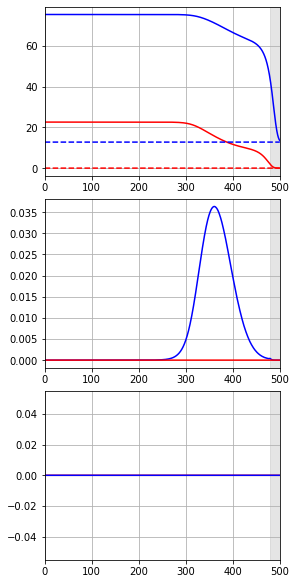

-------  9 0.4000000000000001 0.42500000000000016
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  2548.1612997008688
RUN  0 , total integrated cost =  2548.1612997008688
Gradient descend method:  None
RUN  1 , total integrated cost =  2541.105106780392
RUN  2 , total integrated cost =  2535.992705027359
RUN  3 , total integrated cost =  2521.7185813220335
RUN  4 , total integrated cost =  2512.3918194336143
RUN  5 , total integrated cost =  2501.2843419001756
RUN  6 , total integrated cost =  2494.6334282265743
RUN  7 , total integrated cost =  2474.069083708847
RUN  8 , total integrated cost =  2460.3670767464255
RUN  9 , total integrated cost =  2441.2667298045512
RUN  10 , total integrated cost =  2429.414218174647
RUN  11 , total integrated cost =  2397.122351050354
RUN  12 , total integrated cost =  2382.6187797543944
RUN  13 , total integrated cost =  2373.344626681006
RUN  14 , total integrated cost =  2366.876754390521

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  62 , total integrated cost =  2255.196061157184
Improved over  62  iterations in  70.29523521207739  seconds by  11.497122987390014  percent.
Problem in initial value trasfer post:  sigmae_f 1.548027920881137 1.5480279595482411
Problem in initial value trasfer post:  tau_exc 20.768220248626598 20.768219989901212
cost splitting :  2.7979013060202416 [0.         0.22751497 0.         0.        ]
--------------- k  1
set cost params:  1.0 0.0 14877.580303037503
interpolate adjoint :  True True True
initial cost =  3387.6700727807265
RUN  0 , total integrated cost =  3387.6700727807265
Gradient descend method:  None
RUN  1 , total integrated cost =  3387.32824885788
RUN  2 , total integrated cost =  3387.3180885185134
RUN  3 , total integrated cost =  3387.29953053562
RUN  4 , total integrated cost =  3387.2881899436657
RUN  5 , total integrated cost =  3387.2683847474327
RUN  6 , total integrated cost =  3387.2515086889384
RUN  7 , total integrated co

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  81 , total integrated cost =  3365.7667968403
Improved over  81  iterations in  105.94316934701055  seconds by  0.6465587105549417  percent.
Problem in initial value trasfer post:  sigmae_f 1.5480756071393822 1.5480756284685262
Problem in initial value trasfer post:  tau_exc 20.769854281494112 20.76985413883901
cost splitting :  2.624283678254917 [0.        0.2260544 0.        0.       ]
--------------- k  2
set cost params:  1.0 0.0 19920.776728527122
interpolate adjoint :  True True True
initial cost =  4505.803547126106
RUN  0 , total integrated cost =  4505.803547126106
Gradient descend method:  None
RUN  1 , total integrated cost =  4505.597938017302
RUN  2 , total integrated cost =  4505.575691328575
RUN  3 , total integrated cost =  4505.5506855129115
RUN  4 , total integrated cost =  4505.541178037132
RUN  5 , total integrated cost =  4505.530574702808
RUN  6 , total integrated cost =  4505.525305463908
RUN  7 , total integrated cost =  450

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  4505.499136100301
Control only changes marginally.
RUN  10 , total integrated cost =  4505.499136100301
Improved over  10  iterations in  14.244410502025858  seconds by  0.006755976433979072  percent.
Problem in initial value trasfer post:  sigmae_f 1.5477087258613251 1.5477087469465922
Problem in initial value trasfer post:  tau_exc 20.755980321355512 20.75598017983298
cost splitting :  3.990219944566395 [0.         0.22597055 0.         0.        ]
--------------- k  3
set cost params:  1.0 0.0 24936.67147835515
interpolate adjoint :  True True True
initial cost =  5638.943642132825
RUN  0 , total integrated cost =  5638.943642132825
Gradient descend method:  None
RUN  1 , total integrated cost =  5638.878236322338
RUN  2 , total integrated cost =  5638.869195425207


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  5638.869195425207
Control only changes marginally.
RUN  3 , total integrated cost =  5638.869195425207
Improved over  3  iterations in  4.72972062905319  seconds by  0.0013202243601284636  percent.
Problem in initial value trasfer post:  sigmae_f 1.547596555457151 1.5475965764611919
Problem in initial value trasfer post:  tau_exc 20.75227124427798 20.752271103164905
cost splitting :  4.443498376603011 [0.         0.22594939 0.         0.        ]
--------------- k  4
set cost params:  1.0 0.0 29950.729946648567
interpolate adjoint :  True True True
initial cost =  6771.792645324226
RUN  0 , total integrated cost =  6771.792645324226
Gradient descend method:  None
RUN  1 , total integrated cost =  6771.633888546923
RUN  2 , total integrated cost =  6771.565382982272
RUN  3 , total integrated cost =  6771.484283394589
RUN  4 , total integrated cost =  6771.451649762847
RUN  5 , total integrated cost =  6771.412137075564
RUN  6 , total integrated cost =  

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  6771.40465612461
Control only changes marginally.
RUN  7 , total integrated cost =  6771.40465612461
Improved over  7  iterations in  9.932471754029393  seconds by  0.005729490253727931  percent.
Problem in initial value trasfer post:  sigmae_f 1.5473674929287589 1.5473675135418818
Problem in initial value trasfer post:  tau_exc 20.744752243019253 20.744752104055376
cost splitting :  5.426087384875439 [0.         0.22590363 0.         0.        ]
--------------- k  5
set cost params:  1.0 0.0 34968.37229829795
interpolate adjoint :  True True True
initial cost =  7904.908269470081
RUN  0 , total integrated cost =  7904.908269470081
Gradient descend method:  None
RUN  1 , total integrated cost =  7904.769296530233
RUN  2 , total integrated cost =  7904.749906479869
RUN  3 , total integrated cost =  7904.724961725568
RUN  4 , total integrated cost =  7904.715225849593
RUN  5 , total integrated cost =  7904.698735983576


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  7904.698735983576
Control only changes marginally.
RUN  6 , total integrated cost =  7904.698735983576
Improved over  6  iterations in  8.722625570953824  seconds by  0.0026506757493223176  percent.
Problem in initial value trasfer post:  sigmae_f 1.547054091383241 1.5470541117351517
Problem in initial value trasfer post:  tau_exc 20.73538726740092 20.73538712956407
cost splitting :  6.874043646914348 [0.         0.22585623 0.         0.        ]
--------------- k  6
set cost params:  1.0 0.0 39988.0999782392
interpolate adjoint :  True True True
initial cost =  9038.435499057776
RUN  0 , total integrated cost =  9038.435499057776
Gradient descend method:  None
RUN  1 , total integrated cost =  9038.38028302961
RUN  2 , total integrated cost =  9038.368169251333
RUN  3 , total integrated cost =  9038.350108577491
RUN  4 , total integrated cost =  9038.342063823146


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  9038.342063823146
Control only changes marginally.
RUN  5 , total integrated cost =  9038.342063823146
Improved over  5  iterations in  7.520711197052151  seconds by  0.0010337545102885315  percent.
Problem in initial value trasfer post:  sigmae_f 1.5469274065037097 1.5469274267314312
Problem in initial value trasfer post:  tau_exc 20.731868232789346 20.73186809555324
cost splitting :  7.491708257666172 [0.         0.22583845 0.         0.        ]
--------------- k  7
set cost params:  1.0 0.0 45005.410461386105
interpolate adjoint :  True True True
initial cost =  10171.443666184017
RUN  0 , total integrated cost =  10171.443666184017
Gradient descend method:  None
RUN  1 , total integrated cost =  10171.349311787177
RUN  2 , total integrated cost =  10171.320887527852
RUN  3 , total integrated cost =  10171.28650258379
RUN  4 , total integrated cost =  10171.275844108231
RUN  5 , total integrated cost =  10171.257795591291
RUN  6 , total integrated 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  10171.245577175789
Control only changes marginally.
RUN  7 , total integrated cost =  10171.245577175789
Improved over  7  iterations in  10.857808921020478  seconds by  0.0019475014042171779  percent.
Problem in initial value trasfer post:  sigmae_f 1.5467354646352498 1.54673548462917
Problem in initial value trasfer post:  tau_exc 20.726769362338782 20.726769226341283
cost splitting :  8.472452097308436 [0.         0.22581225 0.         0.        ]
--------------- k  8
set cost params:  1.0 0.0 50024.8672939426
interpolate adjoint :  True True True
initial cost =  11304.700432435111
RUN  0 , total integrated cost =  11304.700432435111
Gradient descend method:  None
RUN  1 , total integrated cost =  11304.61238444284
RUN  2 , total integrated cost =  11304.59861342317
RUN  3 , total integrated cost =  11304.57697333667


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  11304.57697333667
Control only changes marginally.
RUN  4 , total integrated cost =  11304.57697333667
Improved over  4  iterations in  7.041878132964484  seconds by  0.0010921041134821508  percent.
Problem in initial value trasfer post:  sigmae_f 1.5464736529075982 1.5464736727070787
Problem in initial value trasfer post:  tau_exc 20.720198390808964 20.720198255684565
cost splitting :  9.889289062259431 [0.         0.22578146 0.         0.        ]
--------------- k  9
set cost params:  1.0 0.0 55046.188405790264
interpolate adjoint :  True True True
initial cost =  12438.298196174184
RUN  0 , total integrated cost =  12438.298196174184
Gradient descend method:  None
RUN  1 , total integrated cost =  12438.252348896747
RUN  2 , total integrated cost =  12438.239782794084
RUN  3 , total integrated cost =  12438.215248066364


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  12438.215248066364
Control only changes marginally.
RUN  4 , total integrated cost =  12438.215248066364
Improved over  4  iterations in  7.1073985090479255  seconds by  0.0006668766619952748  percent.
Problem in initial value trasfer post:  sigmae_f 1.5462685123188402 1.5462685319502796
Problem in initial value trasfer post:  tau_exc 20.715334227125076 20.715334092813052
cost splitting :  11.051082970851004 [0.         0.22575885 0.         0.        ]
--------------- k  10
set cost params:  1.0 0.0 60067.04052566005
interpolate adjoint :  True True True
initial cost =  13571.717046271277
RUN  0 , total integrated cost =  13571.717046271277
Gradient descend method:  None
RUN  1 , total integrated cost =  13571.677294927564
RUN  2 , total integrated cost =  13571.655850691102


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  13571.655850691102
Control only changes marginally.
RUN  3 , total integrated cost =  13571.655850691102
Improved over  3  iterations in  5.010422144085169  seconds by  0.00045090521682311646  percent.
Problem in initial value trasfer post:  sigmae_f 1.5462214672457812 1.5462214868037267
Problem in initial value trasfer post:  tau_exc 20.71425248913031 20.714252355246437
cost splitting :  11.322512331948655 [0.         0.22575331 0.         0.        ]
--------------- k  11
set cost params:  1.0 0.0 65084.99265100646
interpolate adjoint :  True True True
initial cost =  14704.475162249442
RUN  0 , total integrated cost =  14704.475162249442
Gradient descend method:  None
RUN  1 , total integrated cost =  14704.365338889744


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  14704.365338889744
Control only changes marginally.
RUN  2 , total integrated cost =  14704.365338889744
Improved over  2  iterations in  3.45320686197374  seconds by  0.0007468703131934262  percent.
Problem in initial value trasfer post:  sigmae_f 1.545936612539455 1.545936631929228
Problem in initial value trasfer post:  tau_exc 20.707911176429928 20.70791104325966
cost splitting :  13.02055529208104 [0.         0.22572553 0.         0.        ]
--------------- k  12
set cost params:  1.0 0.0 70108.4618714356
interpolate adjoint :  True True True
initial cost =  15838.290615993908
RUN  0 , total integrated cost =  15838.290615993908
Gradient descend method:  None
RUN  1 , total integrated cost =  15838.251447197405


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  15838.251447197405
Control only changes marginally.
RUN  2 , total integrated cost =  15838.251447197405
Improved over  2  iterations in  3.3748277170816436  seconds by  0.00024730444371812155  percent.
Problem in initial value trasfer post:  sigmae_f 1.5457611422730133 1.5457611615504467
Problem in initial value trasfer post:  tau_exc 20.70417672170843 20.704176589050387
cost splitting :  14.116671052022568 [0.         0.22570934 0.         0.        ]
--------------- k  13
set cost params:  1.0 0.0 75129.97426067264
interpolate adjoint :  True True True
initial cost =  16971.653702877837
RUN  0 , total integrated cost =  16971.653702877837
Gradient descend method:  None
RUN  1 , total integrated cost =  16971.61942132289


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  16971.61942132289
Control only changes marginally.
RUN  2 , total integrated cost =  16971.61942132289
Improved over  2  iterations in  3.4136720299720764  seconds by  0.00020199301464174368  percent.
Problem in initial value trasfer post:  sigmae_f 1.5456109483489389 1.5456109675296927
Problem in initial value trasfer post:  tau_exc 20.701063826251673 20.70106369404225
cost splitting :  15.083720788989858 [0.         0.22569601 0.         0.        ]
--------------- k  14
set cost params:  1.0 0.0 80151.2948942725
interpolate adjoint :  True True True
initial cost =  18104.91147187046
RUN  0 , total integrated cost =  18104.91147187046
Gradient descend method:  None
RUN  1 , total integrated cost =  18104.872213312927
RUN  2 , total integrated cost =  18104.858024858284
RUN  3 , total integrated cost =  18104.815298956328


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  18104.815298956328
Control only changes marginally.
RUN  4 , total integrated cost =  18104.815298956328
Improved over  4  iterations in  6.4879649200011045  seconds by  0.0005311979253832533  percent.
Problem in initial value trasfer post:  sigmae_f 1.5453524734561568 1.5453524924093285
Problem in initial value trasfer post:  tau_exc 20.695876336115568 20.6958762051147
cost splitting :  16.808364763255465 [0.        0.2256733 0.        0.       ]
--------------- k  15
set cost params:  1.0 0.0 85175.82461095222
interpolate adjoint :  True True True
initial cost =  19238.71748327221
RUN  0 , total integrated cost =  19238.71748327221
Gradient descend method:  None
RUN  1 , total integrated cost =  19238.590611835432
RUN  2 , total integrated cost =  19238.486869496133
RUN  3 , total integrated cost =  19238.341296140192
RUN  4 , total integrated cost =  19238.184557967154


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  19238.184557967154
Control only changes marginally.
RUN  5 , total integrated cost =  19238.184557967154
Improved over  5  iterations in  7.678549255011603  seconds by  0.0027700666924204143  percent.
Problem in initial value trasfer post:  sigmae_f 1.5452971525626156 1.5452971710260217
Problem in initial value trasfer post:  tau_exc 20.694789000649386 20.6947888729597
cost splitting :  17.18746572290635 [0.         0.22566259 0.         0.        ]
--------------- k  16
set cost params:  1.0 0.0 90197.82920539487
interpolate adjoint :  True True True
initial cost =  20371.463116148643
RUN  0 , total integrated cost =  20371.463116148643
Gradient descend method:  None
RUN  1 , total integrated cost =  20371.42066716847
RUN  2 , total integrated cost =  20371.400032035563
RUN  3 , total integrated cost =  20371.366970555933


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  20371.366970555933
Control only changes marginally.
RUN  4 , total integrated cost =  20371.366970555933
Improved over  4  iterations in  6.813805068028159  seconds by  0.00047196213724021163  percent.
Problem in initial value trasfer post:  sigmae_f 1.5450728187519343 1.5450728370264128
Problem in initial value trasfer post:  tau_exc 20.690464361775355 20.69046423509926
cost splitting :  18.75431789806646 [0.         0.22564415 0.         0.        ]
--------------- k  17
set cost params:  1.0 0.0 95222.37173019354
interpolate adjoint :  True True True
initial cost =  21505.12560604556
RUN  0 , total integrated cost =  21505.12560604556
Gradient descend method:  None
RUN  1 , total integrated cost =  21505.07852730558


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  21505.07852730558
Control only changes marginally.
RUN  2 , total integrated cost =  21505.07852730558
Improved over  2  iterations in  3.4111943799071014  seconds by  0.0002189186933350129  percent.
Problem in initial value trasfer post:  sigmae_f 1.544889382728487 1.544889400859845
Problem in initial value trasfer post:  tau_exc 20.687011229846476 20.687011103928626
cost splitting :  20.07415703157959 [0.        0.2256298 0.        0.       ]
--------------- k  18
set cost params:  1.0 0.0 100246.14291527255
interpolate adjoint :  True True True
initial cost =  22638.59099822479
RUN  0 , total integrated cost =  22638.59099822479
Gradient descend method:  None
RUN  1 , total integrated cost =  22638.32906751607
RUN  2 , total integrated cost =  22638.091124038747
RUN  3 , total integrated cost =  22637.449704305363
RUN  4 , total integrated cost =  22636.73166533204
RUN  5 , total integrated cost =  22636.686024259376
RUN  6 , total integrated cost =

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  22636.547964418092
Control only changes marginally.
RUN  9 , total integrated cost =  22636.547964418092
Improved over  9  iterations in  13.375639562960714  seconds by  0.009024562557186755  percent.
Problem in initial value trasfer post:  sigmae_f 1.5448061025239734 1.544806119090336
Problem in initial value trasfer post:  tau_exc 20.685464879872306 20.685464764726852
cost splitting :  20.6844572660893 [0.         0.22560333 0.         0.        ]
--------------- k  19
set cost params:  1.0 0.0 105276.2682113282
interpolate adjoint :  True True True
initial cost =  23771.36097378861
RUN  0 , total integrated cost =  23771.36097378861
Gradient descend method:  None
RUN  1 , total integrated cost =  23771.327629157586


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  23771.327629157586
Control only changes marginally.
RUN  2 , total integrated cost =  23771.327629157586
Improved over  2  iterations in  3.4648338449187577  seconds by  0.00014027228421298332  percent.
Problem in initial value trasfer post:  sigmae_f 1.544649788244525 1.544649804711412
Problem in initial value trasfer post:  tau_exc 20.682596491405466 20.682596376773528
cost splitting :  21.85682671688527 [0.         0.22559188 0.         0.        ]
--------------- k  20
set cost params:  1.0 0.0 110300.2298618486
interpolate adjoint :  True True True
initial cost =  24904.692560863787
RUN  0 , total integrated cost =  24904.692560863787
Gradient descend method:  None
RUN  1 , total integrated cost =  24904.63693201987
RUN  2 , total integrated cost =  24904.598264511318
RUN  3 , total integrated cost =  24826.771719288372
RUN  4 , total integrated cost =  24803.788392345534
RUN  5 , total integrated cost =  24803.731990914905
RUN  6 , total integrat

RUN  1 , total integrated cost =  83793.68570122929
RUN  2 , total integrated cost =  83793.68570122929
Control only changes marginally.
RUN  2 , total integrated cost =  83793.68570122929
Improved over  2  iterations in  3.5928223449736834  seconds by  0.0011290435968049906  percent.
cost splitting :  46.14424682208384 [0.         0.22449728 0.         0.        ]
--------------- k  73
set cost params:  1.0 0.0 378103.8754344511
interpolate adjoint :  True True True
initial cost =  84929.43615145193
RUN  0 , total integrated cost =  84929.43615145193
Gradient descend method:  None
RUN  1 , total integrated cost =  84889.36907527431
RUN  2 , total integrated cost =  84888.95534239507


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  84888.95534239507
Control only changes marginally.
RUN  3 , total integrated cost =  84888.95534239507
Improved over  3  iterations in  5.0046217440394685  seconds by  0.04766405017062425  percent.
Problem in initial value trasfer post:  tau_exc 20.636529331532962 20.636529309999617
cost splitting :  42.13118204466978 [0.         0.22440083 0.         0.        ]
--------------- k  74
set cost params:  1.0 0.0 383324.5711063367
interpolate adjoint :  True True True
initial cost =  86060.48379382447
RUN  0 , total integrated cost =  86060.48379382447
Gradient descend method:  None
RUN  1 , total integrated cost =  86060.442299418


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  86060.442299418
Control only changes marginally.
RUN  2 , total integrated cost =  86060.442299418
Improved over  2  iterations in  3.840345890959725  seconds by  4.821539995703006e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.633110128504434 20.633110107073136
cost splitting :  43.87934843073629 [0.         0.22439616 0.         0.        ]
--------------- k  75
set cost params:  1.0 0.0 388373.03514212184
interpolate adjoint :  True True True
initial cost =  87193.29825823793
RUN  0 , total integrated cost =  87193.29825823793
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  87193.29825823793
Control only changes marginally.
RUN  1 , total integrated cost =  87193.29825823793
Improved over  1  iterations in  2.033401972032152  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.633110128504434 20.633110107073136
cost splitting :  43.87934843073629 [0.         0.22439616 0.         0.        ]
--------------- k  86
set cost params:  1.0 0.0 443882.413629633
interpolate adjoint :  True True True
initial cost =  99649.38980295826
RUN  0 , total integrated cost =  99649.38980295826
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  99649.38980295826
Control only changes marginally.
RUN  1 , total integrated cost =  99649.38980295826
Improved over  1  iterations in  1.9825339840026572  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.633110128504434 20.633110107073136
cost splitting :  43.87934843073629 [0.         0.22439616 0.         0.        ]
--------------- k  97
set cost params:  1.0 0.0 499391.7921171442
interpolate adjoint :  True True True
initial cost =  112105.48134767858
RUN  0 , total integrated cost =  112105.48134767858
Gradient descend method:  None
RUN  1 , total integrated cost =  112103.7515524634


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  112103.7515524634
Control only changes marginally.
RUN  2 , total integrated cost =  112103.7515524634
Improved over  2  iterations in  3.7157425299519673  seconds by  0.0015430068132218366  percent.
Problem in initial value trasfer post:  tau_exc 20.609061595710507 20.6090615749477
cost splitting :  57.275080332025226 [0.         0.22436588 0.         0.        ]
--------------- k  98
set cost params:  1.0 0.0 504447.65754584584
interpolate adjoint :  True True True
initial cost =  113238.11522392396
RUN  0 , total integrated cost =  113238.11522392396
Gradient descend method:  None
RUN  1 , total integrated cost =  113236.20252140313
RUN  2 , total integrated cost =  113234.69119407426
RUN  3 , total integrated cost =  113234.63877619496


ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  113234.63877619496
Control only changes marginally.
RUN  4 , total integrated cost =  113234.63877619496
Improved over  4  iterations in  6.7864577289437875  seconds by  0.0030700331969768513  percent.
Problem in initial value trasfer post:  tau_exc 20.613300292364915 20.613300272452303
cost splitting :  54.775979749549485 [0.         0.22436394 0.         0.        ]
--------------- k  99
set cost params:  1.0 0.0 509509.4882325946
interpolate adjoint :  True True True
initial cost =  114370.33104090331
RUN  0 , total integrated cost =  114370.33104090331
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  114370.33104090331
Control only changes marginally.
RUN  1 , total integrated cost =  114370.33104090331
Improved over  1  iterations in  1.8792153348913416  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.613300292364915 20.613300272452303
cost splitting :  54.775979749549485 [0.         0.22436394 0.         0.        ]
--------------- k  110
set cost params:  1.0 0.0 514556.04871979257
interpolate adjoint :  True True True
initial cost =  115502.5972235114
RUN  0 , total integrated cost =  115502.5972235114
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  115502.5972235114
Control only changes marginally.
RUN  1 , total integrated cost =  115502.5972235114
Improved over  1  iterations in  1.852540530031547  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.613300292364915 20.613300272452303
cost splitting :  54.775979749549485 [0.         0.22436394 0.         0.        ]


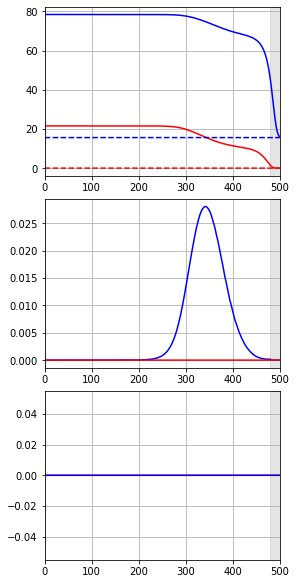

-------  10 0.4250000000000001 0.42500000000000016
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  22614.931365953686
RUN  0 , total integrated cost =  22614.931365953686
Gradient descend method:  None
RUN  1 , total integrated cost =  22606.76547549671
RUN  2 , total integrated cost =  22559.150967533296
RUN  3 , total integrated cost =  22536.48380147113
RUN  4 , total integrated cost =  20843.04240012027
RUN  5 , total integrated cost =  20825.629745544786
RUN  6 , total integrated cost =  20790.36350455092
RUN  7 , total integrated cost =  20772.163180745698
RUN  8 , total integrated cost =  20755.502068835376
RUN  9 , total integrated cost =  20746.726636938034
RUN  10 , total integrated cost =  20670.62471462315
RUN  11 , total integrated cost =  20669.0132588406
RUN  12 , total integrated cost =  20668.814512129535
RUN  13 , total integrated cost =  20668.571661999802
RUN  14 , total integrated cost =  20668.38028779153

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  20533.277854114756
RUN  100 , total integrated cost =  20533.277854114756
Improved over  100  iterations in  112.5573404529132  seconds by  9.204774837268872  percent.
Problem in initial value trasfer post:  sigmae_f 1.5466882379330085 1.5466918414130124
Problem in initial value trasfer post:  tau_exc 20.352365240422742 20.352337147115563
cost splitting :  6.704366029778013 [1.31217549e-09 2.07339126e+00 0.00000000e+00 0.00000000e+00]
--------------- k  1
set cost params:  1.0 0.0 10894.338131609518
interpolate adjoint :  True True True
initial cost =  22594.92984709333
RUN  0 , total integrated cost =  22594.92984709333
Gradient descend method:  None
RUN  1 , total integrated cost =  22594.878153799324
RUN  2 , total integrated cost =  22594.8737298471
RUN  3 , total integrated cost =  22594.863037515057
RUN  4 , total integrated cost =  22594.859184646106
RUN  5 , total integrated cost =  22594.841078854104
RUN  6 , total integrated cost =  22594.8

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  72 , total integrated cost =  22591.42859940328
Improved over  72  iterations in  95.95753206498921  seconds by  0.015495722773849252  percent.
Problem in initial value trasfer post:  sigmae_f 1.5465025465005522 1.54650608865657
Problem in initial value trasfer post:  tau_exc 20.34684758544902 20.34681992193105
cost splitting :  7.507253267262302 [1.31217549e-09 2.07299618e+00 0.00000000e+00 0.00000000e+00]
--------------- k  2
set cost params:  1.0 0.0 11889.085262658826
interpolate adjoint :  True True True
initial cost =  24653.535603566277
RUN  0 , total integrated cost =  24653.535603566277
Gradient descend method:  None
RUN  1 , total integrated cost =  24653.507660446783
RUN  2 , total integrated cost =  24653.506207920636
RUN  3 , total integrated cost =  24653.49574882061
RUN  4 , total integrated cost =  24653.49103400876
RUN  5 , total integrated cost =  24653.488808777758
RUN  6 , total integrated cost =  24653.485043866924
RUN  7 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  60 , total integrated cost =  24652.50861587329
Control only changes marginally.
RUN  60 , total integrated cost =  24652.50861587329
Improved over  60  iterations in  79.63098963396624  seconds by  0.004165681180595016  percent.
Problem in initial value trasfer post:  sigmae_f 1.5463672556688541 1.5463707118296797
Problem in initial value trasfer post:  tau_exc 20.342511815740696 20.342484787331518
cost splitting :  8.100882024515672 [1.31217549e-09 2.07285987e+00 0.00000000e+00 0.00000000e+00]
--------------- k  3
set cost params:  1.0 0.0 12883.835036659306
interpolate adjoint :  True True True
initial cost =  26714.48550324732
RUN  0 , total integrated cost =  26714.48550324732
Gradient descend method:  None
RUN  1 , total integrated cost =  26714.460981819695
RUN  2 , total integrated cost =  26714.45993957317
RUN  3 , total integrated cost =  26714.455636864215
RUN  4 , total integrated cost =  26714.454111332292
RUN  5 , total integrated cost =  26714.45069858282
RUN  6 , t

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  25 , total integrated cost =  26713.97890650235
Improved over  25  iterations in  33.00934643205255  seconds by  0.001896337269556625  percent.
Problem in initial value trasfer post:  sigmae_f 1.5462168870004738 1.546220270356994
Problem in initial value trasfer post:  tau_exc 20.33777679290069 20.337750294672233
cost splitting :  8.781034188327217 [1.31217549e-09 2.07276776e+00 0.00000000e+00 0.00000000e+00]
--------------- k  4
set cost params:  1.0 0.0 13878.627985542624
interpolate adjoint :  True True True
initial cost =  28775.953657523394
RUN  0 , total integrated cost =  28775.953657523394
Gradient descend method:  None
RUN  1 , total integrated cost =  28775.935685663408


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  28775.935685663408
Control only changes marginally.
RUN  2 , total integrated cost =  28775.935685663408
Improved over  2  iterations in  3.203253422048874  seconds by  6.245443748298385e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5460931020958426 1.546096471865202
Problem in initial value trasfer post:  tau_exc 20.334034635884414 20.33400821296123
cost splitting :  9.356728548673665 [1.31217549e-09 2.07272498e+00 0.00000000e+00 0.00000000e+00]
--------------- k  5
set cost params:  1.0 0.0 14873.383945509877
interpolate adjoint :  True True True
initial cost =  30837.79121599879
RUN  0 , total integrated cost =  30837.79121599879
Gradient descend method:  None
RUN  1 , total integrated cost =  30837.77010796596


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  30837.77010796596
Control only changes marginally.
RUN  2 , total integrated cost =  30837.77010796596
Improved over  2  iterations in  3.7401208139490336  seconds by  6.844858856425162e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459650268956873 1.5459683825136992
Problem in initial value trasfer post:  tau_exc 20.330241758895426 20.330215415387386
cost splitting :  9.970366691647381 [1.31217549e-09 2.07268231e+00 0.00000000e+00 0.00000000e+00]
--------------- k  6
set cost params:  1.0 0.0 15868.178084226316
interpolate adjoint :  True True True
initial cost =  32899.662317869006
RUN  0 , total integrated cost =  32899.662317869006
Gradient descend method:  None
RUN  1 , total integrated cost =  32899.6392397767
RUN  2 , total integrated cost =  32899.638112257184
RUN  3 , total integrated cost =  32894.291204518035
RUN  4 , total integrated cost =  32893.779989333765


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  32893.779989333765
Control only changes marginally.
RUN  5 , total integrated cost =  32893.779989333765
Improved over  5  iterations in  7.641755893011577  seconds by  0.017879601554597002  percent.
Problem in initial value trasfer post:  sigmae_f 1.5459486359689725 1.545950226639412
Problem in initial value trasfer post:  tau_exc 20.326858272686447 20.32684577407041
cost splitting :  10.136054420302896 [1.31217549e-09 2.07230116e+00 0.00000000e+00 0.00000000e+00]
--------------- k  7
set cost params:  1.0 0.0 16864.27691642542
interpolate adjoint :  True True True
initial cost =  34957.99676004034
RUN  0 , total integrated cost =  34957.99676004034
Gradient descend method:  None
RUN  1 , total integrated cost =  34957.981174955516
RUN  2 , total integrated cost =  34957.979851521064
RUN  3 , total integrated cost =  34957.96255074919
RUN  4 , total integrated cost =  34957.95150205268
RUN  5 , total integrated cost =  34957.94931623937
RUN  6 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  34957.94341529639
Control only changes marginally.
RUN  7 , total integrated cost =  34957.94341529639
Improved over  7  iterations in  10.204677360015921  seconds by  0.00015259668430189777  percent.
Problem in initial value trasfer post:  sigmae_f 1.545828022371344 1.5458296156753557
Problem in initial value trasfer post:  tau_exc 20.323407741527266 20.323395208480452
cost splitting :  10.73422978700655 [1.31217549e-09 2.07226253e+00 0.00000000e+00 0.00000000e+00]
--------------- k  8
set cost params:  1.0 0.0 17859.313674075787
interpolate adjoint :  True True True
initial cost =  37019.92080627539
RUN  0 , total integrated cost =  37019.92080627539
Gradient descend method:  None
RUN  1 , total integrated cost =  37019.90416323707
RUN  2 , total integrated cost =  37019.902651997625
RUN  3 , total integrated cost =  37019.88889466094
RUN  4 , total integrated cost =  37019.88052328078
RUN  5 , total integrated cost =  37019.87661979258
RUN  6 , tota

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  37019.868485824554
Control only changes marginally.
RUN  7 , total integrated cost =  37019.868485824554
Improved over  7  iterations in  9.961114641046152  seconds by  0.00014133053150544583  percent.
Problem in initial value trasfer post:  sigmae_f 1.5457032233422425 1.5457048173677432
Problem in initial value trasfer post:  tau_exc 20.319889330701717 20.3198767779141
cost splitting :  11.369645954645403 [1.31217549e-09 2.07222402e+00 0.00000000e+00 0.00000000e+00]
--------------- k  9
set cost params:  1.0 0.0 18854.38324210998
interpolate adjoint :  True True True
initial cost =  39081.875549827186
RUN  0 , total integrated cost =  39081.875549827186
Gradient descend method:  None
RUN  1 , total integrated cost =  39081.85924923451
RUN  2 , total integrated cost =  39081.85749993351
RUN  3 , total integrated cost =  39081.836045080876
RUN  4 , total integrated cost =  39081.82378372387
RUN  5 , total integrated cost =  39081.82131492024
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  39081.81600864799
Control only changes marginally.
RUN  7 , total integrated cost =  39081.81600864799
Improved over  7  iterations in  10.122648516087793  seconds by  0.00015234985106360455  percent.
Problem in initial value trasfer post:  sigmae_f 1.5455693026053705 1.5455708971185091
Problem in initial value trasfer post:  tau_exc 20.316158011317796 20.31614543972263
cost splitting :  12.07093850770071 [1.31217549e-09 2.07218367e+00 0.00000000e+00 0.00000000e+00]
--------------- k  10
set cost params:  1.0 0.0 19849.49389956932
interpolate adjoint :  True True True
initial cost =  41143.868063296126
RUN  0 , total integrated cost =  41143.868063296126
Gradient descend method:  None
RUN  1 , total integrated cost =  41143.854447558675


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  41143.854447558675
Control only changes marginally.
RUN  2 , total integrated cost =  41143.854447558675
Improved over  2  iterations in  3.288748490042053  seconds by  3.309299317777459e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5454548492501468 1.5454564379239601
Problem in initial value trasfer post:  tau_exc 20.312997347012697 20.312984808793402
cost splitting :  12.68651823827175 [1.31217549e-09 2.07215197e+00 0.00000000e+00 0.00000000e+00]
--------------- k  11
set cost params:  1.0 0.0 20844.594690622413
interpolate adjoint :  True True True
initial cost =  43205.85451418467
RUN  0 , total integrated cost =  43205.85451418467
Gradient descend method:  None
RUN  1 , total integrated cost =  43205.83941127164


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  43205.83941127164
Control only changes marginally.
RUN  2 , total integrated cost =  43205.83941127164
Improved over  2  iterations in  3.3974955569719896  seconds by  3.495570958023109e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5453366973655114 1.5453382799404605
Problem in initial value trasfer post:  tau_exc 20.309776408870043 20.309763905886555
cost splitting :  13.334868238797661 [1.31217549e-09 2.07212014e+00 0.00000000e+00 0.00000000e+00]
--------------- k  12
set cost params:  1.0 0.0 21839.721941429365
interpolate adjoint :  True True True
initial cost =  45267.86263308616
RUN  0 , total integrated cost =  45267.86263308616
Gradient descend method:  None
RUN  1 , total integrated cost =  45267.846949743805


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  45267.846949743805
Control only changes marginally.
RUN  2 , total integrated cost =  45267.846949743805
Improved over  2  iterations in  3.3968482149066404  seconds by  3.464564359489941e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5452134873467518 1.5452150635308832
Problem in initial value trasfer post:  tau_exc 20.306471520803804 20.306459055075052
cost splitting :  14.02255082815183 [1.31217549e-09 2.07208794e+00 0.00000000e+00 0.00000000e+00]
--------------- k  13
set cost params:  1.0 0.0 22834.876668986763
interpolate adjoint :  True True True
initial cost =  47329.8950569225
RUN  0 , total integrated cost =  47329.8950569225
Gradient descend method:  None
RUN  1 , total integrated cost =  47329.88434678687


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  47329.88434678687
Control only changes marginally.
RUN  2 , total integrated cost =  47329.88434678687
Improved over  2  iterations in  3.2704264170024544  seconds by  2.2628690828696563e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5451118863486415 1.545113457249355
Problem in initial value trasfer post:  tau_exc 20.303788535307724 20.303776100612588
cost splitting :  14.601320500531923 [1.31217549e-09 2.07206212e+00 0.00000000e+00 0.00000000e+00]
--------------- k  14
set cost params:  1.0 0.0 23830.018890592648
interpolate adjoint :  True True True
initial cost =  49391.88085104823
RUN  0 , total integrated cost =  49391.88085104823
Gradient descend method:  None
RUN  1 , total integrated cost =  49391.869352560265


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  49391.869352560265
Control only changes marginally.
RUN  2 , total integrated cost =  49391.869352560265
Improved over  2  iterations in  2.8260318810353056  seconds by  2.3280117630974928e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5450215198894626 1.545023086057991
Problem in initial value trasfer post:  tau_exc 20.301428007452763 20.30141560075744
cost splitting :  15.12502494412973 [1.31217549e-09 2.07203966e+00 0.00000000e+00 0.00000000e+00]
--------------- k  15
set cost params:  1.0 0.0 24825.160198680955
interpolate adjoint :  True True True
initial cost =  51453.841613888326
RUN  0 , total integrated cost =  51453.841613888326
Gradient descend method:  None
RUN  1 , total integrated cost =  51453.82704953073


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  51453.82704953073
Control only changes marginally.
RUN  2 , total integrated cost =  51453.82704953073
Improved over  2  iterations in  3.0498802800429985  seconds by  2.8305675797923868e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5449184751252183 1.5449200358740505
Problem in initial value trasfer post:  tau_exc 20.298761769328273 20.29874939489188
cost splitting :  15.7333135765974 [1.31217549e-09 2.07201457e+00 0.00000000e+00 0.00000000e+00]
--------------- k  16
set cost params:  1.0 0.0 25820.33586112861
interpolate adjoint :  True True True
initial cost =  53515.845525908684
RUN  0 , total integrated cost =  53515.845525908684
Gradient descend method:  None
RUN  1 , total integrated cost =  53515.83125970968


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  53515.83125970968
Control only changes marginally.
RUN  2 , total integrated cost =  53515.83125970968
Improved over  2  iterations in  3.251989658921957  seconds by  2.6657897052473345e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5448005858611786 1.544802140382092
Problem in initial value trasfer post:  tau_exc 20.295746942396264 20.295734605278035
cost splitting :  16.442584899679613 [1.31217549e-09 2.07198655e+00 0.00000000e+00 0.00000000e+00]
--------------- k  17
set cost params:  1.0 0.0 26815.55018723756
interpolate adjoint :  True True True
initial cost =  55577.90195985876
RUN  0 , total integrated cost =  55577.90195985876
Gradient descend method:  None
RUN  1 , total integrated cost =  55577.891584159785
RUN  2 , total integrated cost =  55577.8896337851
RUN  3 , total integrated cost =  55577.8511030726
RUN  4 , total integrated cost =  55577.81575237549


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  55577.81575237549
Control only changes marginally.
RUN  5 , total integrated cost =  55577.81575237549
Improved over  5  iterations in  7.577541399979964  seconds by  0.00015511107874033314  percent.
Problem in initial value trasfer post:  sigmae_f 1.5447174012078493 1.544718954757669
Problem in initial value trasfer post:  tau_exc 20.29363760053785 20.29362526267353
cost splitting :  16.952195265608154 [1.31217549e-09 2.07196433e+00 0.00000000e+00 0.00000000e+00]
--------------- k  18
set cost params:  1.0 0.0 27810.749456542362
interpolate adjoint :  True True True
initial cost =  57639.83314257978
RUN  0 , total integrated cost =  57639.83314257978
Gradient descend method:  None
RUN  1 , total integrated cost =  57639.81977705876
RUN  2 , total integrated cost =  57639.81795116698
RUN  3 , total integrated cost =  57639.798670178694
RUN  4 , total integrated cost =  57639.7873308455
RUN  5 , total integrated cost =  57639.783902368115
RUN  6 , total

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  12 , total integrated cost =  57639.732687732554
Control only changes marginally.
RUN  12 , total integrated cost =  57639.732687732554
Improved over  12  iterations in  18.23455014906358  seconds by  0.00017428025333288133  percent.
Problem in initial value trasfer post:  sigmae_f 1.5445864548757582 1.544588004575957
Problem in initial value trasfer post:  tau_exc 20.29035079347247 20.29033847300427
cost splitting :  17.76720175768964 [1.31217549e-09 2.07193141e+00 0.00000000e+00 0.00000000e+00]
--------------- k  19
set cost params:  1.0 0.0 28806.046602780138
interpolate adjoint :  True True True
initial cost =  59701.920112721586
RUN  0 , total integrated cost =  59701.920112721586
Gradient descend method:  None
RUN  1 , total integrated cost =  59701.91135649863


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59701.91135649863
Control only changes marginally.
RUN  2 , total integrated cost =  59701.91135649863
Improved over  2  iterations in  3.4351484880317003  seconds by  1.4666568404209102e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5445044097445106 1.544505955068863
Problem in initial value trasfer post:  tau_exc 20.288307864063007 20.288295570197754
cost splitting :  18.286676863452218 [1.31217549e-09 2.07191308e+00 0.00000000e+00 0.00000000e+00]
--------------- k  20
set cost params:  1.0 0.0 29801.24520185552
interpolate adjoint :  True True True
initial cost =  61763.87634905618
RUN  0 , total integrated cost =  61763.87634905618
Gradient descend method:  None
RUN  1 , total integrated cost =  61763.86561750672


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  61763.86561750672
Control only changes marginally.
RUN  2 , total integrated cost =  61763.86561750672
Improved over  2  iterations in  3.4516879549482837  seconds by  1.7375122965290757e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.544396931170263 1.5443984707109897
Problem in initial value trasfer post:  tau_exc 20.28565276059963 20.285640502122583
cost splitting :  18.977639310073474 [1.31217549e-09 2.07188953e+00 0.00000000e+00 0.00000000e+00]
--------------- k  21
set cost params:  1.0 0.0 30796.498528966436
interpolate adjoint :  True True True
initial cost =  63825.92056776649
RUN  0 , total integrated cost =  63825.92056776649
Gradient descend method:  None
RUN  1 , total integrated cost =  63825.912434685495


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  63825.912434685495
Control only changes marginally.
RUN  2 , total integrated cost =  63825.912434685495
Improved over  2  iterations in  3.303585106972605  seconds by  1.274259881256512e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5443105317106582 1.544312066576647
Problem in initial value trasfer post:  tau_exc 20.283531230099996 20.283519000366617
cost splitting :  19.542019359891114 [1.31217549e-09 2.07187094e+00 0.00000000e+00 0.00000000e+00]
--------------- k  22
set cost params:  1.0 0.0 31791.725927399497
interpolate adjoint :  True True True
initial cost =  65887.89516211057
RUN  0 , total integrated cost =  65887.89516211057
Gradient descend method:  None
RUN  1 , total integrated cost =  65887.88362827645


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  65887.88362827645
Control only changes marginally.
RUN  2 , total integrated cost =  65887.88362827645
Improved over  2  iterations in  3.359269017004408  seconds by  1.7505239895854174e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5442204937104587 1.5442220236692907
Problem in initial value trasfer post:  tau_exc 20.28132388542674 20.281311685993508
cost splitting :  20.138570787876148 [1.31217549e-09 2.07185181e+00 0.00000000e+00 0.00000000e+00]
--------------- k  23
set cost params:  1.0 0.0 32786.97046443832
interpolate adjoint :  True True True
initial cost =  67949.8828284845
RUN  0 , total integrated cost =  67949.8828284845
Gradient descend method:  None
RUN  1 , total integrated cost =  67949.87002780815


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67949.87002780815
Control only changes marginally.
RUN  2 , total integrated cost =  67949.87002780815
Improved over  2  iterations in  3.3043834450654685  seconds by  1.883840826621963e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.544102844389787 1.544104367907436
Problem in initial value trasfer post:  tau_exc 20.27839462045049 20.278382460096676
cost splitting :  20.929526135528285 [1.31217549e-09 2.07182730e+00 0.00000000e+00 0.00000000e+00]
--------------- k  24
set cost params:  1.0 0.0 33782.275206079335
interpolate adjoint :  True True True
initial cost =  70011.96956363741
RUN  0 , total integrated cost =  70011.96956363741
Gradient descend method:  None
RUN  1 , total integrated cost =  70011.96157729036


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  70011.96157729036
Control only changes marginally.
RUN  2 , total integrated cost =  70011.96157729036
Improved over  2  iterations in  3.342771635041572  seconds by  1.1407116659256644e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5440050936406933 1.5440066117851243
Problem in initial value trasfer post:  tau_exc 20.275674056447983 20.2756619248972
cost splitting :  21.597314636218343 [1.31217549e-09 2.07180730e+00 0.00000000e+00 0.00000000e+00]
--------------- k  25
set cost params:  1.0 0.0 34777.553520021764
interpolate adjoint :  True True True
initial cost =  72073.98645011525
RUN  0 , total integrated cost =  72073.98645011525
Gradient descend method:  None
RUN  1 , total integrated cost =  72073.97714990494


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  72073.97714990494
Control only changes marginally.
RUN  2 , total integrated cost =  72073.97714990494
Improved over  2  iterations in  3.3167520869756117  seconds by  1.290369905859734e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5439206748625383 1.543922188346817
Problem in initial value trasfer post:  tau_exc 20.273328413477802 20.273316307049754
cost splitting :  22.181597219171465 [1.31217549e-09 2.07179023e+00 0.00000000e+00 0.00000000e+00]
--------------- k  26
set cost params:  1.0 0.0 35772.816687572194
interpolate adjoint :  True True True
initial cost =  74135.95365518665
RUN  0 , total integrated cost =  74135.95365518665
Gradient descend method:  None
RUN  1 , total integrated cost =  74135.94202433777


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  74135.94202433777
Control only changes marginally.
RUN  2 , total integrated cost =  74135.94202433777
Improved over  2  iterations in  3.3295156279345974  seconds by  1.568854017364174e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5438105118619279 1.5438120192282958
Problem in initial value trasfer post:  tau_exc 20.27027328392774 20.270261210704444
cost splitting :  22.95602004758004 [1.31217549e-09 2.07176825e+00 0.00000000e+00 0.00000000e+00]
--------------- k  27
set cost params:  1.0 0.0 36768.13741182373
interpolate adjoint :  True True True
initial cost =  76198.0159043591
RUN  0 , total integrated cost =  76198.0159043591
Gradient descend method:  None
RUN  1 , total integrated cost =  76198.0072620046


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  76198.0072620046
Control only changes marginally.
RUN  2 , total integrated cost =  76198.0072620046
Improved over  2  iterations in  3.47311628900934  seconds by  1.1341967905309502e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5437123915260251 1.543713893406776
Problem in initial value trasfer post:  tau_exc 20.2675638505028 20.26755180729357
cost splitting :  23.65639791101657 [1.31217549e-09 2.07174897e+00 0.00000000e+00 0.00000000e+00]
--------------- k  28
set cost params:  1.0 0.0 37763.44410379799
interpolate adjoint :  True True True
initial cost =  78260.03287735293
RUN  0 , total integrated cost =  78260.03287735293
Gradient descend method:  None
RUN  1 , total integrated cost =  78260.02345361745


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  78260.02345361745
Control only changes marginally.
RUN  2 , total integrated cost =  78260.02345361745
Improved over  2  iterations in  3.394801741000265  seconds by  1.2041568524523427e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.543636283043319 1.543637780645405
Problem in initial value trasfer post:  tau_exc 20.265462021081575 20.265450001407334
cost splitting :  24.205780734957514 [1.31217549e-09 2.07173417e+00 0.00000000e+00 0.00000000e+00]
--------------- k  29
set cost params:  1.0 0.0 38758.71683662124
interpolate adjoint :  True True True
initial cost =  80321.96398652876
RUN  0 , total integrated cost =  80321.96398652876
Gradient descend method:  None
RUN  1 , total integrated cost =  80321.94941409043


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  80321.94941409043
Control only changes marginally.
RUN  2 , total integrated cost =  80321.94941409043
Improved over  2  iterations in  3.411431018030271  seconds by  1.8142532383080834e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5435058380101083 1.5435073281454252
Problem in initial value trasfer post:  tau_exc 20.261862717072542 20.261850738953523
cost splitting :  25.168915987099865 [1.31217549e-09 2.07170895e+00 0.00000000e+00 0.00000000e+00]
--------------- k  30
set cost params:  1.0 0.0 39754.10520262231
interpolate adjoint :  True True True
initial cost =  82384.10439904686
RUN  0 , total integrated cost =  82384.10439904686
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  82384.10439904686
Control only changes marginally.
RUN  1 , total integrated cost =  82384.10439904686
Improved over  1  iterations in  1.4886204509530216  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5435058380101083 1.5435073281454252
Problem in initial value trasfer post:  tau_exc 20.261862717072542 20.261850738953523
cost splitting :  25.168915987099865 [1.31217549e-09 2.07170895e+00 0.00000000e+00 0.00000000e+00]
--------------- k  41
set cost params:  1.0 0.0 50700.61044358383
interpolate adjoint :  True True True
initial cost =  105062.07726022086
RUN  0 , total integrated cost =  105062.07726022086
Gradient descend method:  None
RUN  1 , total integrated cost =  105061.20717228357
RUN  2 , total integrated cost =  105061.20228746836
RUN  3 , total integrated cost =  105061.1993742462
RUN  4 , total integrated cost =  105061.18813959109
RUN  5 , total integrated cost =  105061.18372174069
RUN  6 , total integrated

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  105061.1677021453
Control only changes marginally.
RUN  8 , total integrated cost =  105061.1677021453
Improved over  8  iterations in  12.305359428049996  seconds by  0.0008657339539297482  percent.
Problem in initial value trasfer post:  sigmae_f 1.5426297045615627 1.542631143448429
Problem in initial value trasfer post:  tau_exc 20.237544198314254 20.23753251211905
cost splitting :  32.27210744811436 [1.31217549e-09 2.07155091e+00 0.00000000e+00 0.00000000e+00]
--------------- k  42
set cost params:  1.0 0.0 51697.81298840792
interpolate adjoint :  True True True
initial cost =  107126.92353922024
RUN  0 , total integrated cost =  107126.92353922024
Gradient descend method:  None
RUN  1 , total integrated cost =  107126.91132813197


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  107126.91132813197
Control only changes marginally.
RUN  2 , total integrated cost =  107126.91132813197
Improved over  2  iterations in  3.621298838988878  seconds by  1.1398710853427474e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5425299031522264 1.5425313359299013
Problem in initial value trasfer post:  tau_exc 20.234768988830105 20.23475733858305
cost splitting :  33.14576782750943 [1.31217549e-09 2.07153377e+00 0.00000000e+00 0.00000000e+00]
--------------- k  43
set cost params:  1.0 0.0 52693.20685531374
interpolate adjoint :  True True True
initial cost =  109188.90334018247
RUN  0 , total integrated cost =  109188.90334018247
Gradient descend method:  None
RUN  1 , total integrated cost =  109188.86456924082
RUN  2 , total integrated cost =  109188.8146260527


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  109188.8146260527
Control only changes marginally.
RUN  3 , total integrated cost =  109188.8146260527
Improved over  3  iterations in  5.4623118720483035  seconds by  8.124830185352039e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5425099308928039 1.5425113601085823
Problem in initial value trasfer post:  tau_exc 20.23421322286074 20.234201598845335
cost splitting :  33.321647775938686 [1.31217549e-09 2.07152875e+00 0.00000000e+00 0.00000000e+00]
--------------- k  44
set cost params:  1.0 0.0 53688.47705742691
interpolate adjoint :  True True True
initial cost =  111250.54546465122
RUN  0 , total integrated cost =  111250.54546465122
Gradient descend method:  None
RUN  1 , total integrated cost =  111250.53180705158


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  111250.53180705158
Control only changes marginally.
RUN  2 , total integrated cost =  111250.53180705158
Improved over  2  iterations in  3.7216852309647948  seconds by  1.2276433864144565e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5424014486703477 1.5424028713368256
Problem in initial value trasfer post:  tau_exc 20.231200932391243 20.23118934689591
cost splitting :  34.28695494450137 [1.31217549e-09 2.07151052e+00 0.00000000e+00 0.00000000e+00]
--------------- k  45
set cost params:  1.0 0.0 54683.893437663755
interpolate adjoint :  True True True
initial cost =  113312.54730724548
RUN  0 , total integrated cost =  113312.54730724548
Gradient descend method:  None
RUN  1 , total integrated cost =  113312.41839560671
RUN  2 , total integrated cost =  113312.30647660106


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  113312.30647660106
Control only changes marginally.
RUN  3 , total integrated cost =  113312.30647660106
Improved over  3  iterations in  5.249796630931087  seconds by  0.00021253660793263407  percent.
Problem in initial value trasfer post:  sigmae_f 1.5423557489877682 1.5423571621273997
Problem in initial value trasfer post:  tau_exc 20.229929822930217 20.229918308835757
cost splitting :  34.69796512291998 [1.31217549e-09 2.07149860e+00 0.00000000e+00 0.00000000e+00]
--------------- k  46
set cost params:  1.0 0.0 55679.28943512172
interpolate adjoint :  True True True
initial cost =  115374.26788837345
RUN  0 , total integrated cost =  115374.26788837345
Gradient descend method:  None
RUN  1 , total integrated cost =  115374.25559445452


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  115374.25559445452
Control only changes marginally.
RUN  2 , total integrated cost =  115374.25559445452
Improved over  2  iterations in  3.5751160569489002  seconds by  1.0655685329652442e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5422500765748715 1.5422514832957974
Problem in initial value trasfer post:  tau_exc 20.226995482926263 20.226984006915455
cost splitting :  35.65752939291254 [1.31217549e-09 2.07148114e+00 0.00000000e+00 0.00000000e+00]
--------------- k  47
set cost params:  1.0 0.0 56674.70699786754
interpolate adjoint :  True True True
initial cost =  117436.2443041025
RUN  0 , total integrated cost =  117436.2443041025
Gradient descend method:  None
RUN  1 , total integrated cost =  117436.23554029157
RUN  2 , total integrated cost =  117436.21591223356


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  117436.21591223356
Control only changes marginally.
RUN  3 , total integrated cost =  117436.21591223356
Improved over  3  iterations in  5.249055030057207  seconds by  2.4176410875043075e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5421925458957104 1.5421939484209135
Problem in initial value trasfer post:  tau_exc 20.225400319154716 20.22538886966201
cost splitting :  36.18510993184591 [1.31217549e-09 2.07147133e+00 0.00000000e+00 0.00000000e+00]
--------------- k  48
set cost params:  1.0 0.0 57670.04000762509
interpolate adjoint :  True True True
initial cost =  119498.0197078576
RUN  0 , total integrated cost =  119498.0197078576
Gradient descend method:  None
RUN  1 , total integrated cost =  119497.99630555137
RUN  2 , total integrated cost =  119497.9798368604
RUN  3 , total integrated cost =  119497.97572768918
RUN  4 , total integrated cost =  119497.95978510707


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  119497.95978510707
Control only changes marginally.
RUN  5 , total integrated cost =  119497.95978510707
Improved over  5  iterations in  8.197661553975195  seconds by  5.014539209469149e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5421232254738477 1.5421246221918594
Problem in initial value trasfer post:  tau_exc 20.223471677113835 20.223460265748233
cost splitting :  36.82702311846691 [1.31217549e-09 2.07145916e+00 0.00000000e+00 0.00000000e+00]
--------------- k  49
set cost params:  1.0 0.0 58665.41232728577
interpolate adjoint :  True True True
initial cost =  121559.83289653322
RUN  0 , total integrated cost =  121559.83289653322
Gradient descend method:  None
RUN  1 , total integrated cost =  121559.65532074896
RUN  2 , total integrated cost =  121559.50803715173


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  121559.50803715173
Control only changes marginally.
RUN  3 , total integrated cost =  121559.50803715173
Improved over  3  iterations in  5.111827511922456  seconds by  0.0002672423725442741  percent.
Problem in initial value trasfer post:  sigmae_f 1.542095787906382 1.5420971730031796
Problem in initial value trasfer post:  tau_exc 20.22270336555188 20.22269204547146
cost splitting :  37.08446036347275 [1.31217549e-09 2.07144924e+00 0.00000000e+00 0.00000000e+00]
--------------- k  50
set cost params:  1.0 0.0 59660.82484018998
interpolate adjoint :  True True True
initial cost =  123621.4545270517
RUN  0 , total integrated cost =  123621.4545270517
Gradient descend method:  None
RUN  1 , total integrated cost =  123621.44092729397


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  123621.44092729397
Control only changes marginally.
RUN  2 , total integrated cost =  123621.44092729397
Improved over  2  iterations in  3.6150749940425158  seconds by  1.100113064467223e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5419803191130004 1.5419816972958658
Problem in initial value trasfer post:  tau_exc 20.219493926883732 20.219482648058637
cost splitting :  38.16951358319305 [1.31217549e-09 2.07143082e+00 0.00000000e+00 0.00000000e+00]
--------------- k  51
set cost params:  1.0 0.0 60656.270295474606
interpolate adjoint :  True True True
initial cost =  125683.43732455319
RUN  0 , total integrated cost =  125683.43732455319
Gradient descend method:  None
RUN  1 , total integrated cost =  125683.35504571076
RUN  2 , total integrated cost =  125683.2856080915


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  125683.2856080915
Control only changes marginally.
RUN  3 , total integrated cost =  125683.2856080915
Improved over  3  iterations in  5.203960546059534  seconds by  0.00012071317027562145  percent.
Problem in initial value trasfer post:  sigmae_f 1.5419546194449392 1.5419559913715946
Problem in initial value trasfer post:  tau_exc 20.21877291017723 20.218761679147285
cost splitting :  38.41514284530116 [1.31217549e-09 2.07142427e+00 0.00000000e+00 0.00000000e+00]
--------------- k  52
set cost params:  1.0 0.0 61651.609561960526
interpolate adjoint :  True True True
initial cost =  127745.05552235422
RUN  0 , total integrated cost =  127745.05552235422
Gradient descend method:  None
RUN  1 , total integrated cost =  127745.04167699296


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127745.04167699296
Control only changes marginally.
RUN  2 , total integrated cost =  127745.04167699296
Improved over  2  iterations in  3.6062703309580684  seconds by  1.0838275656510632e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5418349719388023 1.541836336660116
Problem in initial value trasfer post:  tau_exc 20.215439772498147 20.215428584765775
cost splitting :  39.56105089842823 [1.31217549e-09 2.07140546e+00 0.00000000e+00 0.00000000e+00]
--------------- k  53
set cost params:  1.0 0.0 62647.06629430889
interpolate adjoint :  True True True
initial cost =  129807.03618695408
RUN  0 , total integrated cost =  129807.03618695408
Gradient descend method:  None
RUN  1 , total integrated cost =  129807.02284520489
RUN  2 , total integrated cost =  129806.99696740457


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  129806.99696740457
Control only changes marginally.
RUN  3 , total integrated cost =  129806.99696740457
Improved over  3  iterations in  5.187091289903037  seconds by  3.0213731591288706e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5418068783677727 1.5418082402115918
Problem in initial value trasfer post:  tau_exc 20.214649339991215 20.2146381721425
cost splitting :  39.834614212206766 [1.31217549e-09 2.07140047e+00 0.00000000e+00 0.00000000e+00]
--------------- k  54
set cost params:  1.0 0.0 63642.36506697005
interpolate adjoint :  True True True
initial cost =  131868.65930950196
RUN  0 , total integrated cost =  131868.65930950196
Gradient descend method:  None
RUN  1 , total integrated cost =  131868.64507586494


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  131868.64507586494
Control only changes marginally.
RUN  2 , total integrated cost =  131868.64507586494
Improved over  2  iterations in  3.5407610320253298  seconds by  1.0793798239205898e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416973201097712 1.5416986751816095
Problem in initial value trasfer post:  tau_exc 20.21158701009249 20.211575883466484
cost splitting :  40.9050110201734 [1.31217549e-09 2.07138342e+00 0.00000000e+00 0.00000000e+00]
--------------- k  55
set cost params:  1.0 0.0 64637.804995068764
interpolate adjoint :  True True True
initial cost =  133930.5828425315
RUN  0 , total integrated cost =  133930.5828425315
Gradient descend method:  None
RUN  1 , total integrated cost =  133930.58055476088
RUN  2 , total integrated cost =  133930.5674540999


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  133930.5674540999
Control only changes marginally.
RUN  3 , total integrated cost =  133930.5674540999
Improved over  3  iterations in  5.2586121200583875  seconds by  1.1489856376556418e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416623180178526 1.5416636705350901
Problem in initial value trasfer post:  tau_exc 20.210601641300062 20.210590531059548
cost splitting :  41.25256672843535 [1.31217549e-09 2.07137781e+00 0.00000000e+00 0.00000000e+00]
--------------- k  56
set cost params:  1.0 0.0 65633.10995938454
interpolate adjoint :  True True True
initial cost =  135992.2200703421
RUN  0 , total integrated cost =  135992.2200703421
Gradient descend method:  None
RUN  1 , total integrated cost =  135989.3359436882
RUN  2 , total integrated cost =  135987.26303092178
RUN  3 , total integrated cost =  135987.25207412578


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  135987.25207412578
Control only changes marginally.
RUN  4 , total integrated cost =  135987.25207412578
Improved over  4  iterations in  6.534763614065014  seconds by  0.003653147373981369  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416664133853175 1.541667567165896
Problem in initial value trasfer post:  tau_exc 20.210639835215098 20.210630357716077
cost splitting :  41.24481325589551 [1.31217549e-09 2.07130223e+00 0.00000000e+00 0.00000000e+00]
--------------- k  57
set cost params:  1.0 0.0 66630.62193388547
interpolate adjoint :  True True True
initial cost =  138053.4008550113
RUN  0 , total integrated cost =  138053.4008550113
Gradient descend method:  None
RUN  1 , total integrated cost =  138053.3988584198
RUN  2 , total integrated cost =  138053.39092266795


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  138053.39092266795
Control only changes marginally.
RUN  3 , total integrated cost =  138053.39092266795
Improved over  3  iterations in  5.204009806038812  seconds by  7.1945662369898855e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.541620721472187 1.541621872735337
Problem in initial value trasfer post:  tau_exc 20.2093531283873 20.209343666464058
cost splitting :  41.70214636558649 [1.31217549e-09 2.07129522e+00 0.00000000e+00 0.00000000e+00]
--------------- k  58
set cost params:  1.0 0.0 67625.98282430979
interpolate adjoint :  True True True
initial cost =  140115.07717806046
RUN  0 , total integrated cost =  140115.07717806046
Gradient descend method:  None
RUN  1 , total integrated cost =  140108.74841805763
RUN  2 , total integrated cost =  140106.03141664685


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  140106.03141664685
Control only changes marginally.
RUN  3 , total integrated cost =  140106.03141664685
Improved over  3  iterations in  5.035590634099208  seconds by  0.006455951490579537  percent.
Problem in initial value trasfer post:  sigmae_f 1.5417247339044886 1.5417256399346413
Problem in initial value trasfer post:  tau_exc 20.211947658510418 20.21194022042414
cost splitting :  40.68525915175851 [1.31217549e-09 2.07117649e+00 0.00000000e+00 0.00000000e+00]
--------------- k  59
set cost params:  1.0 0.0 68625.24892312517
interpolate adjoint :  True True True
initial cost =  142175.68787395325
RUN  0 , total integrated cost =  142175.68787395325
Gradient descend method:  None
RUN  1 , total integrated cost =  142175.6428382161
RUN  2 , total integrated cost =  142175.584587596


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  142175.584587596
Control only changes marginally.
RUN  3 , total integrated cost =  142175.584587596
Improved over  3  iterations in  5.1345103529747576  seconds by  7.264698965059324e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416984136752014 1.5416993199466094
Problem in initial value trasfer post:  tau_exc 20.21120801085292 20.211200568476524
cost splitting :  40.94273730854286 [1.31217549e-09 2.07117124e+00 0.00000000e+00 0.00000000e+00]
--------------- k  60
set cost params:  1.0 0.0 69620.6841950261
interpolate adjoint :  True True True
initial cost =  144237.3014932101
RUN  0 , total integrated cost =  144237.3014932101
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  144237.3014932101
Control only changes marginally.
RUN  1 , total integrated cost =  144237.3014932101
Improved over  1  iterations in  1.8136701009934768  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5416984136752014 1.5416993199466094
Problem in initial value trasfer post:  tau_exc 20.21120801085292 20.211200568476524
cost splitting :  40.94273730854286 [1.31217549e-09 2.07117124e+00 0.00000000e+00 0.00000000e+00]
--------------- k  71
set cost params:  1.0 0.0 80569.47629744755
interpolate adjoint :  True True True
initial cost =  166914.1247993697
RUN  0 , total integrated cost =  166914.1247993697
Gradient descend method:  None
RUN  1 , total integrated cost =  166913.58235927523


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  166913.58235927523
Control only changes marginally.
RUN  2 , total integrated cost =  166913.58235927523
Improved over  2  iterations in  3.60513517993968  seconds by  0.000324981540728686  percent.
Problem in initial value trasfer post:  sigmae_f 1.5410187537101783 1.5410196332778647
Problem in initial value trasfer post:  tau_exc 20.191871361073883 20.19186407944383
cost splitting :  48.06568333477774 [1.31217549e-09 2.07107610e+00 0.00000000e+00 0.00000000e+00]
--------------- k  72
set cost params:  1.0 0.0 81565.96432078237
interpolate adjoint :  True True True
initial cost =  168977.38488743466
RUN  0 , total integrated cost =  168977.38488743466
Gradient descend method:  None
RUN  1 , total integrated cost =  168977.34775422988


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  168977.34775422988
Control only changes marginally.
RUN  2 , total integrated cost =  168977.34775422988
Improved over  2  iterations in  3.553940615034662  seconds by  2.197525118674548e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5408320022856188 1.540832874211766
Problem in initial value trasfer post:  tau_exc 20.18640215400009 20.186394919283828
cost splitting :  50.17560376706089 [1.31217549e-09 2.07104977e+00 0.00000000e+00 0.00000000e+00]
--------------- k  73
set cost params:  1.0 0.0 82561.5966108278
interpolate adjoint :  True True True
initial cost =  171039.35178568604
RUN  0 , total integrated cost =  171039.35178568604
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  171039.35178568604
Control only changes marginally.
RUN  1 , total integrated cost =  171039.35178568604
Improved over  1  iterations in  1.7783333800034598  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5408320022856188 1.540832874211766
Problem in initial value trasfer post:  tau_exc 20.18640215400009 20.186394919283828
cost splitting :  50.17560376706089 [1.31217549e-09 2.07104977e+00 0.00000000e+00 0.00000000e+00]
--------------- k  84
set cost params:  1.0 0.0 93510.6043193087
interpolate adjoint :  True True True
initial cost =  193715.2917497286
RUN  0 , total integrated cost =  193715.2917497286
Gradient descend method:  None
RUN  1 , total integrated cost =  193715.03547197388


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  193715.03547197388
Control only changes marginally.
RUN  2 , total integrated cost =  193715.03547197388
Improved over  2  iterations in  3.2554429080337286  seconds by  0.00013229608897802336  percent.
Problem in initial value trasfer post:  sigmae_f 1.5404241614152046 1.540425016627308
Problem in initial value trasfer post:  tau_exc 20.174136092904654 20.174128961061747
cost splitting :  55.04707464593188 [1.31217549e-09 2.07099494e+00 0.00000000e+00 0.00000000e+00]
--------------- k  85
set cost params:  1.0 0.0 94506.43227356802
interpolate adjoint :  True True True
initial cost =  195777.39012652266
RUN  0 , total integrated cost =  195777.39012652266
Gradient descend method:  None
RUN  1 , total integrated cost =  195777.37521544346


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  195777.37521544346
Control only changes marginally.
RUN  2 , total integrated cost =  195777.37521544346
Improved over  2  iterations in  3.4929282980738208  seconds by  7.616343850713747e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5403169925425324 1.540317843170329
Problem in initial value trasfer post:  tau_exc 20.170809079060657 20.17080197583889
cost splitting :  56.39720708077792 [1.31217549e-09 2.07098049e+00 0.00000000e+00 0.00000000e+00]
--------------- k  86
set cost params:  1.0 0.0 95501.8978106786
interpolate adjoint :  True True True
initial cost =  197838.9649274846
RUN  0 , total integrated cost =  197838.9649274846
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  197838.9649274846
Control only changes marginally.
RUN  1 , total integrated cost =  197838.9649274846
Improved over  1  iterations in  1.7834480110323057  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5403169925425324 1.540317843170329
Problem in initial value trasfer post:  tau_exc 20.170809079060657 20.17080197583889
cost splitting :  56.39720708077792 [1.31217549e-09 2.07098049e+00 0.00000000e+00 0.00000000e+00]
--------------- k  97
set cost params:  1.0 0.0 106450.97776320725
interpolate adjoint :  True True True
initial cost =  220514.29596101065
RUN  0 , total integrated cost =  220514.29596101065
Gradient descend method:  None
RUN  1 , total integrated cost =  220513.90804446576


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  220513.90804446576
Control only changes marginally.
RUN  2 , total integrated cost =  220513.90804446576
Improved over  2  iterations in  3.6545395179418847  seconds by  0.0001759144654016609  percent.
Problem in initial value trasfer post:  sigmae_f 1.5397825474210338 1.53978337547649
Problem in initial value trasfer post:  tau_exc 20.153708735024246 20.153701775134397
cost splitting :  63.43432042480074 [1.31217549e-09 2.07091074e+00 0.00000000e+00 0.00000000e+00]
--------------- k  98
set cost params:  1.0 0.0 107446.63080278215
interpolate adjoint :  True True True
initial cost =  222575.81662296012
RUN  0 , total integrated cost =  222575.81662296012
Gradient descend method:  None
RUN  1 , total integrated cost =  222575.61960958416
RUN  2 , total integrated cost =  222575.45892807754


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  222575.45892807754
Control only changes marginally.
RUN  3 , total integrated cost =  222575.45892807754
Improved over  3  iterations in  5.083353235037066  seconds by  0.00016070698424641705  percent.
Problem in initial value trasfer post:  sigmae_f 1.539743099984112 1.5397439214573883
Problem in initial value trasfer post:  tau_exc 20.152301765382393 20.152294858479678
cost splitting :  63.97541345240002 [1.31217549e-09 2.07090238e+00 0.00000000e+00 0.00000000e+00]
--------------- k  99
set cost params:  1.0 0.0 108442.1835441967
interpolate adjoint :  True True True
initial cost =  224637.1514702644
RUN  0 , total integrated cost =  224637.1514702644
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  224637.1514702644
Control only changes marginally.
RUN  1 , total integrated cost =  224637.1514702644
Improved over  1  iterations in  1.8263431730447337  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.539743099984112 1.5397439214573883
Problem in initial value trasfer post:  tau_exc 20.152301765382393 20.152294858479678
cost splitting :  63.97541345240002 [1.31217549e-09 2.07090238e+00 0.00000000e+00 0.00000000e+00]
--------------- k  110
set cost params:  1.0 0.0 109437.55913555222
interpolate adjoint :  True True True
initial cost =  226698.47715197233
RUN  0 , total integrated cost =  226698.47715197233
Gradient descend method:  None
RUN  1 , total integrated cost =  226698.45934564256


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  226698.45934564256
Control only changes marginally.
RUN  2 , total integrated cost =  226698.45934564256
Improved over  2  iterations in  3.5594205330125988  seconds by  7.854631405734835e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5396185000832323 1.539619316076478
Problem in initial value trasfer post:  tau_exc 20.147807935957715 20.147801067730732
cost splitting :  65.7097481493759 [1.31217549e-09 2.07088637e+00 0.00000000e+00 0.00000000e+00]
--------------- k  111
set cost params:  1.0 0.0 109437.56773396206
interpolate adjoint :  True True True
initial cost =  226698.4771519723
RUN  0 , total integrated cost =  226698.4771519723
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  226698.4771519723
Control only changes marginally.
RUN  1 , total integrated cost =  226698.4771519723
Improved over  1  iterations in  1.837782768998295  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5396185000832323 1.539619316076478
Problem in initial value trasfer post:  tau_exc 20.147807935957715 20.147801067730732
cost splitting :  65.7097481493759 [1.31217549e-09 2.07088637e+00 0.00000000e+00 0.00000000e+00]


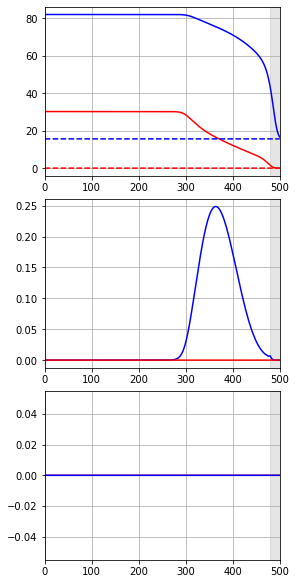

-------  13 0.4000000000000001 0.4500000000000002
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  1972.9073813296825
RUN  0 , total integrated cost =  1972.9073813296825
Gradient descend method:  None
RUN  1 , total integrated cost =  1969.4214516430861
RUN  2 , total integrated cost =  1966.824842716181
RUN  3 , total integrated cost =  1962.994692911039
RUN  4 , total integrated cost =  1960.39912585241
RUN  5 , total integrated cost =  1956.8009649989076
RUN  6 , total integrated cost =  1954.1342298151933
RUN  7 , total integrated cost =  1950.7472837503726
RUN  8 , total integrated cost =  1948.0494020761519
RUN  9 , total integrated cost =  1944.8442390320788
RUN  10 , total integrated cost =  1942.5692233940158
RUN  11 , total integrated cost =  1939.7706401200471
RUN  12 , total integrated cost =  1937.6523542211592
RUN  13 , total integrated cost =  1934.7262109881287
RUN  14 , total integrated cost =  1932.4439018703

RUN  1 , total integrated cost =  11903.559573536522
RUN  2 , total integrated cost =  11903.532172050693
RUN  3 , total integrated cost =  11903.48040481995
RUN  4 , total integrated cost =  11903.48040481995
Control only changes marginally.
RUN  4 , total integrated cost =  11903.48040481995
Improved over  4  iterations in  6.027812934946269  seconds by  0.0011284856520745734  percent.
cost splitting :  11.30334551593963 [0.         0.16850034 0.         0.        ]
--------------- k  11
set cost params:  1.0 0.0 76652.5313950174
interpolate adjoint :  True True True
initial cost =  12927.280728911652
RUN  0 , total integrated cost =  12927.280728911652
Gradient descend method:  None
RUN  1 , total integrated cost =  12927.223706782393
RUN  2 , total integrated cost =  12927.223706782393
Control only changes marginally.
RUN  2 , total integrated cost =  12927.223706782393
Improved over  2  iterations in  3.7418525139801204  seconds by  0.0004410991797385577  percent.
cost splitting :

RUN  1 , total integrated cost =  45658.030510913406
RUN  2 , total integrated cost =  45658.030510913406
Control only changes marginally.
RUN  2 , total integrated cost =  45658.030510913406
Improved over  2  iterations in  3.681168442009948  seconds by  0.000731559250510827  percent.
cost splitting :  39.79526057725002 [0.         0.16794252 0.         0.        ]
--------------- k  44
set cost params:  1.0 0.0 277736.8180559583
interpolate adjoint :  True True True
initial cost =  46683.61578807973
RUN  0 , total integrated cost =  46683.61578807973
Gradient descend method:  None
RUN  1 , total integrated cost =  46682.78148454432
RUN  2 , total integrated cost =  46682.033350011014
RUN  3 , total integrated cost =  46681.91644699119
RUN  4 , total integrated cost =  46681.91644699119
Control only changes marginally.
RUN  4 , total integrated cost =  46681.91644699119
Improved over  4  iterations in  6.840650152997114  seconds by  0.003640123113541449  percent.
cost splitting :  36.

RUN  1 , total integrated cost =  100866.05857545667
Control only changes marginally.
RUN  1 , total integrated cost =  100866.05857545667
Improved over  1  iterations in  1.857281431904994  seconds by  0.0  percent.
cost splitting :  63.95882425780385 [0.        0.1673715 0.        0.       ]
--------------- k  108
set cost params:  1.0 0.0 620586.212706347
interpolate adjoint :  True True True
initial cost =  103932.40255255786
RUN  0 , total integrated cost =  103932.40255255786
Gradient descend method:  None
RUN  1 , total integrated cost =  103932.17251502704
RUN  2 , total integrated cost =  103932.17251502704
Control only changes marginally.
RUN  2 , total integrated cost =  103932.17251502704
Improved over  2  iterations in  3.680193146923557  seconds by  0.00022133379502520256  percent.
cost splitting :  69.5509021636246 [0.         0.16736212 0.         0.        ]
--------------- k  109
set cost params:  1.0 0.0 620587.587196205
interpolate adjoint :  True True True
initial 

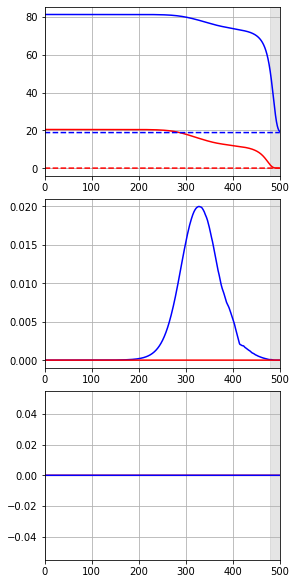

-------  14 0.4250000000000001 0.4500000000000002
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  23328.688435831347
RUN  0 , total integrated cost =  23328.688435831347
Gradient descend method:  None
RUN  1 , total integrated cost =  23323.147451576373
RUN  2 , total integrated cost =  23309.244631527446
RUN  3 , total integrated cost =  23302.46268217936
RUN  4 , total integrated cost =  23286.42896034394
RUN  5 , total integrated cost =  23278.910447193997
RUN  6 , total integrated cost =  23269.258848129866
RUN  7 , total integrated cost =  23264.329364456076
RUN  8 , total integrated cost =  23252.939085890666
RUN  9 , total integrated cost =  23246.92103034241
RUN  10 , total integrated cost =  23236.42458929697
RUN  11 , total integrated cost =  23231.036187694397
RUN  12 , total integrated cost =  23222.561840616956
RUN  13 , total integrated cost =  23218.05375254204
RUN  14 , total integrated cost =  23208.7193900302

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  20085.001844648414
RUN  100 , total integrated cost =  20085.001844648414
Improved over  100  iterations in  116.99542698496953  seconds by  13.904281846384649  percent.
Problem in initial value trasfer post:  sigmae_f 1.5333038882771874 1.533304084922176
Problem in initial value trasfer post:  tau_exc 20.705615851373313 20.705614455359626
cost splitting :  8.477549033719521 [0.00000000e+00 2.02793175e+00 3.43505715e-10 0.00000000e+00]
--------------- k  1
set cost params:  1.0 0.0 10880.156742674137
interpolate adjoint :  True True True
initial cost =  22072.692820184562
RUN  0 , total integrated cost =  22072.692820184562
Gradient descend method:  None
RUN  1 , total integrated cost =  22072.570925454504
RUN  2 , total integrated cost =  22072.406687812305
RUN  3 , total integrated cost =  22072.28005283685
RUN  4 , total integrated cost =  22072.091119528708
RUN  5 , total integrated cost =  22071.947807771074
RUN  6 , total integrated cost =  220

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  22043.616362990895
RUN  100 , total integrated cost =  22043.616362990895
Improved over  100  iterations in  129.4729013190372  seconds by  0.1317304482535917  percent.
Problem in initial value trasfer post:  sigmae_f 1.5330225435691467 1.5330227589890346
Problem in initial value trasfer post:  tau_exc 20.68796379208778 20.68796225284902
cost splitting :  10.781434830750593 [0.00000000e+00 2.02504757e+00 3.43505715e-10 0.00000000e+00]
--------------- k  2
set cost params:  1.0 0.0 11863.364717062173
interpolate adjoint :  True True True
initial cost =  24034.65927828055
RUN  0 , total integrated cost =  24034.65927828055
Gradient descend method:  None
RUN  1 , total integrated cost =  24034.354470816674
RUN  2 , total integrated cost =  24034.071668079738
RUN  3 , total integrated cost =  24033.849630572266
RUN  4 , total integrated cost =  24033.533127767674
RUN  5 , total integrated cost =  24033.24829728483
RUN  6 , total integrated cost =  24032.

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  23958.956813508645
Control only changes marginally.
RUN  200 , total integrated cost =  23958.956813508645
Improved over  200  iterations in  255.37675124499947  seconds by  0.31497207385133663  percent.
Problem in initial value trasfer post:  sigmae_f 1.533230188008177 1.533230503084321
Problem in initial value trasfer post:  tau_exc 20.704761892572023 20.704759654778584
cost splitting :  9.23686582907117 [0.00000000e+00 2.01879657e+00 3.43505715e-10 0.00000000e+00]
--------------- k  3
set cost params:  1.0 0.0 12855.10870066455
interpolate adjoint :  True True True
initial cost =  25961.086161594216
RUN  0 , total integrated cost =  25961.086161594216
Gradient descend method:  None
RUN  1 , total integrated cost =  25961.063188026343
RUN  2 , total integrated cost =  25961.06176763548
RUN  3 , total integrated cost =  25961.052563807876
RUN  4 , total integrated cost =  25961.048242422326
RUN  5 , total integrated cost =  25961.03956887932
RUN  6 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  25961.020133763766
Control only changes marginally.
RUN  9 , total integrated cost =  25961.020133763766
Improved over  9  iterations in  12.186159654986113  seconds by  0.0002543338519842564  percent.
Problem in initial value trasfer post:  sigmae_f 1.5331232888911577 1.5331236021979697
Problem in initial value trasfer post:  tau_exc 20.69763597433797 20.69763374331152
cost splitting :  10.10689817961217 [0.00000000e+00 2.01872375e+00 3.43505715e-10 0.00000000e+00]
--------------- k  4
set cost params:  1.0 0.0 13840.28410150656
interpolate adjoint :  True True True
initial cost =  27949.817112801462
RUN  0 , total integrated cost =  27949.817112801462
Gradient descend method:  None
RUN  1 , total integrated cost =  27949.801551782813
RUN  2 , total integrated cost =  27949.80086070811
RUN  3 , total integrated cost =  27949.793338252977
RUN  4 , total integrated cost =  27949.78837494324
RUN  5 , total integrated cost =  27949.787712704398
RUN  6 , t

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  27949.78170091533
Control only changes marginally.
RUN  7 , total integrated cost =  27949.78170091533
Improved over  7  iterations in  9.832979561993852  seconds by  0.0001266980960537012  percent.
Problem in initial value trasfer post:  sigmae_f 1.5330337786296615 1.533034090461822
Problem in initial value trasfer post:  tau_exc 20.691864006574512 20.691861781356042
cost splitting :  10.856594878111258 [0.00000000e+00 2.01866702e+00 3.43505715e-10 0.00000000e+00]
--------------- k  5
set cost params:  1.0 0.0 14825.488874569013
interpolate adjoint :  True True True
initial cost =  29938.58208729656
RUN  0 , total integrated cost =  29938.58208729656
Gradient descend method:  None
RUN  1 , total integrated cost =  29938.56538066314


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  29938.56538066314
Control only changes marginally.
RUN  2 , total integrated cost =  29938.56538066314
Improved over  2  iterations in  3.1189892949769273  seconds by  5.580302155294703e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5329609537646927 1.532961264509594
Problem in initial value trasfer post:  tau_exc 20.687276552491397 20.68727433130458
cost splitting :  11.480719396666967 [0.00000000e+00 2.01862380e+00 3.43505715e-10 0.00000000e+00]
--------------- k  6
set cost params:  1.0 0.0 15810.707381746925
interpolate adjoint :  True True True
initial cost =  31927.35090562055
RUN  0 , total integrated cost =  31927.35090562055
Gradient descend method:  None
RUN  1 , total integrated cost =  31927.325383158448
RUN  2 , total integrated cost =  31927.323628164155
RUN  3 , total integrated cost =  31927.31392720382
RUN  4 , total integrated cost =  31927.30936586165
RUN  5 , total integrated cost =  31927.305358565485
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  34 , total integrated cost =  31926.289719218857
Improved over  34  iterations in  41.334938191925175  seconds by  0.0033237533700543054  percent.
Problem in initial value trasfer post:  sigmae_f 1.5328769652460381 1.53287726434808
Problem in initial value trasfer post:  tau_exc 20.68204914013699 20.68204699807834
cost splitting :  12.216916833164717 [0.00000000e+00 2.01851012e+00 3.43505715e-10 0.00000000e+00]
--------------- k  7
set cost params:  1.0 0.0 16796.227146740493
interpolate adjoint :  True True True
initial cost =  33915.5713350753
RUN  0 , total integrated cost =  33915.5713350753
Gradient descend method:  None
RUN  1 , total integrated cost =  33915.55006858434
RUN  2 , total integrated cost =  33915.548302021445
RUN  3 , total integrated cost =  33915.52487766352
RUN  4 , total integrated cost =  33915.513761827955
RUN  5 , total integrated cost =  33915.510582157294
RUN  6 , total integrated cost =  33915.50410563567
RUN  7 , tota

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  23 , total integrated cost =  33888.72656692764
Improved over  23  iterations in  27.411062437924556  seconds by  0.07915174974480976  percent.
Problem in initial value trasfer post:  sigmae_f 1.5332453367386603 1.5332458129364754
Problem in initial value trasfer post:  tau_exc 20.703031501064682 20.70302811710882
cost splitting :  8.902021623523305 [0.00000000e+00 2.01710921e+00 3.43505715e-10 0.00000000e+00]
--------------- k  8
set cost params:  1.0 0.0 17787.557688254383
interpolate adjoint :  True True True
initial cost =  35888.34853675851
RUN  0 , total integrated cost =  35888.34853675851
Gradient descend method:  None
RUN  1 , total integrated cost =  35888.337902821426


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  35888.337902821426
Control only changes marginally.
RUN  2 , total integrated cost =  35888.337902821426
Improved over  2  iterations in  3.0686626649694517  seconds by  2.9630611379616312e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5331932684050158 1.5331937433579883
Problem in initial value trasfer post:  tau_exc 20.699549180304636 20.699545800900367
cost splitting :  9.31315076469312 [0.00000000e+00 2.01708550e+00 3.43505715e-10 0.00000000e+00]
--------------- k  9
set cost params:  1.0 0.0 18773.59883830912
interpolate adjoint :  True True True
initial cost =  37877.26721225223
RUN  0 , total integrated cost =  37877.26721225223
Gradient descend method:  None
RUN  1 , total integrated cost =  37877.252674623356


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  37877.252674623356
Control only changes marginally.
RUN  2 , total integrated cost =  37877.252674623356
Improved over  2  iterations in  3.125147512066178  seconds by  3.8380881036914616e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5331325276213943 1.5331330011400641
Problem in initial value trasfer post:  tau_exc 20.69556700437628 20.695563630270534
cost splitting :  9.80158150688153 [0.00000000e+00 2.01705871e+00 3.43505715e-10 0.00000000e+00]
--------------- k  10
set cost params:  1.0 0.0 19759.674157260808
interpolate adjoint :  True True True
initial cost =  39866.22448744043
RUN  0 , total integrated cost =  39866.22448744043
Gradient descend method:  None
RUN  1 , total integrated cost =  39866.20901193551


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  39866.20901193551
Control only changes marginally.
RUN  2 , total integrated cost =  39866.20901193551
Improved over  2  iterations in  3.175405081943609  seconds by  3.88185867024049e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5330661284809657 1.5330666004335178
Problem in initial value trasfer post:  tau_exc 20.691303405075207 20.691300036880364
cost splitting :  10.34613719169117 [0.00000000e+00 2.01703037e+00 3.43505715e-10 0.00000000e+00]
--------------- k  11
set cost params:  1.0 0.0 20745.77957388323
interpolate adjoint :  True True True
initial cost =  41855.213585196834
RUN  0 , total integrated cost =  41855.213585196834
Gradient descend method:  None
RUN  1 , total integrated cost =  41855.19937878451


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  41855.19937878451
Control only changes marginally.
RUN  2 , total integrated cost =  41855.19937878451
Improved over  2  iterations in  3.309812107938342  seconds by  3.3941798648129407e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5330079151626792 1.5330083857328418
Problem in initial value trasfer post:  tau_exc 20.687632043544998 20.687628680700062
cost splitting :  10.832345156588596 [0.00000000e+00 2.01700625e+00 3.43505715e-10 0.00000000e+00]
--------------- k  12
set cost params:  1.0 0.0 21731.886311188166
interpolate adjoint :  True True True
initial cost =  43844.182829763966
RUN  0 , total integrated cost =  43844.182829763966
Gradient descend method:  None
RUN  1 , total integrated cost =  43844.16716431637


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  43844.16716431637
Control only changes marginally.
RUN  2 , total integrated cost =  43844.16716431637
Improved over  2  iterations in  3.246735734050162  seconds by  3.5729819970242715e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5329356811653674 1.5329361500244505
Problem in initial value trasfer post:  tau_exc 20.683162462875355 20.683159106768272
cost splitting :  11.447144900186634 [0.00000000e+00 2.01697724e+00 3.43505715e-10 0.00000000e+00]
--------------- k  13
set cost params:  1.0 0.0 22718.040088119116
interpolate adjoint :  True True True
initial cost =  45833.21688514297
RUN  0 , total integrated cost =  45833.21688514297
Gradient descend method:  None
RUN  1 , total integrated cost =  45833.20452797717


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  45833.20452797717
Control only changes marginally.
RUN  2 , total integrated cost =  45833.20452797717
Improved over  2  iterations in  3.237064606975764  seconds by  2.6961157502114474e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5328696606862569 1.5328701279513095
Problem in initial value trasfer post:  tau_exc 20.679148511713613 20.679145162092365
cost splitting :  12.019832278055675 [0.00000000e+00 2.01695148e+00 3.43505715e-10 0.00000000e+00]
--------------- k  14
set cost params:  1.0 0.0 23704.197366982706
interpolate adjoint :  True True True
initial cost =  47822.23591618429
RUN  0 , total integrated cost =  47822.23591618429
Gradient descend method:  None
RUN  1 , total integrated cost =  47822.22527853672


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  47822.22527853672
Control only changes marginally.
RUN  2 , total integrated cost =  47822.22527853672
Improved over  2  iterations in  3.168397934990935  seconds by  2.224414514273576e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5328046032601532 1.5328050689428552
Problem in initial value trasfer post:  tau_exc 20.67525492984755 20.675251586799618
cost splitting :  12.594273502728464 [0.00000000e+00 2.01692680e+00 3.43505715e-10 0.00000000e+00]
--------------- k  15
set cost params:  1.0 0.0 24690.367913900067
interpolate adjoint :  True True True
initial cost =  49811.25908660923
RUN  0 , total integrated cost =  49811.25908660923
Gradient descend method:  None
RUN  1 , total integrated cost =  49811.24963278218
RUN  2 , total integrated cost =  49811.247167873014
RUN  3 , total integrated cost =  49811.12524531295
RUN  4 , total integrated cost =  49811.03680810423
RUN  5 , total integrated cost =  49811.03122219295
RUN  6 , tota

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  12 , total integrated cost =  49810.94250507326
Control only changes marginally.
RUN  12 , total integrated cost =  49810.94250507326
Improved over  12  iterations in  14.515196216991171  seconds by  0.0006355622037546027  percent.
Problem in initial value trasfer post:  sigmae_f 1.5327387800445222 1.5327392307570171
Problem in initial value trasfer post:  tau_exc 20.67138386293902 20.671380622759436
cost splitting :  13.19362769054056 [0.00000000e+00 2.01688971e+00 3.43505715e-10 0.00000000e+00]
--------------- k  16
set cost params:  1.0 0.0 25676.66420637949
interpolate adjoint :  True True True
initial cost =  51800.193344220665
RUN  0 , total integrated cost =  51800.193344220665
Gradient descend method:  None
RUN  1 , total integrated cost =  51800.18613159149


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  51800.18613159149
Control only changes marginally.
RUN  2 , total integrated cost =  51800.18613159149
Improved over  2  iterations in  3.2077437869738787  seconds by  1.392394257493379e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.53269513486724 1.5326955845413313
Problem in initial value trasfer post:  tau_exc 20.668838310518286 20.668835074782404
cost splitting :  13.591984682648206 [0.00000000e+00 2.01687391e+00 3.43505715e-10 0.00000000e+00]
--------------- k  17
set cost params:  1.0 0.0 26662.81660080257
interpolate adjoint :  True True True
initial cost =  53789.13116769559
RUN  0 , total integrated cost =  53789.13116769559
Gradient descend method:  None
RUN  1 , total integrated cost =  53789.12130583936


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  53789.12130583936
Control only changes marginally.
RUN  2 , total integrated cost =  53789.12130583936
Improved over  2  iterations in  3.202511302079074  seconds by  1.833429172393153e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5326448777937514 1.5326453262660011
Problem in initial value trasfer post:  tau_exc 20.665933773315615 20.665930542785375
cost splitting :  14.058165897572747 [0.00000000e+00 2.01685606e+00 3.43505715e-10 0.00000000e+00]
--------------- k  18
set cost params:  1.0 0.0 27648.995927222113
interpolate adjoint :  True True True
initial cost =  55778.10305294856
RUN  0 , total integrated cost =  55778.10305294856
Gradient descend method:  None
RUN  1 , total integrated cost =  55778.092611092354


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  55778.092611092354
Control only changes marginally.
RUN  2 , total integrated cost =  55778.092611092354
Improved over  2  iterations in  3.247358046937734  seconds by  1.8720350155376764e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5325886395441424 1.5325890866829581
Problem in initial value trasfer post:  tau_exc 20.662710493168124 20.662707268429756
cost splitting :  14.590628910970597 [0.00000000e+00 2.01683642e+00 3.43505715e-10 0.00000000e+00]
--------------- k  19
set cost params:  1.0 0.0 28635.20180949868
interpolate adjoint :  True True True
initial cost =  57767.10855278964
RUN  0 , total integrated cost =  57767.10855278964
Gradient descend method:  None
RUN  1 , total integrated cost =  57767.099165151296


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  57767.099165151296
Control only changes marginally.
RUN  2 , total integrated cost =  57767.099165151296
Improved over  2  iterations in  3.3751678069820628  seconds by  1.6250836480935504e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.532533920030703 1.5325343658523614
Problem in initial value trasfer post:  tau_exc 20.659602164378242 20.659598945467934
cost splitting :  15.118306568629679 [0.00000000e+00 2.01681766e+00 3.43505715e-10 0.00000000e+00]
--------------- k  20
set cost params:  1.0 0.0 29621.414546076005
interpolate adjoint :  True True True
initial cost =  59756.11043401588
RUN  0 , total integrated cost =  59756.11043401588
Gradient descend method:  None
RUN  1 , total integrated cost =  59756.102005890476


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59756.102005890476
Control only changes marginally.
RUN  2 , total integrated cost =  59756.102005890476
Improved over  2  iterations in  3.3993065000977367  seconds by  1.4104206812248776e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5324858140692115 1.5324862587099615
Problem in initial value trasfer post:  tau_exc 20.656894004980902 20.656890791402837
cost splitting :  15.589666161708763 [0.00000000e+00 2.01680147e+00 3.43505715e-10 0.00000000e+00]
--------------- k  21
set cost params:  1.0 0.0 30607.61919564641
interpolate adjoint :  True True True
initial cost =  61745.08099085807
RUN  0 , total integrated cost =  61745.08099085807
Gradient descend method:  None
RUN  1 , total integrated cost =  61745.07105842664


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  61745.07105842664
Control only changes marginally.
RUN  2 , total integrated cost =  61745.07105842664
Improved over  2  iterations in  3.311419897014275  seconds by  1.6086190626651842e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5324333878858927 1.5324338312423593
Problem in initial value trasfer post:  tau_exc 20.653958413003046 20.653955205251666
cost splitting :  16.112809735075317 [0.00000000e+00 2.01678405e+00 3.43505715e-10 0.00000000e+00]
--------------- k  22
set cost params:  1.0 0.0 31593.845383375432
interpolate adjoint :  True True True
initial cost =  63734.07630502715
RUN  0 , total integrated cost =  63734.07630502715
Gradient descend method:  None
RUN  1 , total integrated cost =  63734.06658689319
RUN  2 , total integrated cost =  63734.06480348065
RUN  3 , total integrated cost =  63732.991287501725
RUN  4 , total integrated cost =  63732.13347083673
RUN  5 , total integrated cost =  63731.26317590173
RUN  6 , to

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  9 , total integrated cost =  63730.586016097805
Control only changes marginally.
RUN  9 , total integrated cost =  63730.586016097805
Improved over  9  iterations in  12.911264471011236  seconds by  0.005476330923258388  percent.
Problem in initial value trasfer post:  sigmae_f 1.5323941618170314 1.532394463933216
Problem in initial value trasfer post:  tau_exc 20.651884702109395 20.651882514578034
cost splitting :  16.604618904768948 [0.00000000e+00 2.01665801e+00 3.43505715e-10 0.00000000e+00]
--------------- k  23
set cost params:  1.0 0.0 32581.432971561917
interpolate adjoint :  True True True
initial cost =  65722.21243758184
RUN  0 , total integrated cost =  65722.21243758184
Gradient descend method:  None
RUN  1 , total integrated cost =  65722.20451039144


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  65722.20451039144
Control only changes marginally.
RUN  2 , total integrated cost =  65722.20451039144
Improved over  2  iterations in  3.3000899739563465  seconds by  1.2061660896733883e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5323402629062643 1.5323405641376495
Problem in initial value trasfer post:  tau_exc 20.648902123712087 20.648899940197794
cost splitting :  17.160869828424264 [0.00000000e+00 2.01664069e+00 3.43505715e-10 0.00000000e+00]
--------------- k  24
set cost params:  1.0 0.0 33567.739655800666
interpolate adjoint :  True True True
initial cost =  67711.23070784107
RUN  0 , total integrated cost =  67711.23070784107
Gradient descend method:  None
RUN  1 , total integrated cost =  67711.22371233298


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67711.22371233298
Control only changes marginally.
RUN  2 , total integrated cost =  67711.22371233298
Improved over  2  iterations in  3.3006798409624025  seconds by  1.0331385226436396e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.53229582069943 1.53229612118875
Problem in initial value trasfer post:  tau_exc 20.646451970100024 20.64644979000528
cost splitting :  17.62745382135572 [0.00000000e+00 2.01662659e+00 3.43505715e-10 0.00000000e+00]
--------------- k  25
set cost params:  1.0 0.0 34554.02742444159
interpolate adjoint :  True True True
initial cost =  69700.19784909915
RUN  0 , total integrated cost =  69700.19784909915
Gradient descend method:  None
RUN  1 , total integrated cost =  69700.18929902832


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  69700.18929902832
Control only changes marginally.
RUN  2 , total integrated cost =  69700.18929902832
Improved over  2  iterations in  3.3421267359517515  seconds by  1.2266924755977016e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5322417368707004 1.5322420364629603
Problem in initial value trasfer post:  tau_exc 20.643484555428003 20.64348237947372
cost splitting :  18.204542969330884 [0.00000000e+00 2.01660964e+00 3.43505715e-10 0.00000000e+00]
--------------- k  26
set cost params:  1.0 0.0 35540.35124266292
interpolate adjoint :  True True True
initial cost =  71689.21941761939
RUN  0 , total integrated cost =  71689.21941761939
Gradient descend method:  None
RUN  1 , total integrated cost =  71689.21223818771


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  71689.21223818771
Control only changes marginally.
RUN  2 , total integrated cost =  71689.21223818771
Improved over  2  iterations in  3.297598446952179  seconds by  1.001466013406116e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.532196585295644 1.5321968841296507
Problem in initial value trasfer post:  tau_exc 20.641024488703938 20.641022316296777
cost splitting :  18.69182147281176 [0.00000000e+00 2.01659573e+00 3.43505715e-10 0.00000000e+00]
--------------- k  27
set cost params:  1.0 0.0 36526.65549552611
interpolate adjoint :  True True True
initial cost =  73678.18917905341
RUN  0 , total integrated cost =  73678.18917905341
Gradient descend method:  None
RUN  1 , total integrated cost =  73678.18054314128


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  73678.18054314128
Control only changes marginally.
RUN  2 , total integrated cost =  73678.18054314128
Improved over  2  iterations in  3.205023864051327  seconds by  1.172112429514982e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5321412462354655 1.5321415441361965
Problem in initial value trasfer post:  tau_exc 20.638034696942167 20.638032528941892
cost splitting :  19.29682859063219 [0.00000000e+00 2.01657893e+00 3.43505715e-10 0.00000000e+00]
--------------- k  28
set cost params:  1.0 0.0 37512.99704887834
interpolate adjoint :  True True True
initial cost =  75667.21613360479
RUN  0 , total integrated cost =  75667.21613360479
Gradient descend method:  None
RUN  1 , total integrated cost =  75667.21013656611


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  75667.21013656611
Control only changes marginally.
RUN  2 , total integrated cost =  75667.21013656611
Improved over  2  iterations in  3.276112755993381  seconds by  7.92554422446301e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5320908811032186 1.5320911781500381
Problem in initial value trasfer post:  tau_exc 20.635266743331442 20.635264578697033
cost splitting :  19.85233685705785 [0.00000000e+00 2.01656396e+00 3.43505715e-10 0.00000000e+00]
--------------- k  29
set cost params:  1.0 0.0 38499.32922053346
interpolate adjoint :  True True True
initial cost =  77656.21204439393
RUN  0 , total integrated cost =  77656.21204439393
Gradient descend method:  None
RUN  1 , total integrated cost =  77656.20462920495


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  77656.20462920495
Control only changes marginally.
RUN  2 , total integrated cost =  77656.20462920495
Improved over  2  iterations in  3.2643881330732256  seconds by  9.548738972853243e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5320453299414274 1.5320456261997737
Problem in initial value trasfer post:  tau_exc 20.63273967087989 20.63273750910977
cost splitting :  20.36111778132483 [0.00000000e+00 2.01655055e+00 3.43505715e-10 0.00000000e+00]
--------------- k  30
set cost params:  1.0 0.0 39485.653755654705
interpolate adjoint :  True True True
initial cost =  79645.17791290856
RUN  0 , total integrated cost =  79645.17791290856
Gradient descend method:  None
RUN  1 , total integrated cost =  79645.1710099865


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  79645.1710099865
Control only changes marginally.
RUN  2 , total integrated cost =  79645.1710099865
Improved over  2  iterations in  3.280393449938856  seconds by  8.667093538861081e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5319909497247877 1.5319912450332267
Problem in initial value trasfer post:  tau_exc 20.629752378438013 20.62975022019891
cost splitting :  20.974711782199684 [0.00000000e+00 2.01653484e+00 3.43505715e-10 0.00000000e+00]
--------------- k  31
set cost params:  1.0 0.0 40472.01004393202
interpolate adjoint :  True True True
initial cost =  81634.19282544812
RUN  0 , total integrated cost =  81634.19282544812
Gradient descend method:  None
RUN  1 , total integrated cost =  81634.18584319054


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  81634.18584319054
Control only changes marginally.
RUN  2 , total integrated cost =  81634.18584319054
Improved over  2  iterations in  3.2576458599651232  seconds by  8.553104208885998e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5319521544758232 1.5319524491057124
Problem in initial value trasfer post:  tau_exc 20.627632825954066 20.627630670264697
cost splitting :  21.415976569833358 [0.00000000e+00 2.01652376e+00 3.43505715e-10 0.00000000e+00]
--------------- k  32
set cost params:  1.0 0.0 41458.32462143427
interpolate adjoint :  True True True
initial cost =  83623.11262351125
RUN  0 , total integrated cost =  83623.11262351125
Gradient descend method:  None
RUN  1 , total integrated cost =  83623.10470312033


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  83623.10470312033
Control only changes marginally.
RUN  2 , total integrated cost =  83623.10470312033
Improved over  2  iterations in  3.2784340700600296  seconds by  9.471533246596664e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.531893014515018 1.5318933081135886
Problem in initial value trasfer post:  tau_exc 20.624422664552363 20.624420512768335
cost splitting :  22.097446883165762 [0.00000000e+00 2.01650713e+00 3.43505715e-10 0.00000000e+00]
--------------- k  33
set cost params:  1.0 0.0 42444.70605271617
interpolate adjoint :  True True True
initial cost =  85612.1498936098
RUN  0 , total integrated cost =  85612.1498936098
Gradient descend method:  None
RUN  1 , total integrated cost =  85612.14372384163


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  85612.14372384163
Control only changes marginally.
RUN  2 , total integrated cost =  85612.14372384163
Improved over  2  iterations in  3.2511738570174202  seconds by  7.206650209923282e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5318578539846817 1.5318581469677548
Problem in initial value trasfer post:  tau_exc 20.62252895058907 20.62252680117033
cost splitting :  22.50453390097732 [0.00000000e+00 2.01649739e+00 3.43505715e-10 0.00000000e+00]
--------------- k  34
set cost params:  1.0 0.0 43431.01877903509
interpolate adjoint :  True True True
initial cost =  87601.04076719107
RUN  0 , total integrated cost =  87601.04076719107
Gradient descend method:  None
RUN  1 , total integrated cost =  87601.03156512733


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  87601.03156512733
Control only changes marginally.
RUN  2 , total integrated cost =  87601.03156512733
Improved over  2  iterations in  3.218649828922935  seconds by  1.050451416517717e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5317996541238945 1.5317999460815737
Problem in initial value trasfer post:  tau_exc 20.619402852741 20.61940070731295
cost splitting :  23.188706338401147 [0.00000000e+00 2.01648143e+00 3.43505715e-10 0.00000000e+00]
--------------- k  35
set cost params:  1.0 0.0 44417.40717639685
interpolate adjoint :  True True True
initial cost =  89590.0654512857
RUN  0 , total integrated cost =  89590.0654512857
Gradient descend method:  None
RUN  1 , total integrated cost =  89590.05993219417


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  89590.05993219417
Control only changes marginally.
RUN  2 , total integrated cost =  89590.05993219417
Improved over  2  iterations in  3.335862515028566  seconds by  6.1603834211609865e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5317709773849002 1.5317712688093608
Problem in initial value trasfer post:  tau_exc 20.617874633855156 20.6178724906198
cost splitting :  23.52863756574545 [0.00000000e+00 2.01647365e+00 3.43505715e-10 0.00000000e+00]
--------------- k  36
set cost params:  1.0 0.0 45403.70880266854
interpolate adjoint :  True True True
initial cost =  91578.9111752345
RUN  0 , total integrated cost =  91578.9111752345
Gradient descend method:  None
RUN  1 , total integrated cost =  91578.90126969438


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  91578.90126969438
Control only changes marginally.
RUN  2 , total integrated cost =  91578.90126969438
Improved over  2  iterations in  3.457737794960849  seconds by  1.0816398670954186e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5317058279319073 1.5317061181084424
Problem in initial value trasfer post:  tau_exc 20.61440852729872 20.614406389341944
cost splitting :  24.313960429442208 [0.00000000e+00 2.01645614e+00 3.43505715e-10 0.00000000e+00]
--------------- k  37
set cost params:  1.0 0.0 46390.12759882679
interpolate adjoint :  True True True
initial cost =  93567.97150598007
RUN  0 , total integrated cost =  93567.97150598007
Gradient descend method:  None
RUN  1 , total integrated cost =  93567.94770690585
RUN  2 , total integrated cost =  93567.92524577744


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  93567.92524577744
Control only changes marginally.
RUN  3 , total integrated cost =  93567.92524577744
Improved over  3  iterations in  4.862158153904602  seconds by  4.9440211085993724e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.531696357221493 1.5316966460286592
Problem in initial value trasfer post:  tau_exc 20.613909615920253 20.61390748749328
cost splitting :  24.42976943266246 [0.00000000e+00 2.01645264e+00 3.43505715e-10 0.00000000e+00]
--------------- k  38
set cost params:  1.0 0.0 47376.39688716698
interpolate adjoint :  True True True
initial cost =  95556.69056046137
RUN  0 , total integrated cost =  95556.69056046137
Gradient descend method:  None
RUN  1 , total integrated cost =  95556.68350353888


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  95556.68350353888
Control only changes marginally.
RUN  2 , total integrated cost =  95556.68350353888
Improved over  2  iterations in  3.196157332044095  seconds by  7.385063724996144e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5316480057653383 1.5316482937627396
Problem in initial value trasfer post:  tau_exc 20.611357623114497 20.611355497801966
cost splitting :  25.02239428869311 [0.00000000e+00 2.01643999e+00 3.43505715e-10 0.00000000e+00]
--------------- k  39
set cost params:  1.0 0.0 48362.768916645175
interpolate adjoint :  True True True
initial cost =  97545.64350554526
RUN  0 , total integrated cost =  97545.64350554526
Gradient descend method:  None
RUN  1 , total integrated cost =  97545.63444093747


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  97545.63444093747
Control only changes marginally.
RUN  2 , total integrated cost =  97545.63444093747
Improved over  2  iterations in  2.690459567005746  seconds by  9.292683373018917e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.531597539957213 1.5315978270672148
Problem in initial value trasfer post:  tau_exc 20.60870155439729 20.608699432670907
cost splitting :  25.648611082463614 [0.00000000e+00 2.01642685e+00 3.43505715e-10 0.00000000e+00]
--------------- k  40
set cost params:  1.0 0.0 49349.15231990503
interpolate adjoint :  True True True
initial cost =  99534.60442060293
RUN  0 , total integrated cost =  99534.60442060293
Gradient descend method:  None
RUN  1 , total integrated cost =  99534.59912045457


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  99534.59912045457
Control only changes marginally.
RUN  2 , total integrated cost =  99534.59912045457
Improved over  2  iterations in  2.5833954429253936  seconds by  5.324930356209734e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5315553175831287 1.531555603893147
Problem in initial value trasfer post:  tau_exc 20.606487928199382 20.60648580992072
cost splitting :  26.180267606437415 [0.00000000e+00 2.01641597e+00 3.43505715e-10 0.00000000e+00]
--------------- k  41
set cost params:  1.0 0.0 50335.51312143123
interpolate adjoint :  True True True
initial cost =  101523.51279301447
RUN  0 , total integrated cost =  101523.51279301447
Gradient descend method:  None
RUN  1 , total integrated cost =  101523.49508705294


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  101523.49508705294
Control only changes marginally.
RUN  2 , total integrated cost =  101523.49508705294
Improved over  2  iterations in  2.284585713990964  seconds by  1.7440256968370704e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5314937784626939 1.531494063344704
Problem in initial value trasfer post:  tau_exc 20.60327191384634 20.60326980256812
cost splitting :  26.96454622880422 [0.00000000e+00 2.01640004e+00 3.43505715e-10 0.00000000e+00]
--------------- k  42
set cost params:  1.0 0.0 51321.94194255288
interpolate adjoint :  True True True
initial cost =  103512.53019885943
RUN  0 , total integrated cost =  103512.53019885943
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  103512.53019885943
Control only changes marginally.
RUN  1 , total integrated cost =  103512.53019885943
Improved over  1  iterations in  1.3019203878939152  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5314937784626939 1.531494063344704
Problem in initial value trasfer post:  tau_exc 20.60327191384634 20.60326980256812
cost splitting :  26.96454622880422 [0.00000000e+00 2.01640004e+00 3.43505715e-10 0.00000000e+00]
--------------- k  53
set cost params:  1.0 0.0 62170.545784650065
interpolate adjoint :  True True True
initial cost =  125387.65539184982
RUN  0 , total integrated cost =  125387.65539184982
Gradient descend method:  None
RUN  1 , total integrated cost =  125387.08132692984


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  125387.08132692984
Control only changes marginally.
RUN  2 , total integrated cost =  125387.08132692984
Improved over  2  iterations in  3.00305513094645  seconds by  0.0004578320873775965  percent.
Problem in initial value trasfer post:  sigmae_f 1.5310553092159414 1.5310555870989488
Problem in initial value trasfer post:  tau_exc 20.58054524341444 20.580543159366922
cost splitting :  32.949406833684705 [0.00000000e+00 2.01629454e+00 3.43505715e-10 0.00000000e+00]
--------------- k  54
set cost params:  1.0 0.0 63158.245927420736
interpolate adjoint :  True True True
initial cost =  127378.5757304572
RUN  0 , total integrated cost =  127378.5757304572
Gradient descend method:  None
RUN  1 , total integrated cost =  127378.54394256718


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127378.54394256718
Control only changes marginally.
RUN  2 , total integrated cost =  127378.54394256718
Improved over  2  iterations in  3.213811775087379  seconds by  2.4955444700935914e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5309611856634366 1.5309614611140148
Problem in initial value trasfer post:  tau_exc 20.575660430641744 20.57565835957853
cost splitting :  34.33367752115736 [0.00000000e+00 2.01627212e+00 3.43505715e-10 0.00000000e+00]
--------------- k  55
set cost params:  1.0 0.0 64144.79588175726
interpolate adjoint :  True True True
initial cost =  129367.69710819455
RUN  0 , total integrated cost =  129367.69710819455
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  129367.69710819455
Control only changes marginally.
RUN  1 , total integrated cost =  129367.69710819455
Improved over  1  iterations in  1.6924403309822083  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5309611856634366 1.5309614611140148
Problem in initial value trasfer post:  tau_exc 20.575660430641744 20.57565835957853
cost splitting :  34.33367752115736 [0.00000000e+00 2.01627212e+00 3.43505715e-10 0.00000000e+00]
--------------- k  66
set cost params:  1.0 0.0 74993.75505810871
interpolate adjoint :  True True True
initial cost =  151242.1510013225
RUN  0 , total integrated cost =  151242.1510013225
Gradient descend method:  None
RUN  1 , total integrated cost =  151241.74218719997


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  151241.74218719997
Control only changes marginally.
RUN  2 , total integrated cost =  151241.74218719997
Improved over  2  iterations in  3.2878714280668646  seconds by  0.00027030435616381965  percent.
Problem in initial value trasfer post:  sigmae_f 1.5306086161946806 1.530608885780121
Problem in initial value trasfer post:  tau_exc 20.557353941440763 20.557351895161762
cost splitting :  39.81031947887738 [0.00000000e+00 2.01619364e+00 3.43505715e-10 0.00000000e+00]
--------------- k  67
set cost params:  1.0 0.0 75981.03445121895
interpolate adjoint :  True True True
initial cost =  153232.28861891004
RUN  0 , total integrated cost =  153232.28861891004
Gradient descend method:  None
RUN  1 , total integrated cost =  153232.27940893115


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  153232.27940893115
Control only changes marginally.
RUN  2 , total integrated cost =  153232.27940893115
Improved over  2  iterations in  2.9629730050219223  seconds by  6.010468794670487e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5305506729271163 1.5305509413879657
Problem in initial value trasfer post:  tau_exc 20.554358221998594 20.554356181102094
cost splitting :  40.75563194137125 [0.00000000e+00 2.01618108e+00 3.43505715e-10 0.00000000e+00]
--------------- k  68
set cost params:  1.0 0.0 76967.45955758526
interpolate adjoint :  True True True
initial cost =  155221.09104103854
RUN  0 , total integrated cost =  155221.09104103854
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  155221.09104103854
Control only changes marginally.
RUN  1 , total integrated cost =  155221.09104103854
Improved over  1  iterations in  1.6292300679488108  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5305506729271163 1.5305509413879657
Problem in initial value trasfer post:  tau_exc 20.554358221998594 20.554356181102094
cost splitting :  40.75563194137125 [0.00000000e+00 2.01618108e+00 3.43505715e-10 0.00000000e+00]
--------------- k  79
set cost params:  1.0 0.0 87816.60742719464
interpolate adjoint :  True True True
initial cost =  177094.93766383457
RUN  0 , total integrated cost =  177094.93766383457
Gradient descend method:  None
RUN  1 , total integrated cost =  177094.55618785342
RUN  2 , total integrated cost =  177094.54672296977
RUN  3 , total integrated cost =  177094.53136651526


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  177094.53136651526
Control only changes marginally.
RUN  4 , total integrated cost =  177094.53136651526
Improved over  4  iterations in  4.5544916089857  seconds by  0.00022942345199794545  percent.
Problem in initial value trasfer post:  sigmae_f 1.530207877251561 1.530208139512804
Problem in initial value trasfer post:  tau_exc 20.53664248297136 20.53664047096055
cost splitting :  46.63656150315724 [0.00000000e+00 2.01610948e+00 3.43505715e-10 0.00000000e+00]
--------------- k  80
set cost params:  1.0 0.0 88803.6432282381
interpolate adjoint :  True True True
initial cost =  179084.50360288075
RUN  0 , total integrated cost =  179084.50360288075
Gradient descend method:  None
RUN  1 , total integrated cost =  179084.50153677983
RUN  2 , total integrated cost =  179084.4883451175


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  179084.4883451175
Control only changes marginally.
RUN  3 , total integrated cost =  179084.4883451175
Improved over  3  iterations in  3.437882600002922  seconds by  8.519867961354066e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5301810697906935 1.53018133136661
Problem in initial value trasfer post:  tau_exc 20.535253761997843 20.535251753816866
cost splitting :  47.119002299686 [0.00000000e+00 2.01610388e+00 3.43505715e-10 0.00000000e+00]
--------------- k  81
set cost params:  1.0 0.0 89789.98931517219
interpolate adjoint :  True True True
initial cost =  181073.06451436758
RUN  0 , total integrated cost =  181073.06451436758
Gradient descend method:  None
RUN  1 , total integrated cost =  181073.05183366724
RUN  2 , total integrated cost =  181073.02363068747


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  181073.02363068747
Control only changes marginally.
RUN  3 , total integrated cost =  181073.02363068747
Improved over  3  iterations in  3.9717204130720347  seconds by  2.2578554251140304e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5301579874698699 1.5301582480445375
Problem in initial value trasfer post:  tau_exc 20.534050835703347 20.534048833977856
cost splitting :  47.540054131856806 [0.00000000e+00 2.01609873e+00 3.43505715e-10 0.00000000e+00]
--------------- k  82
set cost params:  1.0 0.0 90776.34131978602
interpolate adjoint :  True True True
initial cost =  183061.60665618686
RUN  0 , total integrated cost =  183061.60665618686
Gradient descend method:  None
RUN  1 , total integrated cost =  183061.59244523477
RUN  2 , total integrated cost =  183061.56782450693


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  183061.56782450693
Control only changes marginally.
RUN  3 , total integrated cost =  183061.56782450693
Improved over  3  iterations in  4.014741188031621  seconds by  2.1212356131172783e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5301201636636974 1.5301204230224952
Problem in initial value trasfer post:  tau_exc 20.532081281729106 20.532079287336586
cost splitting :  48.23302352558245 [0.00000000e+00 2.01609067e+00 3.43505715e-10 0.00000000e+00]
--------------- k  83
set cost params:  1.0 0.0 91762.71307246783
interpolate adjoint :  True True True
initial cost =  185050.1827123427
RUN  0 , total integrated cost =  185050.1827123427
Gradient descend method:  None
RUN  1 , total integrated cost =  185048.87221069427
RUN  2 , total integrated cost =  185047.7056583391


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  185047.7056583391
Control only changes marginally.
RUN  3 , total integrated cost =  185047.7056583391
Improved over  3  iterations in  4.839008178911172  seconds by  0.0013385850082983097  percent.
Problem in initial value trasfer post:  sigmae_f 1.5301123070137754 1.5301125273964962
Problem in initial value trasfer post:  tau_exc 20.531759244622975 20.53175754965634
cost splitting :  48.450833336158425 [0.00000000e+00 2.01606130e+00 3.43505715e-10 0.00000000e+00]
--------------- k  84
set cost params:  1.0 0.0 92750.24805969454
interpolate adjoint :  True True True
initial cost =  187038.63673081386
RUN  0 , total integrated cost =  187038.63673081386
Gradient descend method:  None
RUN  1 , total integrated cost =  187038.62439555998


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  187038.62439555998
Control only changes marginally.
RUN  2 , total integrated cost =  187038.62439555998
Improved over  2  iterations in  3.358198510017246  seconds by  6.595029816480746e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5300555374457154 1.5300557568321866
Problem in initial value trasfer post:  tau_exc 20.528692315351176 20.52869062568479
cost splitting :  49.50596454727857 [0.00000000e+00 2.01604979e+00 3.43505715e-10 0.00000000e+00]
--------------- k  85
set cost params:  1.0 0.0 93736.64231310764
interpolate adjoint :  True True True
initial cost =  189027.2443262843
RUN  0 , total integrated cost =  189027.2443262843
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  189027.2443262843
Control only changes marginally.
RUN  1 , total integrated cost =  189027.2443262843
Improved over  1  iterations in  1.6949482620693743  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5300555374457154 1.5300557568321866
Problem in initial value trasfer post:  tau_exc 20.528692315351176 20.52869062568479
cost splitting :  49.50596454727857 [0.00000000e+00 2.01604979e+00 3.43505715e-10 0.00000000e+00]
--------------- k  96
set cost params:  1.0 0.0 104586.09014186276
interpolate adjoint :  True True True
initial cost =  210900.27137906893
RUN  0 , total integrated cost =  210900.27137906893
Gradient descend method:  None
RUN  1 , total integrated cost =  210899.94107830554


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  210899.94107830554
Control only changes marginally.
RUN  2 , total integrated cost =  210899.94107830554
Improved over  2  iterations in  3.44782750797458  seconds by  0.00015661466969163484  percent.
Problem in initial value trasfer post:  sigmae_f 1.5297537021012197 1.5297539169635836
Problem in initial value trasfer post:  tau_exc 20.510292180530307 20.51029051669419
cost splitting :  55.41716173900611 [0.00000000e+00 2.01599011e+00 3.43505715e-10 0.00000000e+00]
--------------- k  97
set cost params:  1.0 0.0 105572.67579129603
interpolate adjoint :  True True True
initial cost =  212888.88799539098
RUN  0 , total integrated cost =  212888.88799539098
Gradient descend method:  None
RUN  1 , total integrated cost =  212888.6455907238
RUN  2 , total integrated cost =  212888.44920352392


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  212888.44920352392
Control only changes marginally.
RUN  3 , total integrated cost =  212888.44920352392
Improved over  3  iterations in  4.834768675966188  seconds by  0.00020611309081175477  percent.
Problem in initial value trasfer post:  sigmae_f 1.5297338860247518 1.5297340952496654
Problem in initial value trasfer post:  tau_exc 20.509072798017716 20.50907117725507
cost splitting :  55.838558456014454 [0.00000000e+00 2.01598197e+00 3.43505715e-10 0.00000000e+00]
--------------- k  98
set cost params:  1.0 0.0 106559.21705984522
interpolate adjoint :  True True True
initial cost =  214877.29861101173
RUN  0 , total integrated cost =  214877.29861101173
Gradient descend method:  None
RUN  1 , total integrated cost =  214875.01599460328
RUN  2 , total integrated cost =  214873.18772876693


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  214873.18772876693
Control only changes marginally.
RUN  3 , total integrated cost =  214873.18772876693
Improved over  3  iterations in  4.767737032962032  seconds by  0.0019131300846453314  percent.
Problem in initial value trasfer post:  sigmae_f 1.529701881037233 1.5297020370838301
Problem in initial value trasfer post:  tau_exc 20.50723890160071 20.507237692126736
cost splitting :  56.622723518070394 [0.00000000e+00 2.01593603e+00 3.43505715e-10 0.00000000e+00]
--------------- k  99
set cost params:  1.0 0.0 107547.59890332626
interpolate adjoint :  True True True
initial cost =  216865.70229849117
RUN  0 , total integrated cost =  216865.70229849117
Gradient descend method:  None
RUN  1 , total integrated cost =  216865.6961529824
RUN  2 , total integrated cost =  216865.68092607558


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  216865.68092607558
Control only changes marginally.
RUN  3 , total integrated cost =  216865.68092607558
Improved over  3  iterations in  4.808009593049064  seconds by  9.85513862872267e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5296768719159348 1.5296770275070157
Problem in initial value trasfer post:  tau_exc 20.50567621897551 20.505675012478832
cost splitting :  57.14611219594983 [0.00000000e+00 2.01593096e+00 3.43505715e-10 0.00000000e+00]
--------------- k  100
set cost params:  1.0 0.0 108533.95136626039
interpolate adjoint :  True True True
initial cost =  218854.09939826332
RUN  0 , total integrated cost =  218854.09939826332
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  218854.09939826332
Control only changes marginally.
RUN  1 , total integrated cost =  218854.09939826332
Improved over  1  iterations in  1.7410995960235596  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5296768719159348 1.5296770275070157
Problem in initial value trasfer post:  tau_exc 20.50567621897551 20.505675012478832
cost splitting :  57.14611219594983 [0.00000000e+00 2.01593096e+00 3.43505715e-10 0.00000000e+00]
--------------- k  111
set cost params:  1.0 0.0 108533.95136626039
interpolate adjoint :  True True True
initial cost =  218854.09939826332
RUN  0 , total integrated cost =  218854.09939826332
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  218854.09939826332
Control only changes marginally.
RUN  1 , total integrated cost =  218854.09939826332
Improved over  1  iterations in  1.7579887059982866  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5296768719159348 1.5296770275070157
Problem in initial value trasfer post:  tau_exc 20.50567621897551 20.505675012478832
cost splitting :  57.14611219594983 [0.00000000e+00 2.01593096e+00 3.43505715e-10 0.00000000e+00]


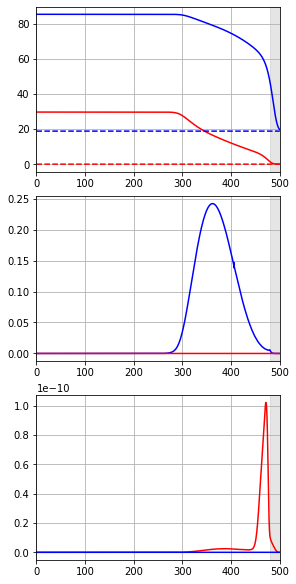

-------  19 0.4250000000000001 0.4750000000000002
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  20687.961026639616
RUN  0 , total integrated cost =  20687.961026639616
Gradient descend method:  None
RUN  1 , total integrated cost =  20685.884559316877
RUN  2 , total integrated cost =  20683.02519315943
RUN  3 , total integrated cost =  20680.92974150305
RUN  4 , total integrated cost =  20677.871357345597
RUN  5 , total integrated cost =  20675.821660085654
RUN  6 , total integrated cost =  20672.971356725902
RUN  7 , total integrated cost =  20670.88287353209
RUN  8 , total integrated cost =  20667.87075286956
RUN  9 , total integrated cost =  20665.83232076674
RUN  10 , total integrated cost =  20663.00480421929
RUN  11 , total integrated cost =  20660.922328779143
RUN  12 , total integrated cost =  20657.94689011382
RUN  13 , total integrated cost =  20655.913385401902
RUN  14 , total integrated cost =  20653.12401795898


ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  20452.689390491425
RUN  100 , total integrated cost =  20452.689390491425
Improved over  100  iterations in  98.70926090306602  seconds by  1.1372393627638502  percent.
Problem in initial value trasfer post:  tau_exc 20.957820830019518 20.95782079427188
cost splitting :  7.554997852866314 [0.00000000e+00 2.06516509e+00 5.08035516e-21 0.00000000e+00]
--------------- k  1
set cost params:  1.0 0.0 10825.446045391867
interpolate adjoint :  True True True
initial cost =  22363.888256266437
RUN  0 , total integrated cost =  22363.888256266437
Gradient descend method:  None
RUN  1 , total integrated cost =  22360.879453479905
RUN  2 , total integrated cost =  22355.947995548755
RUN  3 , total integrated cost =  22351.18016519155
RUN  4 , total integrated cost =  22341.728607320067
RUN  5 , total integrated cost =  22231.320209918977
RUN  6 , total integrated cost =  21728.65774681549
RUN  7 , total integrated cost =  21706.98519647833
RUN  8 , total integr

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  21619.14337207374
RUN  100 , total integrated cost =  21619.14337207374
Improved over  100  iterations in  117.53734400100075  seconds by  3.330122542460913  percent.
Problem in initial value trasfer post:  sigmae_f 1.524292136571628 1.524292149406715
Problem in initial value trasfer post:  tau_exc 20.97936711209073 20.979367027216632
cost splitting :  5.712717293968586 [0.00000000e+00 1.99653950e+00 5.08035516e-21 0.00000000e+00]
--------------- k  2
set cost params:  1.0 0.0 11821.335610986624
interpolate adjoint :  True True True
initial cost =  23607.47622926474
RUN  0 , total integrated cost =  23607.47622926474
Gradient descend method:  None
RUN  1 , total integrated cost =  23606.10905650253
RUN  2 , total integrated cost =  23605.17623439391
RUN  3 , total integrated cost =  23604.02649957699
RUN  4 , total integrated cost =  23603.092202274536
RUN  5 , total integrated cost =  23601.9589782985
RUN  6 , total integrated cost =  23601.04446530

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  200 , total integrated cost =  23254.81211119739
RUN  200 , total integrated cost =  23254.81211119739
Improved over  200  iterations in  239.8709466670407  seconds by  1.4938662423820404  percent.
Problem in initial value trasfer post:  sigmae_f 1.5238827213388857 1.5238827545544578
Problem in initial value trasfer post:  tau_exc 20.930230264318414 20.93023004209229
cost splitting :  11.46800525154948 [0.00000000e+00 1.96621980e+00 5.08035516e-21 0.00000000e+00]
--------------- k  3
set cost params:  1.0 0.0 12830.936799533043
interpolate adjoint :  True True True
initial cost =  25239.909955246992
RUN  0 , total integrated cost =  25239.909955246992
Gradient descend method:  None
RUN  1 , total integrated cost =  25239.860143183898
RUN  2 , total integrated cost =  25239.858088540463
RUN  3 , total integrated cost =  25239.846147844153
RUN  4 , total integrated cost =  25239.839700742148
RUN  5 , total integrated cost =  25239.795919795928
RUN  6 , total integrated cost =  25239

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  157 , total integrated cost =  25218.63618309704
Improved over  157  iterations in  172.9668801339576  seconds by  0.08428624423649467  percent.
Problem in initial value trasfer post:  sigmae_f 1.5239843410278555 1.5239843691610797
Problem in initial value trasfer post:  tau_exc 20.941451730274842 20.941451542553857
cost splitting :  9.889630628815453 [0.00000000e+00 1.96468480e+00 5.08035516e-21 0.00000000e+00]
--------------- k  4
set cost params:  1.0 0.0 13811.310483500989
interpolate adjoint :  True True True
initial cost =  27144.761462332845
RUN  0 , total integrated cost =  27144.761462332845
Gradient descend method:  None
RUN  1 , total integrated cost =  27144.739583039995
RUN  2 , total integrated cost =  27144.738564121955
RUN  3 , total integrated cost =  27144.722591783466
RUN  4 , total integrated cost =  27144.713296724552
RUN  5 , total integrated cost =  27144.710325804153
RUN  6 , total integrated cost =  27144.70476749201
RUN  7

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  26 , total integrated cost =  27140.851599799003
Improved over  26  iterations in  31.51865555800032  seconds by  0.014403746149199037  percent.
Problem in initial value trasfer post:  sigmae_f 1.5239637899349892 1.5239638167341079
Problem in initial value trasfer post:  tau_exc 20.93879377125512 20.938793592323716
cost splitting :  10.177630595012362 [0.00000000e+00 1.96438086e+00 5.08035516e-21 0.00000000e+00]
--------------- k  5
set cost params:  1.0 0.0 14789.963848278552
interpolate adjoint :  True True True
initial cost =  29063.299538418803
RUN  0 , total integrated cost =  29063.299538418803
Gradient descend method:  None
RUN  1 , total integrated cost =  29063.283245879116
RUN  2 , total integrated cost =  29063.281959195032
RUN  3 , total integrated cost =  29063.15942102115
RUN  4 , total integrated cost =  29063.065898389093
RUN  5 , total integrated cost =  29063.064562578824
RUN  6 , total integrated cost =  29063.05477230198
RUN  7 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  20 , total integrated cost =  29062.796458593806
Control only changes marginally.
RUN  20 , total integrated cost =  29062.796458593806
Improved over  20  iterations in  27.23736911395099  seconds by  0.0017309797338498356  percent.
Problem in initial value trasfer post:  sigmae_f 1.5239166450221966 1.5239166715548733
Problem in initial value trasfer post:  tau_exc 20.933323359974455 20.933323182591817
cost splitting :  10.885015969942339 [0.00000000e+00 1.96429902e+00 5.08035516e-21 0.00000000e+00]
--------------- k  6
set cost params:  1.0 0.0 15768.204251945412
interpolate adjoint :  True True True
initial cost =  30984.35312150844
RUN  0 , total integrated cost =  30984.35312150844
Gradient descend method:  None
RUN  1 , total integrated cost =  30984.339097206997
RUN  2 , total integrated cost =  30984.336927531975
RUN  3 , total integrated cost =  30984.331118875398


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  30984.331118875398
Control only changes marginally.
RUN  4 , total integrated cost =  30984.331118875398
Improved over  4  iterations in  6.005253797979094  seconds by  7.10120781235446e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.523872817629305 1.5238728440765807
Problem in initial value trasfer post:  tau_exc 20.928383092119383 20.9283829151001
cost splitting :  11.55603838294376 [0.00000000e+00 1.96425507e+00 5.08035516e-21 0.00000000e+00]
--------------- k  7
set cost params:  1.0 0.0 16746.383073461606
interpolate adjoint :  True True True
initial cost =  32905.72382429931
RUN  0 , total integrated cost =  32905.72382429931
Gradient descend method:  None
RUN  1 , total integrated cost =  32905.70591209468
RUN  2 , total integrated cost =  32905.705271617204
RUN  3 , total integrated cost =  32905.69968304067
RUN  4 , total integrated cost =  32905.696908914266
RUN  5 , total integrated cost =  32905.69074818146
RUN  6 , total 

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  32905.68188550635
Control only changes marginally.
RUN  7 , total integrated cost =  32905.68188550635
Improved over  7  iterations in  10.144205981050618  seconds by  0.0001274513613225281  percent.
Problem in initial value trasfer post:  sigmae_f 1.5238306576276686 1.5238306839818647
Problem in initial value trasfer post:  tau_exc 20.923740277591833 20.923740101000874
cost splitting :  12.212870622151318 [0.00000000e+00 1.96421334e+00 5.08035516e-21 0.00000000e+00]
--------------- k  8
set cost params:  1.0 0.0 17724.594089206108
interpolate adjoint :  True True True
initial cost =  34827.09701110451
RUN  0 , total integrated cost =  34827.09701110451
Gradient descend method:  None
RUN  1 , total integrated cost =  34827.0756267367


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  34827.0756267367
Control only changes marginally.
RUN  2 , total integrated cost =  34827.0756267367
Improved over  2  iterations in  3.1836690040072426  seconds by  6.140152250111441e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.523789353035794 1.5237893793127384
Problem in initial value trasfer post:  tau_exc 20.919288234972736 20.919288058713022
cost splitting :  12.867367298303122 [0.00000000e+00 1.96417521e+00 5.08035516e-21 0.00000000e+00]
--------------- k  9
set cost params:  1.0 0.0 18702.826553143816
interpolate adjoint :  True True True
initial cost =  36748.49557882523
RUN  0 , total integrated cost =  36748.49557882523
Gradient descend method:  None
RUN  1 , total integrated cost =  36748.47396241983


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  36748.47396241983
Control only changes marginally.
RUN  2 , total integrated cost =  36748.47396241983
Improved over  2  iterations in  3.186267368029803  seconds by  5.8822558742122055e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5237443545516591 1.5237443807440725
Problem in initial value trasfer post:  tau_exc 20.914534393493 20.91453421760165
cost splitting :  13.59786364088109 [0.00000000e+00 1.96413499e+00 5.08035516e-21 0.00000000e+00]
--------------- k  10
set cost params:  1.0 0.0 19681.101725255467
interpolate adjoint :  True True True
initial cost =  38669.938460629186
RUN  0 , total integrated cost =  38669.938460629186
Gradient descend method:  None
RUN  1 , total integrated cost =  38669.91986400543


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  38669.91986400543
Control only changes marginally.
RUN  2 , total integrated cost =  38669.91986400543
Improved over  2  iterations in  3.2621221829904243  seconds by  4.8090647396747954e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5237035919498223 1.52370361806508
Problem in initial value trasfer post:  tau_exc 20.91025777471726 20.9102575991127
cost splitting :  14.274768762008542 [0.00000000e+00 1.96409965e+00 5.08035516e-21 0.00000000e+00]
--------------- k  11
set cost params:  1.0 0.0 20659.387163406296
interpolate adjoint :  True True True
initial cost =  40591.36995490537
RUN  0 , total integrated cost =  40591.36995490537
Gradient descend method:  None
RUN  1 , total integrated cost =  40591.35184899844


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  40591.35184899844
Control only changes marginally.
RUN  2 , total integrated cost =  40591.35184899844
Improved over  2  iterations in  3.281130100018345  seconds by  4.460531130234813e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.523658185430398 1.523658211459469
Problem in initial value trasfer post:  tau_exc 20.90545175376332 20.905451578352764
cost splitting :  15.046288320216508 [0.00000000e+00 1.96406143e+00 5.08035516e-21 0.00000000e+00]
--------------- k  12
set cost params:  1.0 0.0 21637.71766480885
interpolate adjoint :  True True True
initial cost =  42512.85305570201
RUN  0 , total integrated cost =  42512.85305570201
Gradient descend method:  None
RUN  1 , total integrated cost =  42512.83864379666


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  42512.83864379666
Control only changes marginally.
RUN  2 , total integrated cost =  42512.83864379666
Improved over  2  iterations in  3.271082299062982  seconds by  3.390011329429399e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5236146103587085 1.5236146363043765
Problem in initial value trasfer post:  tau_exc 20.900912911559864 20.90091273634798
cost splitting :  15.803908029004404 [0.00000000e+00 1.96402575e+00 5.08035516e-21 0.00000000e+00]
--------------- k  13
set cost params:  1.0 0.0 22616.065042269365
interpolate adjoint :  True True True
initial cost =  44434.33808877771
RUN  0 , total integrated cost =  44434.33808877771
Gradient descend method:  None
RUN  1 , total integrated cost =  44434.32595344955


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  44434.32595344955
Control only changes marginally.
RUN  2 , total integrated cost =  44434.32595344955
Improved over  2  iterations in  3.190817099995911  seconds by  2.731069861283686e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5235780868956759 1.5235781127711967
Problem in initial value trasfer post:  tau_exc 20.8971609543378 20.89716077929973
cost splitting :  16.4514417652007 [0.00000000e+00 1.96399659e+00 5.08035516e-21 0.00000000e+00]
--------------- k  14
set cost params:  1.0 0.0 23594.401696312103
interpolate adjoint :  True True True
initial cost =  46355.77580107923
RUN  0 , total integrated cost =  46355.77580107923
Gradient descend method:  None
RUN  1 , total integrated cost =  46355.76031542678


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  46355.76031542678
Control only changes marginally.
RUN  2 , total integrated cost =  46355.76031542678
Improved over  2  iterations in  3.1703606449300423  seconds by  3.3406090580001546e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.523538120945596 1.5235381467439124
Problem in initial value trasfer post:  tau_exc 20.893092819580094 20.893092644739827
cost splitting :  17.174370912947413 [0.00000000e+00 1.96396529e+00 5.08035516e-21 0.00000000e+00]
--------------- k  15
set cost params:  1.0 0.0 24572.775505762103
interpolate adjoint :  True True True
initial cost =  48277.252516780056
RUN  0 , total integrated cost =  48277.252516780056
Gradient descend method:  None
RUN  1 , total integrated cost =  48277.236447148956
RUN  2 , total integrated cost =  48277.2349843044
RUN  3 , total integrated cost =  48277.16665427936
RUN  4 , total integrated cost =  48277.07536998722


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  48277.07536998722
Control only changes marginally.
RUN  5 , total integrated cost =  48277.07536998722
Improved over  5  iterations in  7.129496405017562  seconds by  0.0003669363594696051  percent.
Problem in initial value trasfer post:  sigmae_f 1.523505073909717 1.5235050995141401
Problem in initial value trasfer post:  tau_exc 20.889755242529084 20.889755068738495
cost splitting :  17.783888999770806 [0.00000000e+00 1.96393328e+00 5.08035516e-21 0.00000000e+00]
--------------- k  16
set cost params:  1.0 0.0 25551.19182613212
interpolate adjoint :  True True True
initial cost =  50198.61973860849
RUN  0 , total integrated cost =  50198.61973860849
Gradient descend method:  None
RUN  1 , total integrated cost =  50198.59975066316


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  50198.59975066316
Control only changes marginally.
RUN  2 , total integrated cost =  50198.59975066316
Improved over  2  iterations in  3.187899896991439  seconds by  3.981771895666952e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5234593534697425 1.5234593789853217
Problem in initial value trasfer post:  tau_exc 20.885189697787165 20.885189524238882
cost splitting :  18.641826186820644 [0.00000000e+00 1.96389892e+00 5.08035516e-21 0.00000000e+00]
--------------- k  17
set cost params:  1.0 0.0 26529.637435132383
interpolate adjoint :  True True True
initial cost =  52120.168021338
RUN  0 , total integrated cost =  52120.168021338
Gradient descend method:  None
RUN  1 , total integrated cost =  52120.15271271057


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  52120.15271271057
Control only changes marginally.
RUN  2 , total integrated cost =  52120.15271271057
Improved over  2  iterations in  3.2501991579774767  seconds by  2.937179216644381e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5234126917574677 1.5234127171809406
Problem in initial value trasfer post:  tau_exc 20.880572269610486 20.880572096324858
cost splitting :  19.53787909002704 [0.00000000e+00 1.96386456e+00 5.08035516e-21 0.00000000e+00]
--------------- k  18
set cost params:  1.0 0.0 27508.108447088296
interpolate adjoint :  True True True
initial cost =  54041.73725921735
RUN  0 , total integrated cost =  54041.73725921735
Gradient descend method:  None
RUN  1 , total integrated cost =  54041.72691983256
RUN  2 , total integrated cost =  54041.72497666664
RUN  3 , total integrated cost =  54012.410934437685
RUN  4 , total integrated cost =  54011.8648234423
RUN  5 , total integrated cost =  54011.857487307476
RUN  6 , tot

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  55948.354710535954
Control only changes marginally.
RUN  5 , total integrated cost =  55948.354710535954
Improved over  5  iterations in  5.972249782062136  seconds by  0.006972701929356617  percent.
Problem in initial value trasfer post:  sigmae_f 1.523611402396621 1.523611414980638
Problem in initial value trasfer post:  tau_exc 20.900309503236993 20.900309418233945
cost splitting :  15.860847306774495 [0.00000000e+00 1.96277461e+00 5.08035516e-21 0.00000000e+00]
--------------- k  20
set cost params:  1.0 0.0 29476.9036334117
interpolate adjoint :  True True True
initial cost =  57872.378746734204
RUN  0 , total integrated cost =  57872.378746734204
Gradient descend method:  None
RUN  1 , total integrated cost =  57872.371934808274


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  57872.371934808274
Control only changes marginally.
RUN  2 , total integrated cost =  57872.371934808274
Improved over  2  iterations in  2.9718558159656823  seconds by  1.1770599513738489e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5235858579042363 1.5235858704665357
Problem in initial value trasfer post:  tau_exc 20.897686646973604 20.897686562015476
cost splitting :  16.31420850535279 [0.00000000e+00 1.96275899e+00 5.08035516e-21 0.00000000e+00]
--------------- k  21
set cost params:  1.0 0.0 30455.88034027892
interpolate adjoint :  True True True
initial cost =  59793.86727127962
RUN  0 , total integrated cost =  59793.86727127962
Gradient descend method:  None
RUN  1 , total integrated cost =  59793.855873473534


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59793.855873473534
Control only changes marginally.
RUN  2 , total integrated cost =  59793.855873473534
Improved over  2  iterations in  2.6874677719315514  seconds by  1.9061831252997763e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5235561309720085 1.5235561435088718
Problem in initial value trasfer post:  tau_exc 20.894651152765338 20.894651067861616
cost splitting :  16.849010785871567 [0.00000000e+00 1.96274106e+00 5.08035516e-21 0.00000000e+00]
--------------- k  22
set cost params:  1.0 0.0 31434.888510261826
interpolate adjoint :  True True True
initial cost =  61715.39540678651
RUN  0 , total integrated cost =  61715.39540678651
Gradient descend method:  None
RUN  1 , total integrated cost =  61715.3844676082


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  61715.3844676082
Control only changes marginally.
RUN  2 , total integrated cost =  61715.3844676082
Improved over  2  iterations in  2.4508163479622453  seconds by  1.7725201701068727e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.523518755286025 1.5235187677908608
Problem in initial value trasfer post:  tau_exc 20.89088083679388 20.890880751961202
cost splitting :  17.53209876446778 [0.00000000e+00 1.96271898e+00 5.08035516e-21 0.00000000e+00]
--------------- k  23
set cost params:  1.0 0.0 32413.945897969716
interpolate adjoint :  True True True
initial cost =  63636.99898670242
RUN  0 , total integrated cost =  63636.99898670242
Gradient descend method:  None
RUN  1 , total integrated cost =  63636.99224674154


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  63636.99224674154
Control only changes marginally.
RUN  2 , total integrated cost =  63636.99224674154
Improved over  2  iterations in  2.9017386039486155  seconds by  1.0591261357717485e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5234929794275665 1.5234929919102185
Problem in initial value trasfer post:  tau_exc 20.88829921741222 20.88829913263028
cost splitting :  18.01093104363569 [0.00000000e+00 1.96270400e+00 5.08035516e-21 0.00000000e+00]
--------------- k  24
set cost params:  1.0 0.0 33392.95200304304
interpolate adjoint :  True True True
initial cost =  65558.4914465818
RUN  0 , total integrated cost =  65558.4914465818
Gradient descend method:  None
RUN  1 , total integrated cost =  65558.48044313658


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  65558.48044313658
Control only changes marginally.
RUN  2 , total integrated cost =  65558.48044313658
Improved over  2  iterations in  3.299477976979688  seconds by  1.6784164770911048e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5234607046359077 1.5234607170906707
Problem in initial value trasfer post:  tau_exc 20.88507802831383 20.885077943597068
cost splitting :  18.61954130092898 [0.00000000e+00 1.96268545e+00 5.08035516e-21 0.00000000e+00]
--------------- k  25
set cost params:  1.0 0.0 34372.002235751264
interpolate adjoint :  True True True
initial cost =  67480.04808596609
RUN  0 , total integrated cost =  67480.04808596609
Gradient descend method:  None
RUN  1 , total integrated cost =  67480.039599477


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67480.039599477
Control only changes marginally.
RUN  2 , total integrated cost =  67480.039599477
Improved over  2  iterations in  3.263887402950786  seconds by  1.2576293784150039e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5234259562931423 1.5234259687183773
Problem in initial value trasfer post:  tau_exc 20.881645360620176 20.881645275972065
cost splitting :  19.285207206771357 [0.00000000e+00 1.96266583e+00 5.08035516e-21 0.00000000e+00]
--------------- k  26
set cost params:  1.0 0.0 35351.07420224307
interpolate adjoint :  True True True
initial cost =  69401.63069594101
RUN  0 , total integrated cost =  69401.63069594101
Gradient descend method:  None
RUN  1 , total integrated cost =  69401.62380227263


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  69401.62380227263
Control only changes marginally.
RUN  2 , total integrated cost =  69401.62380227263
Improved over  2  iterations in  3.102992486092262  seconds by  9.933006353435303e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5234021432475218 1.5234021556522914
Problem in initial value trasfer post:  tau_exc 20.879297262455687 20.879297177856696
cost splitting :  19.748601142762084 [0.00000000e+00 1.96265253e+00 5.08035516e-21 0.00000000e+00]
--------------- k  27
set cost params:  1.0 0.0 36330.09519006585
interpolate adjoint :  True True True
initial cost =  71323.1018203889
RUN  0 , total integrated cost =  71323.1018203889
Gradient descend method:  None
RUN  1 , total integrated cost =  71323.09168437972


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  71323.09168437972
Control only changes marginally.
RUN  2 , total integrated cost =  71323.09168437972
Improved over  2  iterations in  2.1683178070234135  seconds by  1.4211397029839645e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5233651496717977 1.5233651620445088
Problem in initial value trasfer post:  tau_exc 20.875667244293346 20.87566715977368
cost splitting :  20.47991433148801 [0.00000000e+00 1.96263212e+00 5.08035516e-21 0.00000000e+00]
--------------- k  28
set cost params:  1.0 0.0 37309.19711211571
interpolate adjoint :  True True True
initial cost =  73244.70856608608
RUN  0 , total integrated cost =  73244.70856608608
Gradient descend method:  None
RUN  1 , total integrated cost =  73244.70364418368


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  73244.70364418368
Control only changes marginally.
RUN  2 , total integrated cost =  73244.70364418368
Improved over  2  iterations in  2.888050975976512  seconds by  6.71980609467937e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5233417681526071 1.5233417805050689
Problem in initial value trasfer post:  tau_exc 20.87339397346003 20.873393888991515
cost splitting :  20.947602221612595 [0.00000000e+00 1.96261945e+00 5.08035516e-21 0.00000000e+00]
--------------- k  29
set cost params:  1.0 0.0 38288.22965893336
interpolate adjoint :  True True True
initial cost =  75166.1719660532
RUN  0 , total integrated cost =  75166.1719660532
Gradient descend method:  None
RUN  1 , total integrated cost =  75166.16168791548


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  75166.16168791548
Control only changes marginally.
RUN  2 , total integrated cost =  75166.16168791548
Improved over  2  iterations in  3.3332579970592633  seconds by  1.367388739481612e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5233077288496712 1.5233077411722182
Problem in initial value trasfer post:  tau_exc 20.87009993617892 20.8700998517889
cost splitting :  21.635569662879174 [0.00000000e+00 1.96260122e+00 5.08035516e-21 0.00000000e+00]
--------------- k  30
set cost params:  1.0 0.0 39267.329446144824
interpolate adjoint :  True True True
initial cost =  77087.74412167842
RUN  0 , total integrated cost =  77087.74412167842
Gradient descend method:  None
RUN  1 , total integrated cost =  77087.7369738706


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  77087.7369738706
Control only changes marginally.
RUN  2 , total integrated cost =  77087.7369738706
Improved over  2  iterations in  3.3211199960205704  seconds by  9.272301198848254e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5232826156336616 1.5232826279358986
Problem in initial value trasfer post:  tau_exc 20.867701151734803 20.867701067392133
cost splitting :  22.147825962489495 [0.00000000e+00 1.96258799e+00 5.08035516e-21 0.00000000e+00]
--------------- k  31
set cost params:  1.0 0.0 40246.38472532374
interpolate adjoint :  True True True
initial cost =  79009.21910577301
RUN  0 , total integrated cost =  79009.21910577301
Gradient descend method:  None
RUN  1 , total integrated cost =  79009.21114862818


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  79009.21114862818
Control only changes marginally.
RUN  2 , total integrated cost =  79009.21114862818
Improved over  2  iterations in  3.323338603018783  seconds by  1.0071159948665809e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5232549409614589 1.523254953240622
Problem in initial value trasfer post:  tau_exc 20.865066968699537 20.865066884414453
cost splitting :  22.72058234696301 [0.00000000e+00 1.96257356e+00 5.08035516e-21 0.00000000e+00]
--------------- k  32
set cost params:  1.0 0.0 41225.46056986369
interpolate adjoint :  True True True
initial cost =  80930.71951481364
RUN  0 , total integrated cost =  80930.71951481364
Gradient descend method:  None
RUN  1 , total integrated cost =  80930.70986041088


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  80930.70986041088
Control only changes marginally.
RUN  2 , total integrated cost =  80930.70986041088
Improved over  2  iterations in  3.229601148981601  seconds by  1.192921898507393e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.523224504285912 1.5232245165425868
Problem in initial value trasfer post:  tau_exc 20.862199990971103 20.862199906730996
cost splitting :  23.35744542828333 [0.00000000e+00 1.96255788e+00 5.08035516e-21 0.00000000e+00]
--------------- k  33
set cost params:  1.0 0.0 42204.55837059503
interpolate adjoint :  True True True
initial cost =  82852.24596255482
RUN  0 , total integrated cost =  82852.24596255482
Gradient descend method:  None
RUN  1 , total integrated cost =  82852.13999712824
RUN  2 , total integrated cost =  82852.05990072865


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  82852.05990072865
Control only changes marginally.
RUN  3 , total integrated cost =  82852.05990072865
Improved over  3  iterations in  4.5806602069642395  seconds by  0.0002245706486405652  percent.
Problem in initial value trasfer post:  sigmae_f 1.5232127236916233 1.5232127360531489
Problem in initial value trasfer post:  tau_exc 20.861086545482767 20.861086460479182
cost splitting :  23.605391115734292 [0.00000000e+00 1.96254759e+00 5.08035516e-21 0.00000000e+00]
--------------- k  34
set cost params:  1.0 0.0 43183.63346395722
interpolate adjoint :  True True True
initial cost =  84773.54137009871
RUN  0 , total integrated cost =  84773.54137009871
Gradient descend method:  None
RUN  1 , total integrated cost =  84773.53422363634


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  84773.53422363634
Control only changes marginally.
RUN  2 , total integrated cost =  84773.53422363634
Improved over  2  iterations in  3.1991847649915144  seconds by  8.4300623228728e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5231877819852386 1.5231877943239767
Problem in initial value trasfer post:  tau_exc 20.858763403146135 20.858763318209927
cost splitting :  24.13526126553547 [0.00000000e+00 1.96253516e+00 5.08035516e-21 0.00000000e+00]
--------------- k  35
set cost params:  1.0 0.0 44162.70842413297
interpolate adjoint :  True True True
initial cost =  86695.00325618676
RUN  0 , total integrated cost =  86695.00325618676
Gradient descend method:  None
RUN  1 , total integrated cost =  86694.99527432011


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  86694.99527432011
Control only changes marginally.
RUN  2 , total integrated cost =  86694.99527432011
Improved over  2  iterations in  3.214287022012286  seconds by  9.206835855479767e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.523154577747306 1.5231545900561472
Problem in initial value trasfer post:  tau_exc 20.855676813195597 20.855676728346772
cost splitting :  24.85255629054653 [0.00000000e+00 1.96251874e+00 5.08035516e-21 0.00000000e+00]
--------------- k  36
set cost params:  1.0 0.0 45141.83610664333
interpolate adjoint :  True True True
initial cost =  88616.55169625308
RUN  0 , total integrated cost =  88616.55169625308
Gradient descend method:  None
RUN  1 , total integrated cost =  88616.54651353248


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  88616.54651353248
Control only changes marginally.
RUN  2 , total integrated cost =  88616.54651353248
Improved over  2  iterations in  2.396839379100129  seconds by  5.848479219139335e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.523133211427682 1.5231332237181352
Problem in initial value trasfer post:  tau_exc 20.85371252245678 20.85371243765939
cost splitting :  25.317424381193 [0.00000000e+00 1.96250832e+00 5.08035516e-21 0.00000000e+00]
--------------- k  37
set cost params:  1.0 0.0 46120.89997184594
interpolate adjoint :  True True True
initial cost =  90537.96749805263
RUN  0 , total integrated cost =  90537.96749805263
Gradient descend method:  None
RUN  1 , total integrated cost =  90537.95896827024


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  90537.95896827024
Control only changes marginally.
RUN  2 , total integrated cost =  90537.95896827024
Improved over  2  iterations in  3.0197979600634426  seconds by  9.421221434990912e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5231006246151337 1.5231006368779119
Problem in initial value trasfer post:  tau_exc 20.85071614145007 20.850716056728967
cost splitting :  26.037957548262245 [0.00000000e+00 1.96249252e+00 5.08035516e-21 0.00000000e+00]
--------------- k  38
set cost params:  1.0 0.0 47100.03363940763
interpolate adjoint :  True True True
initial cost =  92459.50146270078
RUN  0 , total integrated cost =  92459.50146270078
Gradient descend method:  None
RUN  1 , total integrated cost =  92459.48616139189
RUN  2 , total integrated cost =  92459.47617443335


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  92459.47617443335
Control only changes marginally.
RUN  3 , total integrated cost =  92459.47617443335
Improved over  3  iterations in  4.557923789019696  seconds by  2.7350642199053254e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5230925339962667 1.523092546263282
Problem in initial value trasfer post:  tau_exc 20.84997760029554 20.849977515516876
cost splitting :  26.21733058334698 [0.00000000e+00 1.96248817e+00 5.08035516e-21 0.00000000e+00]
--------------- k  39
set cost params:  1.0 0.0 48079.039329673025
interpolate adjoint :  True True True
initial cost =  94380.76326035573
RUN  0 , total integrated cost =  94380.76326035573
Gradient descend method:  None
RUN  1 , total integrated cost =  94380.75480673145


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  94380.75480673145
Control only changes marginally.
RUN  2 , total integrated cost =  94380.75480673145
Improved over  2  iterations in  2.3988591890083626  seconds by  8.956935701576185e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5230613627424119 1.5230613749804562
Problem in initial value trasfer post:  tau_exc 20.84713849470088 20.847138410013926
cost splitting :  26.917126164707472 [0.00000000e+00 1.96247344e+00 5.08035516e-21 0.00000000e+00]
--------------- k  40
set cost params:  1.0 0.0 49058.17007766561
interpolate adjoint :  True True True
initial cost =  96302.2728934526
RUN  0 , total integrated cost =  96302.2728934526
Gradient descend method:  None
RUN  1 , total integrated cost =  96302.26214928098


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  96302.26214928098
Control only changes marginally.
RUN  2 , total integrated cost =  96302.26214928098
Improved over  2  iterations in  2.260231146006845  seconds by  1.1156716539062472e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5230303261732747 1.5230303383848103
Problem in initial value trasfer post:  tau_exc 20.84432724021363 20.84432715560284
cost splitting :  27.622586406918654 [0.00000000e+00 1.96245884e+00 5.08035516e-21 0.00000000e+00]
--------------- k  41
set cost params:  1.0 0.0 50037.305726682265
interpolate adjoint :  True True True
initial cost =  98223.77555964676
RUN  0 , total integrated cost =  98223.77555964676
Gradient descend method:  None
RUN  1 , total integrated cost =  98223.77293585837
RUN  2 , total integrated cost =  98223.76468953791
RUN  3 , total integrated cost =  98223.76225149664
RUN  4 , total integrated cost =  98223.72993847358
RUN  5 , total integrated cost =  98223.67683927841


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  98223.67683927841
Control only changes marginally.
RUN  6 , total integrated cost =  98223.67683927841
Improved over  6  iterations in  5.920604016981088  seconds by  0.00010050557290242068  percent.
Problem in initial value trasfer post:  sigmae_f 1.5230196675153418 1.523019679758828
Problem in initial value trasfer post:  tau_exc 20.843361374446264 20.84336128957714
cost splitting :  27.86701073585103 [0.00000000e+00 1.96245198e+00 5.08035516e-21 0.00000000e+00]
--------------- k  42
set cost params:  1.0 0.0 51016.37030240148
interpolate adjoint :  True True True
initial cost =  100145.04405701654
RUN  0 , total integrated cost =  100145.04405701654
Gradient descend method:  None
RUN  1 , total integrated cost =  100145.03473146998


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  100145.03473146998
Control only changes marginally.
RUN  2 , total integrated cost =  100145.03473146998
Improved over  2  iterations in  2.352088836953044  seconds by  9.312040006648203e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5229851095617888 1.5229851217727257
Problem in initial value trasfer post:  tau_exc 20.840241213544036 20.84024112878142
cost splitting :  28.669176766174502 [0.00000000e+00 1.96243608e+00 5.08035516e-21 0.00000000e+00]
--------------- k  43
set cost params:  1.0 0.0 51995.531441204155
interpolate adjoint :  True True True
initial cost =  102066.5758746021
RUN  0 , total integrated cost =  102066.5758746021
Gradient descend method:  None
RUN  1 , total integrated cost =  102066.56735961113


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  102066.56735961113
Control only changes marginally.
RUN  2 , total integrated cost =  102066.56735961113
Improved over  2  iterations in  2.082978539983742  seconds by  8.342585118725765e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5229493488520585 1.522949361032085
Problem in initial value trasfer post:  tau_exc 20.837030309622886 20.837030224952493
cost splitting :  29.51135766380816 [0.00000000e+00 1.96241972e+00 5.08035516e-21 0.00000000e+00]
--------------- k  44
set cost params:  1.0 0.0 52974.70389485019
interpolate adjoint :  True True True
initial cost =  103988.11468721608
RUN  0 , total integrated cost =  103988.11468721608
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  103988.11468721608
Control only changes marginally.
RUN  1 , total integrated cost =  103988.11468721608
Improved over  1  iterations in  1.1616636459948495  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5229493488520585 1.522949361032085
Problem in initial value trasfer post:  tau_exc 20.837030309622886 20.837030224952493
cost splitting :  29.51135766380816 [0.00000000e+00 1.96241972e+00 5.08035516e-21 0.00000000e+00]
--------------- k  55
set cost params:  1.0 0.0 63743.37986856274
interpolate adjoint :  True True True
initial cost =  125120.77672451144
RUN  0 , total integrated cost =  125120.77672451144
Gradient descend method:  None
RUN  1 , total integrated cost =  125120.16564497074
RUN  2 , total integrated cost =  125120.14137952177
RUN  3 , total integrated cost =  125120.1068620606


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  125120.1068620606
Control only changes marginally.
RUN  4 , total integrated cost =  125120.1068620606
Improved over  4  iterations in  4.109554019058123  seconds by  0.0005353726762109545  percent.
Problem in initial value trasfer post:  sigmae_f 1.5226912378387714 1.5226912497722425
Problem in initial value trasfer post:  tau_exc 20.81229588075844 20.812295796940834
cost splitting :  36.020005329497685 [0.00000000e+00 1.96230710e+00 5.08035516e-21 0.00000000e+00]
--------------- k  56
set cost params:  1.0 0.0 64723.95737754821
interpolate adjoint :  True True True
initial cost =  127044.3010694686
RUN  0 , total integrated cost =  127044.3010694686
Gradient descend method:  None
RUN  1 , total integrated cost =  127044.29212381499


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  127044.29212381499
Control only changes marginally.
RUN  2 , total integrated cost =  127044.29212381499
Improved over  2  iterations in  2.201021797955036  seconds by  7.0413655066658976e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5226592460529054 1.5226592579546032
Problem in initial value trasfer post:  tau_exc 20.808776071553012 20.808775987851316
cost splitting :  36.888699582667556 [0.00000000e+00 1.96229354e+00 5.08035516e-21 0.00000000e+00]
--------------- k  57
set cost params:  1.0 0.0 65703.12888186832
interpolate adjoint :  True True True
initial cost =  128965.71404097724
RUN  0 , total integrated cost =  128965.71404097724
Gradient descend method:  None
RUN  1 , total integrated cost =  128965.69826846459
RUN  2 , total integrated cost =  128965.6741316594


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  128965.6741316594
Control only changes marginally.
RUN  3 , total integrated cost =  128965.6741316594
Improved over  3  iterations in  3.9083046310115606  seconds by  3.094568052119939e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5226486945474706 1.5226487064504162
Problem in initial value trasfer post:  tau_exc 20.8076125229848 20.80761243923887
cost splitting :  37.17793364741986 [0.00000000e+00 1.96228853e+00 5.08035516e-21 0.00000000e+00]
--------------- k  58
set cost params:  1.0 0.0 66682.20527184021
interpolate adjoint :  True True True
initial cost =  130886.9045018144
RUN  0 , total integrated cost =  130886.9045018144
Gradient descend method:  None
RUN  1 , total integrated cost =  130886.84235181923
RUN  2 , total integrated cost =  130886.79818068226


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  130886.79818068226
Control only changes marginally.
RUN  3 , total integrated cost =  130886.79818068226
Improved over  3  iterations in  3.1997384179849178  seconds by  8.123129853743194e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5226428573243092 1.5226428692537872
Problem in initial value trasfer post:  tau_exc 20.806969204012503 20.806969120060252
cost splitting :  37.33866680230355 [0.00000000e+00 1.96228453e+00 5.08035516e-21 0.00000000e+00]
--------------- k  59
set cost params:  1.0 0.0 67661.29029088945
interpolate adjoint :  True True True
initial cost =  132808.04156245792
RUN  0 , total integrated cost =  132808.04156245792
Gradient descend method:  None
RUN  1 , total integrated cost =  132808.0311781735


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  132808.0311781735
Control only changes marginally.
RUN  2 , total integrated cost =  132808.0311781735
Improved over  2  iterations in  2.1787594779161736  seconds by  7.819017810106743e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5226085626789392 1.5226085745728086
Problem in initial value trasfer post:  tau_exc 20.80320555552197 20.803205471705656
cost splitting :  38.29313572232211 [0.00000000e+00 1.96227027e+00 5.08035516e-21 0.00000000e+00]
--------------- k  60
set cost params:  1.0 0.0 68640.47340402103
interpolate adjoint :  True True True
initial cost =  134729.45308525139
RUN  0 , total integrated cost =  134729.45308525139
Gradient descend method:  None
RUN  1 , total integrated cost =  134729.36838876497
RUN  2 , total integrated cost =  134729.31187909807


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  134729.31187909807
Control only changes marginally.
RUN  3 , total integrated cost =  134729.31187909807
Improved over  3  iterations in  3.2050431659445167  seconds by  0.00010480718958660873  percent.
Problem in initial value trasfer post:  sigmae_f 1.5225971380313288 1.5225971499557835
Problem in initial value trasfer post:  tau_exc 20.801953483845175 20.801953399775076
cost splitting :  38.612948031787404 [0.00000000e+00 1.96226355e+00 5.08035516e-21 0.00000000e+00]
--------------- k  61
set cost params:  1.0 0.0 69619.60695319013
interpolate adjoint :  True True True
initial cost =  136650.62995201093
RUN  0 , total integrated cost =  136650.62995201093
Gradient descend method:  None
RUN  1 , total integrated cost =  136650.62226488887


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  136650.62226488887
Control only changes marginally.
RUN  2 , total integrated cost =  136650.62226488887
Improved over  2  iterations in  2.097445095074363  seconds by  5.625383565188713e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5225734539836633 1.5225734658836134
Problem in initial value trasfer post:  tau_exc 20.799361569468036 20.799361485491673
cost splitting :  39.28269334525451 [0.00000000e+00 1.96225382e+00 5.08035516e-21 0.00000000e+00]
--------------- k  62
set cost params:  1.0 0.0 70598.73671980249
interpolate adjoint :  True True True
initial cost =  138571.9233880225
RUN  0 , total integrated cost =  138571.9233880225
Gradient descend method:  None
RUN  1 , total integrated cost =  138571.66130725117
RUN  2 , total integrated cost =  138571.41725635104


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  138571.41725635104
Control only changes marginally.
RUN  3 , total integrated cost =  138571.41725635104
Improved over  3  iterations in  3.1564144539879635  seconds by  0.00036524835557827373  percent.
Problem in initial value trasfer post:  sigmae_f 1.522568916222985 1.5225689282688482
Problem in initial value trasfer post:  tau_exc 20.79886441913322 20.798864334111823
cost splitting :  39.41009984162462 [0.00000000e+00 1.96224484e+00 5.08035516e-21 0.00000000e+00]
--------------- k  63
set cost params:  1.0 0.0 71578.01828663138
interpolate adjoint :  True True True
initial cost =  140493.00746217306
RUN  0 , total integrated cost =  140493.00746217306
Gradient descend method:  None
RUN  1 , total integrated cost =  140492.99668562005


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  140492.99668562005
Control only changes marginally.
RUN  2 , total integrated cost =  140492.99668562005
Improved over  2  iterations in  3.3319254129892215  seconds by  7.67052624439657e-06  percent.
Problem in initial value trasfer post:  sigmae_f 1.5225337509110497 1.52253376291942
Problem in initial value trasfer post:  tau_exc 20.79503034870741 20.795030263832633
cost splitting :  40.41899540793626 [0.00000000e+00 1.96223060e+00 5.08035516e-21 0.00000000e+00]
--------------- k  64
set cost params:  1.0 0.0 72557.20627186756
interpolate adjoint :  True True True
initial cost =  142414.38931231972
RUN  0 , total integrated cost =  142414.38931231972
Gradient descend method:  None
RUN  1 , total integrated cost =  142414.36244538563


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  142414.36244538563
Control only changes marginally.
RUN  2 , total integrated cost =  142414.36244538563
Improved over  2  iterations in  3.3605926519958302  seconds by  1.8865322687133812e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.5224818660032569 1.522481877967431
Problem in initial value trasfer post:  tau_exc 20.789386146878083 20.78938606214253
cost splitting :  41.93587066054827 [0.00000000e+00 1.96220932e+00 5.08035516e-21 0.00000000e+00]
--------------- k  65
set cost params:  1.0 0.0 73536.48242219072
interpolate adjoint :  True True True
initial cost =  144335.907237034
RUN  0 , total integrated cost =  144335.907237034
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  144335.907237034
Control only changes marginally.
RUN  1 , total integrated cost =  144335.907237034
Improved over  1  iterations in  1.7325182959903032  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5224818660032569 1.522481877967431
Problem in initial value trasfer post:  tau_exc 20.789386146878083 20.78938606214253
cost splitting :  41.93587066054827 [0.00000000e+00 1.96220932e+00 5.08035516e-21 0.00000000e+00]
--------------- k  76
set cost params:  1.0 0.0 84305.73329363836
interpolate adjoint :  True True True
initial cost =  165467.43169533517
RUN  0 , total integrated cost =  165467.43169533517
Gradient descend method:  None
RUN  1 , total integrated cost =  165467.1099892929


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  165467.1099892929
Control only changes marginally.
RUN  2 , total integrated cost =  165467.1099892929
Improved over  2  iterations in  3.3206952899927273  seconds by  0.000194422575475528  percent.
Problem in initial value trasfer post:  sigmae_f 1.5223097724313717 1.5223097842006008
Problem in initial value trasfer post:  tau_exc 20.770680676456085 20.7706805925364
cost splitting :  47.22668326253221 [0.00000000e+00 1.96214275e+00 5.08035516e-21 0.00000000e+00]
--------------- k  77
set cost params:  1.0 0.0 85285.4962003106
interpolate adjoint :  True True True
initial cost =  167389.54467264708
RUN  0 , total integrated cost =  167389.54467264708
Gradient descend method:  None
RUN  1 , total integrated cost =  167389.5190604254


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  167389.5190604254
Control only changes marginally.
RUN  2 , total integrated cost =  167389.5190604254
Improved over  2  iterations in  3.318277108948678  seconds by  1.530096859880814e-05  percent.
Problem in initial value trasfer post:  sigmae_f 1.522267396915304 1.5222674086417392
Problem in initial value trasfer post:  tau_exc 20.766051838870972 20.766051755117136
cost splitting :  48.596383311412595 [0.00000000e+00 1.96212639e+00 5.08035516e-21 0.00000000e+00]
--------------- k  78
set cost params:  1.0 0.0 86264.68524986351
interpolate adjoint :  True True True
initial cost =  169310.81173418384
RUN  0 , total integrated cost =  169310.81173418384
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  169310.81173418384
Control only changes marginally.
RUN  1 , total integrated cost =  169310.81173418384
Improved over  1  iterations in  1.7182774749817327  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.522267396915304 1.5222674086417392
Problem in initial value trasfer post:  tau_exc 20.766051838870972 20.766051755117136
cost splitting :  48.596383311412595 [0.00000000e+00 1.96212639e+00 5.08035516e-21 0.00000000e+00]
--------------- k  89
set cost params:  1.0 0.0 97034.06393894683
interpolate adjoint :  True True True
initial cost =  190441.69385108812
RUN  0 , total integrated cost =  190441.69385108812
Gradient descend method:  None
RUN  1 , total integrated cost =  190441.3448766991


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  190441.3448766991
Control only changes marginally.
RUN  2 , total integrated cost =  190441.3448766991
Improved over  2  iterations in  3.386551494942978  seconds by  0.00018324474119424394  percent.
Problem in initial value trasfer post:  sigmae_f 1.5220797067791185 1.5220797182815182
Problem in initial value trasfer post:  tau_exc 20.74522741196632 20.74522732919818
cost splitting :  55.05391735301561 [0.00000000e+00 1.96205624e+00 5.08035516e-21 0.00000000e+00]
--------------- k  90
set cost params:  1.0 0.0 98013.60495549963
interpolate adjoint :  True True True
initial cost =  192363.25944374612
RUN  0 , total integrated cost =  192363.25944374612
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  192363.25944374612
Control only changes marginally.
RUN  1 , total integrated cost =  192363.25944374612
Improved over  1  iterations in  1.7184721970697865  seconds by  0.0  percent.
Problem in initial value trasfer post:  sigmae_f 1.5220797067791185 1.5220797182815182
Problem in initial value trasfer post:  tau_exc 20.74522741196632 20.74522732919818
cost splitting :  55.05391735301561 [0.00000000e+00 1.96205624e+00 5.08035516e-21 0.00000000e+00]
--------------- k  101
set cost params:  1.0 0.0 107804.0055061107
interpolate adjoint :  True True True
initial cost =  211572.5759679924
RUN  0 , total integrated cost =  211572.5759679924
Gradient descend method:  None
RUN  1 , total integrated cost =  210722.54694383862
RUN  2 , total integrated cost =  190710.1671164664
RUN  3 , total integrated cost =  185106.99907370046
RUN  4 , total integrated cost =  184273.75420615776
RUN  5 , total integrated cost =  184147.00882831507
RUN  6 , total integrated c

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  184121.35157918383
Control only changes marginally.
RUN  10 , total integrated cost =  184121.35157918383
Improved over  10  iterations in  14.581365378922783  seconds by  12.974850007479944  percent.
Problem in initial value trasfer post:  sigmae_f 1.5031829686416616 1.5031831818116117
Problem in initial value trasfer post:  tau_exc 2.516363161842419 2.516363131998626
cost splitting :  137584.59312619036 [0.00000000e+00 4.31679308e-01 5.08035516e-21 0.00000000e+00]
converged to zero, reload and break
file found
-------  25 0.4250000000000001 0.5000000000000002
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  23315.758563533698
RUN  0 , total integrated cost =  23315.758563533698
Gradient descend method:  None
RUN  1 , total integrated cost =  23304.215857506115
RUN  2 , total integrated cost =  23299.052667889202
RUN  3 , total integrated cost =  23287.22385673544
RUN  4 , total integrated co

ERROR:root:Problem in initial value trasfer post


RUN  100 , total integrated cost =  20819.640451942018
RUN  100 , total integrated cost =  20819.640451942018
Improved over  100  iterations in  78.42757632106077  seconds by  12.108177869403335  percent.
Problem in initial value trasfer post:  tau_exc 21.096477846453517 21.09647783502647
cost splitting :  10.916564397898359 [1.55356845e-11 1.93952747e+00 0.00000000e+00 0.00000000e+00]
--------------- k  2
set cost params:  1.0 0.0 11813.894291571054
interpolate adjoint :  True True True
initial cost =  22924.289077882066
RUN  0 , total integrated cost =  22924.289077882066
Gradient descend method:  None
RUN  1 , total integrated cost =  22911.728114012214
RUN  2 , total integrated cost =  22904.003086248216
RUN  3 , total integrated cost =  22898.857688615786
RUN  4 , total integrated cost =  22895.337203274692
RUN  5 , total integrated cost =  22730.766742287826
RUN  6 , total integrated cost =  22706.102401748933
RUN  7 , total integrated cost =  22705.300014803142
RUN  8 , total in

ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  186 , total integrated cost =  22591.063995494602
Improved over  186  iterations in  184.76758362399414  seconds by  1.4535896020826584  percent.
Problem in initial value trasfer post:  tau_exc 21.112342485483786 21.11234246383886
cost splitting :  8.9494671479139 [1.55356845e-11 1.91148778e+00 0.00000000e+00 0.00000000e+00]
--------------- k  3
set cost params:  1.0 0.0 12817.34150903166
interpolate adjoint :  True True True
initial cost =  24509.14108579103
RUN  0 , total integrated cost =  24509.14108579103
Gradient descend method:  None
RUN  1 , total integrated cost =  24509.101346297473
RUN  2 , total integrated cost =  24509.099306612745
RUN  3 , total integrated cost =  24509.092389248697


ERROR:root:Problem in initial value trasfer post


RUN  4 , total integrated cost =  24509.092389248697
Control only changes marginally.
RUN  4 , total integrated cost =  24509.092389248697
Improved over  4  iterations in  4.6232246910221875  seconds by  0.00019868726596428132  percent.
Problem in initial value trasfer post:  tau_exc 21.10455305230606 21.104553030645405
cost splitting :  9.93876050700531 [1.55356845e-11 1.91140679e+00 0.00000000e+00 0.00000000e+00]
--------------- k  4
set cost params:  1.0 0.0 13789.949557774107
interpolate adjoint :  True True True
initial cost =  26368.142020554977
RUN  0 , total integrated cost =  26368.142020554977
Gradient descend method:  None
RUN  1 , total integrated cost =  26368.120041459875


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  26368.120041459875
Control only changes marginally.
RUN  2 , total integrated cost =  26368.120041459875
Improved over  2  iterations in  2.380468698916957  seconds by  8.335473575016294e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.099348973419623 21.099348951748684
cost splitting :  10.643307061347263 [1.55356845e-11 1.91135411e+00 0.00000000e+00 0.00000000e+00]
--------------- k  5
set cost params:  1.0 0.0 14762.566190707801
interpolate adjoint :  True True True
initial cost =  28227.13483818817
RUN  0 , total integrated cost =  28227.13483818817
Gradient descend method:  None
RUN  1 , total integrated cost =  28227.108651703522
RUN  2 , total integrated cost =  28227.106582384327
RUN  3 , total integrated cost =  28226.97077636757
RUN  4 , total integrated cost =  28226.865675096346
RUN  5 , total integrated cost =  28226.859627744183
RUN  6 , total integrated cost =  28226.84674097002
RUN  7 , total integrated cost =  28226.845

ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  28 , total integrated cost =  28226.580663801713
Improved over  28  iterations in  35.66231375001371  seconds by  0.001963268286459652  percent.
Problem in initial value trasfer post:  tau_exc 21.09422323909878 21.094223217627814
cost splitting :  11.37175397614777 [1.55356845e-11 1.91126722e+00 0.00000000e+00 0.00000000e+00]
--------------- k  6
set cost params:  1.0 0.0 15735.34881723133
interpolate adjoint :  True True True
initial cost =  30085.828214440076
RUN  0 , total integrated cost =  30085.828214440076
Gradient descend method:  None
RUN  1 , total integrated cost =  30085.801509081146


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  30085.801509081146
Control only changes marginally.
RUN  2 , total integrated cost =  30085.801509081146
Improved over  2  iterations in  3.1029613750288263  seconds by  8.87639148317021e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.08826632290686 21.088266301429137
cost splitting :  12.261684280755636 [1.55356845e-11 1.91120897e+00 0.00000000e+00 0.00000000e+00]
--------------- k  7
set cost params:  1.0 0.0 16708.102985010923
interpolate adjoint :  True True True
initial cost =  31944.938001335122
RUN  0 , total integrated cost =  31944.938001335122
Gradient descend method:  None
RUN  1 , total integrated cost =  31944.922124422323
RUN  2 , total integrated cost =  31944.919567510122
RUN  3 , total integrated cost =  31944.90997972802
RUN  4 , total integrated cost =  31944.908547854266
RUN  5 , total integrated cost =  31944.86576757384
RUN  6 , total integrated cost =  31944.81462857595
RUN  7 , total integrated cost =  31944.812

ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  68 , total integrated cost =  31943.376527966877
Improved over  68  iterations in  86.70765731297433  seconds by  0.004888015021904835  percent.
Problem in initial value trasfer post:  tau_exc 21.084994417837052 21.084994396927993
cost splitting :  12.77446259585803 [1.55356845e-11 1.91108482e+00 0.00000000e+00 0.00000000e+00]
--------------- k  8
set cost params:  1.0 0.0 17681.224552856616
interpolate adjoint :  True True True
initial cost =  33803.09438893447
RUN  0 , total integrated cost =  33803.09438893447
Gradient descend method:  None
RUN  1 , total integrated cost =  33803.07750541397
RUN  2 , total integrated cost =  33803.07623026765
RUN  3 , total integrated cost =  33803.06806831912
RUN  4 , total integrated cost =  33803.0623171037
RUN  5 , total integrated cost =  33803.05718002105
RUN  6 , total integrated cost =  33803.04991961418


ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  33803.04991961418
Control only changes marginally.
RUN  7 , total integrated cost =  33803.04991961418
Improved over  7  iterations in  8.913439520052634  seconds by  0.00013155399258835132  percent.
Problem in initial value trasfer post:  tau_exc 21.08104750081953 21.08104747991854
cost splitting :  13.415690166623826 [1.55356845e-11 1.91104604e+00 0.00000000e+00 0.00000000e+00]
--------------- k  9
set cost params:  1.0 0.0 18654.043148189332
interpolate adjoint :  True True True
initial cost =  35662.151047459236
RUN  0 , total integrated cost =  35662.151047459236
Gradient descend method:  None
RUN  1 , total integrated cost =  35662.130844637104


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  35662.130844637104
Control only changes marginally.
RUN  2 , total integrated cost =  35662.130844637104
Improved over  2  iterations in  2.1352177220396698  seconds by  5.665059885018309e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.077080738677562 21.077080717776102
cost splitting :  14.085641229525226 [1.55356845e-11 1.91100905e+00 0.00000000e+00 0.00000000e+00]
--------------- k  10
set cost params:  1.0 0.0 19626.887029566744
interpolate adjoint :  True True True
initial cost =  37521.24430243816
RUN  0 , total integrated cost =  37521.24430243816
Gradient descend method:  None
RUN  1 , total integrated cost =  37521.22153055899


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  37521.22153055899
Control only changes marginally.
RUN  2 , total integrated cost =  37521.22153055899
Improved over  2  iterations in  2.0973914429778233  seconds by  6.069062897040567e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.072657842431077 21.072657821530697
cost splitting :  14.863163202005753 [1.55356845e-11 1.91096827e+00 0.00000000e+00 0.00000000e+00]
--------------- k  11
set cost params:  1.0 0.0 20599.782515801373
interpolate adjoint :  True True True
initial cost =  39380.39393552217
RUN  0 , total integrated cost =  39380.39393552217
Gradient descend method:  None
RUN  1 , total integrated cost =  39380.37380370885


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  39380.37380370885
Control only changes marginally.
RUN  2 , total integrated cost =  39380.37380370885
Improved over  2  iterations in  2.2326101139187813  seconds by  5.112141171537132e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.068219303740186 21.06821928284268
cost splitting :  15.67566625824601 [1.55356845e-11 1.91092785e+00 0.00000000e+00 0.00000000e+00]
--------------- k  12
set cost params:  1.0 0.0 21572.711017435744
interpolate adjoint :  True True True
initial cost =  41239.569974677215
RUN  0 , total integrated cost =  41239.569974677215
Gradient descend method:  None
RUN  1 , total integrated cost =  41239.55285129918


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  41239.55285129918
Control only changes marginally.
RUN  2 , total integrated cost =  41239.55285129918
Improved over  2  iterations in  2.518370667938143  seconds by  4.152171820237527e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.064398436393013 21.06439841549947
cost splitting :  16.400845086117357 [1.55356845e-11 1.91089344e+00 0.00000000e+00 0.00000000e+00]
--------------- k  13
set cost params:  1.0 0.0 22545.638481258204
interpolate adjoint :  True True True
initial cost =  43098.71356131643
RUN  0 , total integrated cost =  43098.71356131643
Gradient descend method:  None
RUN  1 , total integrated cost =  43098.69498796781


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  43098.69498796781
Control only changes marginally.
RUN  2 , total integrated cost =  43098.69498796781
Improved over  2  iterations in  3.057067336048931  seconds by  4.309490257980997e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.06054809410577 21.06054807321729
cost splitting :  17.15559868315806 [1.55356845e-11 1.91085914e+00 0.00000000e+00 0.00000000e+00]
--------------- k  14
set cost params:  1.0 0.0 23518.59393876981
interpolate adjoint :  True True True
initial cost =  44957.875818071596
RUN  0 , total integrated cost =  44957.875818071596
Gradient descend method:  None
RUN  1 , total integrated cost =  44957.85656082814
RUN  2 , total integrated cost =  44957.85519769699
RUN  3 , total integrated cost =  44957.7874613617
RUN  4 , total integrated cost =  44957.72287538784
RUN  5 , total integrated cost =  44957.71926149459
RUN  6 , total integrated cost =  44957.70911123032


ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  44957.70911123032
Control only changes marginally.
RUN  7 , total integrated cost =  44957.70911123032
Improved over  7  iterations in  9.01681112498045  seconds by  0.0003708067568624074  percent.
Problem in initial value trasfer post:  tau_exc 21.056118216969715 21.056118196151246
cost splitting :  18.054932751094743 [1.55356845e-11 1.91081381e+00 0.00000000e+00 0.00000000e+00]
--------------- k  15
set cost params:  1.0 0.0 24491.66140733827
interpolate adjoint :  True True True
initial cost =  46817.05987189412
RUN  0 , total integrated cost =  46817.05987189412
Gradient descend method:  None
RUN  1 , total integrated cost =  46817.04568217623
RUN  2 , total integrated cost =  46817.04312393876
RUN  3 , total integrated cost =  46816.812923133635
RUN  4 , total integrated cost =  46816.625359479745
RUN  5 , total integrated cost =  46816.602048507775
RUN  6 , total integrated cost =  46816.56608501067


ERROR:root:Problem in initial value trasfer post


RUN  7 , total integrated cost =  46816.56608501067
Control only changes marginally.
RUN  7 , total integrated cost =  46816.56608501067
Improved over  7  iterations in  9.387573484098539  seconds by  0.0010547157057629875  percent.
Problem in initial value trasfer post:  tau_exc 21.052830360909226 21.05283034030551
cost splitting :  18.745107513409025 [1.55356845e-11 1.91076547e+00 0.00000000e+00 0.00000000e+00]
--------------- k  16
set cost params:  1.0 0.0 25464.814888960853
interpolate adjoint :  True True True
initial cost =  48676.03415698706
RUN  0 , total integrated cost =  48676.03415698706
Gradient descend method:  None
RUN  1 , total integrated cost =  48676.019408828586
RUN  2 , total integrated cost =  48676.01732657992
RUN  3 , total integrated cost =  48675.996928807086
RUN  4 , total integrated cost =  48675.98669572105


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  48675.98669572105
Control only changes marginally.
RUN  5 , total integrated cost =  48675.98669572105
Improved over  5  iterations in  7.121009106980637  seconds by  9.750438142930307e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.049947392847336 21.04994737226302
cost splitting :  19.362930931666543 [1.55356845e-11 1.91073935e+00 0.00000000e+00 0.00000000e+00]
--------------- k  17
set cost params:  1.0 0.0 26437.80998275882
interpolate adjoint :  True True True
initial cost =  50535.12670558763
RUN  0 , total integrated cost =  50535.12670558763
Gradient descend method:  None
RUN  1 , total integrated cost =  50535.10505741665
RUN  2 , total integrated cost =  50535.10246809993
RUN  3 , total integrated cost =  50535.081352627785
RUN  4 , total integrated cost =  50535.04481985687
RUN  5 , total integrated cost =  50535.041513776574
RUN  6 , total integrated cost =  50535.03092853301
RUN  7 , total integrated cost =  50535.02386155

ERROR:root:Problem in initial value trasfer post


Control only changes marginally.
RUN  24 , total integrated cost =  50534.583309834416
Improved over  24  iterations in  21.67269603407476  seconds by  0.0010752832507563426  percent.
Problem in initial value trasfer post:  tau_exc 21.04578652665662 21.04578650627037
cost splitting :  20.20897729013997 [1.55356845e-11 1.91068679e+00 0.00000000e+00 0.00000000e+00]
--------------- k  18
set cost params:  1.0 0.0 27411.07329170354
interpolate adjoint :  True True True
initial cost =  52394.184658971346
RUN  0 , total integrated cost =  52394.184658971346
Gradient descend method:  None
RUN  1 , total integrated cost =  52394.16719766347


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  52394.16719766347
Control only changes marginally.
RUN  2 , total integrated cost =  52394.16719766347
Improved over  2  iterations in  2.1047940340358764  seconds by  3.3326805237265944e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.04092839275809 21.04092837240617
cost splitting :  21.09128799183104 [1.55356845e-11 1.91065397e+00 0.00000000e+00 0.00000000e+00]
--------------- k  19
set cost params:  1.0 0.0 28384.172827875176
interpolate adjoint :  True True True
initial cost =  54253.42368620851
RUN  0 , total integrated cost =  54253.42368620851
Gradient descend method:  None
RUN  1 , total integrated cost =  54253.41254608992
RUN  2 , total integrated cost =  54253.40970858407
RUN  3 , total integrated cost =  54224.64103227737
RUN  4 , total integrated cost =  54223.46229416925
RUN  5 , total integrated cost =  54214.825372735795
RUN  6 , total integrated cost =  54214.77725103111
RUN  7 , total integrated cost =  54214.73083673

ERROR:root:Problem in initial value trasfer post


RUN  19 , total integrated cost =  54211.960824562
Control only changes marginally.
RUN  19 , total integrated cost =  54211.960824562
Improved over  19  iterations in  21.043875267961994  seconds by  0.07642441495734431  percent.
Problem in initial value trasfer post:  tau_exc 21.072090275875155 21.07209025221942
cost splitting :  14.67758869500862 [1.55356845e-11 1.90941915e+00 0.00000000e+00 0.00000000e+00]
--------------- k  20
set cost params:  1.0 0.0 29371.55906132777
interpolate adjoint :  True True True
initial cost =  56097.29500999481
RUN  0 , total integrated cost =  56097.29500999481
Gradient descend method:  None
RUN  1 , total integrated cost =  56097.28105883708
RUN  2 , total integrated cost =  56097.276424914045
RUN  3 , total integrated cost =  56096.967477092774
RUN  4 , total integrated cost =  56096.68247560463
RUN  5 , total integrated cost =  56096.596061662516
RUN  6 , total integrated cost =  56096.52955203043
RUN  7 , total integrated cost =  56096.4722266149

ERROR:root:Problem in initial value trasfer post


RUN  14 , total integrated cost =  56094.581213619
Control only changes marginally.
RUN  14 , total integrated cost =  56094.581213619
Improved over  14  iterations in  19.22895081306342  seconds by  0.004837659953693674  percent.
Problem in initial value trasfer post:  tau_exc 21.068700191035006 21.06870016968909
cost splitting :  15.335835163455048 [1.55356845e-11 1.90930435e+00 0.00000000e+00 0.00000000e+00]
--------------- k  21
set cost params:  1.0 0.0 30346.418990859824
interpolate adjoint :  True True True
initial cost =  57955.88551427605
RUN  0 , total integrated cost =  57955.88551427605
Gradient descend method:  None
RUN  1 , total integrated cost =  57955.877734232476


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  57955.877734232476
Control only changes marginally.
RUN  2 , total integrated cost =  57955.877734232476
Improved over  2  iterations in  2.1038320449879393  seconds by  1.3424078517232374e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.06623463636935 21.06623461502977
cost splitting :  15.794822656379042 [1.55356845e-11 1.90928897e+00 0.00000000e+00 0.00000000e+00]
--------------- k  22
set cost params:  1.0 0.0 31320.195209929716
interpolate adjoint :  True True True
initial cost =  59815.09792384444
RUN  0 , total integrated cost =  59815.09792384444
Gradient descend method:  None
RUN  1 , total integrated cost =  59815.08786261025


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  59815.08786261025
Control only changes marginally.
RUN  2 , total integrated cost =  59815.08786261025
Improved over  2  iterations in  3.147355320979841  seconds by  1.6820559594066253e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.06333376121363 21.063333739882044
cost splitting :  16.347236195376215 [1.55356845e-11 1.90927101e+00 0.00000000e+00 0.00000000e+00]
--------------- k  23
set cost params:  1.0 0.0 32294.005957494745
interpolate adjoint :  True True True
initial cost =  61674.35648857316
RUN  0 , total integrated cost =  61674.35648857316
Gradient descend method:  None
RUN  1 , total integrated cost =  61674.34652946961
RUN  2 , total integrated cost =  61674.34172993701
RUN  3 , total integrated cost =  61674.305161311786
RUN  4 , total integrated cost =  61674.259993574226


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  61674.259993574226
Control only changes marginally.
RUN  5 , total integrated cost =  61674.259993574226
Improved over  5  iterations in  5.138634067028761  seconds by  0.00015645886625748062  percent.
Problem in initial value trasfer post:  tau_exc 21.061283199434083 21.06128317818598
cost splitting :  16.74817744281524 [1.55356845e-11 1.90925560e+00 0.00000000e+00 0.00000000e+00]
--------------- k  24
set cost params:  1.0 0.0 33267.81568365674
interpolate adjoint :  True True True
initial cost =  63533.511669458756
RUN  0 , total integrated cost =  63533.511669458756
Gradient descend method:  None
RUN  1 , total integrated cost =  63533.49993888377


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  63533.49993888377
Control only changes marginally.
RUN  2 , total integrated cost =  63533.49993888377
Improved over  2  iterations in  2.228408953989856  seconds by  1.846360240165268e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.05832568409718 21.05832566285709
cost splitting :  17.33586790348416 [1.55356845e-11 1.90923758e+00 0.00000000e+00 0.00000000e+00]
--------------- k  25
set cost params:  1.0 0.0 34241.65079201432
interpolate adjoint :  True True True
initial cost =  65392.782529261574
RUN  0 , total integrated cost =  65392.782529261574
Gradient descend method:  None
RUN  1 , total integrated cost =  65392.772313447764


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  65392.772313447764
Control only changes marginally.
RUN  2 , total integrated cost =  65392.772313447764
Improved over  2  iterations in  2.445299523998983  seconds by  1.5622234457168815e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.055073722488267 21.055073701259193
cost splitting :  17.998932414967275 [1.55356845e-11 1.90921792e+00 0.00000000e+00 0.00000000e+00]
--------------- k  26
set cost params:  1.0 0.0 35215.51375253363
interpolate adjoint :  True True True
initial cost =  67252.08893152914
RUN  0 , total integrated cost =  67252.08893152914
Gradient descend method:  None
RUN  1 , total integrated cost =  67252.07887756167


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  67252.07887756167
Control only changes marginally.
RUN  2 , total integrated cost =  67252.07887756167
Improved over  2  iterations in  2.157112827990204  seconds by  1.494967314386031e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.052264508183352 21.052264486967264
cost splitting :  18.585657578981618 [1.55356845e-11 1.90920098e+00 0.00000000e+00 0.00000000e+00]
--------------- k  27
set cost params:  1.0 0.0 36189.36145816629
interpolate adjoint :  True True True
initial cost =  69111.34986744574
RUN  0 , total integrated cost =  69111.34986744574
Gradient descend method:  None
RUN  1 , total integrated cost =  69111.28667818019
RUN  2 , total integrated cost =  69111.23707860016
RUN  3 , total integrated cost =  69111.23321423783
RUN  4 , total integrated cost =  69111.22011360395
RUN  5 , total integrated cost =  69111.21523189076
RUN  6 , total integrated cost =  69109.12547581937
RUN  7 , total integrated cost =  69107.654696133

ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  69107.65469613364
Control only changes marginally.
RUN  8 , total integrated cost =  69107.65469613364
Improved over  8  iterations in  10.938504601013847  seconds by  0.0053466924306633246  percent.
Problem in initial value trasfer post:  tau_exc 21.049942725910896 21.049942708172622
cost splitting :  19.162495061791045 [1.55356845e-11 1.90908293e+00 0.00000000e+00 0.00000000e+00]
--------------- k  28
set cost params:  1.0 0.0 37164.81409181845
interpolate adjoint :  True True True
initial cost =  70969.87466789235
RUN  0 , total integrated cost =  70969.87466789235
Gradient descend method:  None
RUN  1 , total integrated cost =  70969.86064319029


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  70969.86064319029
Control only changes marginally.
RUN  2 , total integrated cost =  70969.86064319029
Improved over  2  iterations in  3.109580983989872  seconds by  1.9761486299785247e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.046552984359895 21.046552966645766
cost splitting :  19.866174018689613 [1.55356845e-11 1.90906362e+00 0.00000000e+00 0.00000000e+00]
--------------- k  29
set cost params:  1.0 0.0 38138.7652511983
interpolate adjoint :  True True True
initial cost =  72829.19536771017
RUN  0 , total integrated cost =  72829.19536771017
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  72829.19536771017
Control only changes marginally.
RUN  1 , total integrated cost =  72829.19536771017
Improved over  1  iterations in  1.5986039380077273  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 21.046552984359895 21.046552966645766
cost splitting :  19.866174018689613 [1.55356845e-11 1.90906362e+00 0.00000000e+00 0.00000000e+00]
--------------- k  40
set cost params:  1.0 0.0 48850.02103613559
interpolate adjoint :  True True True
initial cost =  93277.6640946527
RUN  0 , total integrated cost =  93277.6640946527
Gradient descend method:  None
RUN  1 , total integrated cost =  93276.91498095005
RUN  2 , total integrated cost =  93276.75336299906
RUN  3 , total integrated cost =  93276.61224446684
RUN  4 , total integrated cost =  93276.60695593651
RUN  5 , total integrated cost =  93276.59372406828


ERROR:root:Problem in initial value trasfer post


RUN  6 , total integrated cost =  93276.59372406828
Control only changes marginally.
RUN  6 , total integrated cost =  93276.59372406828
Improved over  6  iterations in  7.126057656016201  seconds by  0.0011475100655786719  percent.
Problem in initial value trasfer post:  tau_exc 21.016794816479234 21.016794799146425
cost splitting :  25.69484088066095 [1.55356845e-11 1.90892239e+00 0.00000000e+00 0.00000000e+00]
--------------- k  41
set cost params:  1.0 0.0 49825.77367982789
interpolate adjoint :  True True True
initial cost =  95139.2297922216
RUN  0 , total integrated cost =  95139.2297922216
Gradient descend method:  None
RUN  1 , total integrated cost =  95139.22231436777


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  95139.22231436777
Control only changes marginally.
RUN  2 , total integrated cost =  95139.22231436777
Improved over  2  iterations in  2.868840512004681  seconds by  7.859905778673237e-06  percent.
Problem in initial value trasfer post:  tau_exc 21.014252850645292 21.014252833333483
cost splitting :  26.24437912322542 [1.55356845e-11 1.90891121e+00 0.00000000e+00 0.00000000e+00]
--------------- k  42
set cost params:  1.0 0.0 50799.71600156825
interpolate adjoint :  True True True
initial cost =  96998.39173044439
RUN  0 , total integrated cost =  96998.39173044439
Gradient descend method:  None
RUN  1 , total integrated cost =  96998.365929562
RUN  2 , total integrated cost =  96998.35237786279
RUN  3 , total integrated cost =  96998.34892382311
RUN  4 , total integrated cost =  96998.33657285599


ERROR:root:Problem in initial value trasfer post


RUN  5 , total integrated cost =  96998.33657285599
Control only changes marginally.
RUN  5 , total integrated cost =  96998.33657285599
Improved over  5  iterations in  4.936532384948805  seconds by  5.686443601859992e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.010883611896315 21.010883594640326
cost splitting :  26.987792892838467 [1.55356845e-11 1.90889549e+00 0.00000000e+00 0.00000000e+00]
--------------- k  43
set cost params:  1.0 0.0 51773.73119194078
interpolate adjoint :  True True True
initial cost =  98857.62977716605
RUN  0 , total integrated cost =  98857.62977716605
Gradient descend method:  None
RUN  1 , total integrated cost =  98857.619038373
RUN  2 , total integrated cost =  98857.5978076097


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  98857.5978076097
Control only changes marginally.
RUN  3 , total integrated cost =  98857.5978076097
Improved over  3  iterations in  4.229797556065023  seconds by  3.23389873102542e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.010209250028304 21.01020923279429
cost splitting :  27.13809354123244 [1.55356845e-11 1.90889197e+00 0.00000000e+00 0.00000000e+00]
--------------- k  44
set cost params:  1.0 0.0 52747.59130589157
interpolate adjoint :  True True True
initial cost =  100716.59155874838
RUN  0 , total integrated cost =  100716.59155874838
Gradient descend method:  None
RUN  1 , total integrated cost =  100716.58387499464


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  100716.58387499464
Control only changes marginally.
RUN  2 , total integrated cost =  100716.58387499464
Improved over  2  iterations in  2.3445691219531  seconds by  7.629084365134986e-06  percent.
Problem in initial value trasfer post:  tau_exc 21.007256582060265 21.007256564850312
cost splitting :  27.803180650757675 [1.55356845e-11 1.90887922e+00 0.00000000e+00 0.00000000e+00]
--------------- k  45
set cost params:  1.0 0.0 53721.56597905839
interpolate adjoint :  True True True
initial cost =  102575.78388470931
RUN  0 , total integrated cost =  102575.78388470931
Gradient descend method:  None
RUN  1 , total integrated cost =  102575.76707663042


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  102575.76707663042
Control only changes marginally.
RUN  2 , total integrated cost =  102575.76707663042
Improved over  2  iterations in  2.410708456998691  seconds by  1.638601065678813e-05  percent.
Problem in initial value trasfer post:  tau_exc 21.003255327387205 21.0032553102171
cost splitting :  28.72056355430071 [1.55356845e-11 1.90886183e+00 0.00000000e+00 0.00000000e+00]
--------------- k  46
set cost params:  1.0 0.0 54695.607051017796
interpolate adjoint :  True True True
initial cost =  104435.07689553639
RUN  0 , total integrated cost =  104435.07689553639
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  104435.07689553639
Control only changes marginally.
RUN  1 , total integrated cost =  104435.07689553639
Improved over  1  iterations in  1.0873293100157753  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 21.003255327387205 21.0032553102171
cost splitting :  28.72056355430071 [1.55356845e-11 1.90886183e+00 0.00000000e+00 0.00000000e+00]
--------------- k  57
set cost params:  1.0 0.0 65407.600041478574
interpolate adjoint :  True True True
initial cost =  124882.7913919592
RUN  0 , total integrated cost =  124882.7913919592
Gradient descend method:  None
RUN  1 , total integrated cost =  124882.25364044365


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  124882.25364044365
Control only changes marginally.
RUN  2 , total integrated cost =  124882.25364044365
Improved over  2  iterations in  3.0924695041030645  seconds by  0.0004306049773106224  percent.
Problem in initial value trasfer post:  tau_exc 20.978157352215526 20.978157335245093
cost splitting :  34.932917692115105 [1.55356845e-11 1.90875863e+00 0.00000000e+00 0.00000000e+00]
--------------- k  58
set cost params:  1.0 0.0 66382.89411147621
interpolate adjoint :  True True True
initial cost =  126743.85460850818
RUN  0 , total integrated cost =  126743.85460850818
Gradient descend method:  None
RUN  1 , total integrated cost =  126743.83331486114
RUN  2 , total integrated cost =  126743.79495718314


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  126743.79495718314
Control only changes marginally.
RUN  3 , total integrated cost =  126743.79495718314
Improved over  3  iterations in  4.50726352899801  seconds by  4.7064471260682694e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.976882197480407 20.97688218054467
cost splitting :  35.27105165472122 [1.55356845e-11 1.90875263e+00 0.00000000e+00 0.00000000e+00]
--------------- k  59
set cost params:  1.0 0.0 67356.83131057365
interpolate adjoint :  True True True
initial cost =  128602.80015010355
RUN  0 , total integrated cost =  128602.80015010355
Gradient descend method:  None
RUN  1 , total integrated cost =  128602.78627233094


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  128602.78627233094
Control only changes marginally.
RUN  2 , total integrated cost =  128602.78627233094
Improved over  2  iterations in  3.221401927061379  seconds by  1.0791190078407453e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.973829329816112 20.973829312910844
cost splitting :  36.08574387245308 [1.55356845e-11 1.90874033e+00 0.00000000e+00 0.00000000e+00]
--------------- k  60
set cost params:  1.0 0.0 68330.83466368463
interpolate adjoint :  True True True
initial cost =  130461.90575548686
RUN  0 , total integrated cost =  130461.90575548686
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  130461.90575548686
Control only changes marginally.
RUN  1 , total integrated cost =  130461.90575548686
Improved over  1  iterations in  1.6340851109707728  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.973829329816112 20.973829312910844
cost splitting :  36.08574387245308 [1.55356845e-11 1.90874033e+00 0.00000000e+00 0.00000000e+00]
--------------- k  71
set cost params:  1.0 0.0 79043.15435202682
interpolate adjoint :  True True True
initial cost =  150908.94238917125
RUN  0 , total integrated cost =  150908.94238917125
Gradient descend method:  None
RUN  1 , total integrated cost =  150908.50740964912


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  150908.50740964912
Control only changes marginally.
RUN  2 , total integrated cost =  150908.50740964912
Improved over  2  iterations in  3.19499895197805  seconds by  0.000288239726060624  percent.
Problem in initial value trasfer post:  tau_exc 20.95409096622685 20.95409094948192
cost splitting :  41.65703615016116 [1.55356845e-11 1.90866434e+00 0.00000000e+00 0.00000000e+00]
--------------- k  72
set cost params:  1.0 0.0 80017.97521165435
interpolate adjoint :  True True True
initial cost =  152769.11322650977
RUN  0 , total integrated cost =  152769.11322650977
Gradient descend method:  None
RUN  1 , total integrated cost =  152769.09655881632


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  152769.09655881632
Control only changes marginally.
RUN  2 , total integrated cost =  152769.09655881632
Improved over  2  iterations in  3.2554928299505264  seconds by  1.0910381746498388e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.94958885540896 20.949588838692982
cost splitting :  42.978685234048704 [1.55356845e-11 1.90864762e+00 0.00000000e+00 0.00000000e+00]
--------------- k  73
set cost params:  1.0 0.0 80992.01678425142
interpolate adjoint :  True True True
initial cost =  154628.19868726612
RUN  0 , total integrated cost =  154628.19868726612
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  154628.19868726612
Control only changes marginally.
RUN  1 , total integrated cost =  154628.19868726612
Improved over  1  iterations in  1.6434786190511659  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.94958885540896 20.949588838692982
cost splitting :  42.978685234048704 [1.55356845e-11 1.90864762e+00 0.00000000e+00 0.00000000e+00]
--------------- k  84
set cost params:  1.0 0.0 91704.51246407013
interpolate adjoint :  True True True
initial cost =  175074.57806125886
RUN  0 , total integrated cost =  175074.57806125886
Gradient descend method:  None
RUN  1 , total integrated cost =  175074.22399516564


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  175074.22399516564
Control only changes marginally.
RUN  2 , total integrated cost =  175074.22399516564
Improved over  2  iterations in  3.2533266809768975  seconds by  0.0002022372963210728  percent.
Problem in initial value trasfer post:  tau_exc 20.929827964669567 20.929827948068883
cost splitting :  49.103939904136205 [1.55356845e-11 1.90857696e+00 0.00000000e+00 0.00000000e+00]
--------------- k  85
set cost params:  1.0 0.0 92679.02369846648
interpolate adjoint :  True True True
initial cost =  176934.15368905338
RUN  0 , total integrated cost =  176934.15368905338
Gradient descend method:  None
RUN  1 , total integrated cost =  176934.13574506604
RUN  2 , total integrated cost =  176934.10358825317


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  176934.10358825317
Control only changes marginally.
RUN  3 , total integrated cost =  176934.10358825317
Improved over  3  iterations in  4.683132458012551  seconds by  2.8316070782352654e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.92878911711106 20.92878910052711
cost splitting :  49.44163598391704 [1.55356845e-11 1.90857278e+00 0.00000000e+00 0.00000000e+00]
--------------- k  86
set cost params:  1.0 0.0 93652.94468346986
interpolate adjoint :  True True True
initial cost =  178792.90267056803
RUN  0 , total integrated cost =  178792.90267056803
Gradient descend method:  None
RUN  1 , total integrated cost =  178792.88254446705
RUN  2 , total integrated cost =  178792.83782526717


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  178792.83782526717
Control only changes marginally.
RUN  3 , total integrated cost =  178792.83782526717
Improved over  3  iterations in  4.786260805092752  seconds by  3.62683864381097e-05  percent.
Problem in initial value trasfer post:  tau_exc 20.927884797289355 20.927884780724188
cost splitting :  49.73752013340579 [1.55356845e-11 1.90856893e+00 0.00000000e+00 0.00000000e+00]
--------------- k  87
set cost params:  1.0 0.0 94626.86963102674
interpolate adjoint :  True True True
initial cost =  180651.64071907042
RUN  0 , total integrated cost =  180651.64071907042
Gradient descend method:  None
RUN  1 , total integrated cost =  180649.5632071062
RUN  2 , total integrated cost =  180648.08288702075


ERROR:root:Problem in initial value trasfer post


RUN  3 , total integrated cost =  180648.08288702075
Control only changes marginally.
RUN  3 , total integrated cost =  180648.08288702075
Improved over  3  iterations in  4.759012282942422  seconds by  0.001969443529830528  percent.
Problem in initial value trasfer post:  tau_exc 20.927488639923787 20.92748862413484
cost splitting :  49.960470479100096 [1.55356845e-11 1.90852897e+00 0.00000000e+00 0.00000000e+00]
--------------- k  88
set cost params:  1.0 0.0 95602.61540620329
interpolate adjoint :  True True True
initial cost =  182510.32197027348
RUN  0 , total integrated cost =  182510.32197027348
Gradient descend method:  None
RUN  1 , total integrated cost =  182510.30380411615


ERROR:root:Problem in initial value trasfer post


RUN  2 , total integrated cost =  182510.30380411615
Control only changes marginally.
RUN  2 , total integrated cost =  182510.30380411615
Improved over  2  iterations in  3.1976373000070453  seconds by  9.953495847980776e-06  percent.
Problem in initial value trasfer post:  tau_exc 20.922937148306882 20.922937132548302
cost splitting :  51.459883288230984 [1.55356845e-11 1.90851310e+00 0.00000000e+00 0.00000000e+00]
--------------- k  89
set cost params:  1.0 0.0 96576.60374508808
interpolate adjoint :  True True True
initial cost =  184369.17330836778
RUN  0 , total integrated cost =  184369.17330836778
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer post


RUN  1 , total integrated cost =  184369.17330836778
Control only changes marginally.
RUN  1 , total integrated cost =  184369.17330836778
Improved over  1  iterations in  1.1326967250788584  seconds by  0.0  percent.
Problem in initial value trasfer post:  tau_exc 20.922937148306882 20.922937132548302
cost splitting :  51.459883288230984 [1.55356845e-11 1.90851310e+00 0.00000000e+00 0.00000000e+00]
--------------- k  100
set cost params:  1.0 0.0 107289.44241021133
interpolate adjoint :  True True True
initial cost =  204814.76624161194
RUN  0 , total integrated cost =  204814.76624161194
Gradient descend method:  None
RUN  1 , total integrated cost =  203875.17714451568
RUN  2 , total integrated cost =  186820.63743503537
RUN  3 , total integrated cost =  181576.97458395618
RUN  4 , total integrated cost =  180953.15813358387
RUN  5 , total integrated cost =  180839.8898350635
RUN  6 , total integrated cost =  180821.7570386633
RUN  7 , total integrated cost =  180818.27996912613
RUN

ERROR:root:Problem in initial value trasfer post
ERROR:root:Problem in initial value trasfer post


RUN  10 , total integrated cost =  180817.9266798587
Control only changes marginally.
RUN  10 , total integrated cost =  180817.9266798587
Improved over  10  iterations in  11.346697370056063  seconds by  11.716362058312285  percent.
Problem in initial value trasfer post:  sigmae_f 1.5031301647740865 1.5031303269054677
Problem in initial value trasfer post:  tau_exc 2.5313686325299747 2.5313686096644217
cost splitting :  136618.34007360027 [1.55356845e-11 4.11965852e-01 0.00000000e+00 0.00000000e+00]
converged to zero, reload and break
file found
-------  55 0.4250000000000001 0.6250000000000003
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  16567.982587383467
RUN  0 , total integrated cost =  16567.982587383467
Gradient descend method:  None
RUN  1 , total integrated cost =  16567.624150442716
RUN  2 , total integrated cost =  16567.19362863706
RUN  3 , total integrated cost =  16566.9008271359
RUN  4 , total integrated cost

RUN  1 , total integrated cost =  24387.310434774256
RUN  2 , total integrated cost =  24387.30897051333
RUN  3 , total integrated cost =  24387.256289582867
RUN  4 , total integrated cost =  24387.207690676536
RUN  5 , total integrated cost =  24387.20270107314
RUN  6 , total integrated cost =  24387.191801724686
RUN  7 , total integrated cost =  24387.190237069153
RUN  8 , total integrated cost =  24387.133198734566
RUN  9 , total integrated cost =  24387.082558278344
RUN  10 , total integrated cost =  24387.07982838622
RUN  11 , total integrated cost =  24387.07982838622
Control only changes marginally.
RUN  11 , total integrated cost =  24387.07982838622
Improved over  11  iterations in  13.145717111998238  seconds by  0.0009994448350880702  percent.
cost splitting :  7.763195094162317 [0.         1.65137323 0.         0.        ]
--------------- k  6
set cost params:  1.0 0.0 15735.767591080948
interpolate adjoint :  True True True
initial cost =  25993.388511648565
RUN  0 , total

RUN  1 , total integrated cost =  43663.789756947735
RUN  2 , total integrated cost =  43663.789756947735
Control only changes marginally.
RUN  2 , total integrated cost =  43663.789756947735
Improved over  2  iterations in  3.2701270699035376  seconds by  3.103095176015813e-05  percent.
cost splitting :  14.807473575428867 [0.         1.65100796 0.         0.        ]
--------------- k  18
set cost params:  1.0 0.0 27410.80230963028
interpolate adjoint :  True True True
initial cost =  45270.26031353627
RUN  0 , total integrated cost =  45270.26031353627
Gradient descend method:  None
RUN  1 , total integrated cost =  45270.24948698028
RUN  2 , total integrated cost =  45270.24697021136
RUN  3 , total integrated cost =  45270.177717445964
RUN  4 , total integrated cost =  45270.12685609098
RUN  5 , total integrated cost =  45270.12685609098
Control only changes marginally.
RUN  5 , total integrated cost =  45270.12685609098
Improved over  5  iterations in  6.872098912950605  seconds b

RUN  1 , total integrated cost =  78984.06504227707
Control only changes marginally.
RUN  1 , total integrated cost =  78984.06504227707
Improved over  1  iterations in  1.623872191994451  seconds by  0.0  percent.
cost splitting :  13.340593747667118 [0.         1.64865876 0.         0.        ]
--------------- k  50
set cost params:  1.0 0.0 58617.925314040236
interpolate adjoint :  True True True
initial cost =  96654.2965834115
RUN  0 , total integrated cost =  96654.2965834115
Gradient descend method:  None
RUN  1 , total integrated cost =  96653.78841847085
RUN  2 , total integrated cost =  96653.78841847085
Control only changes marginally.
RUN  2 , total integrated cost =  96653.78841847085
Improved over  2  iterations in  3.181140611995943  seconds by  0.0005257551486153034  percent.
cost splitting :  17.528253704748526 [0.         1.64857865 0.         0.        ]
--------------- k  51
set cost params:  1.0 0.0 59593.648368106566
interpolate adjoint :  True True True
initial c

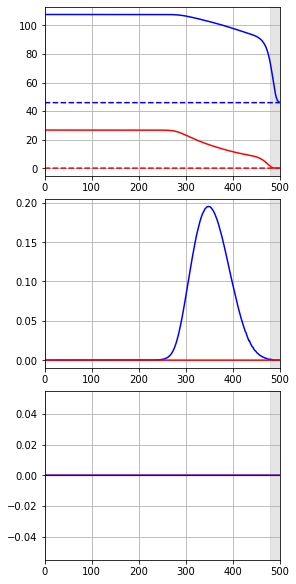

-------  62 0.4250000000000001 0.6500000000000004
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  19312.78699134316
RUN  0 , total integrated cost =  19312.78699134316
Gradient descend method:  None
RUN  1 , total integrated cost =  19246.390220474314
RUN  2 , total integrated cost =  19206.69223259566
RUN  3 , total integrated cost =  19122.175711667333
RUN  4 , total integrated cost =  19075.471572298953
RUN  5 , total integrated cost =  18942.759558677622
RUN  6 , total integrated cost =  18885.794065044156
RUN  7 , total integrated cost =  18671.0527936692
RUN  8 , total integrated cost =  18573.927136902646
RUN  9 , total integrated cost =  18329.391547462943
RUN  10 , total integrated cost =  18240.046681631593
RUN  11 , total integrated cost =  17920.161596569418
RUN  12 , total integrated cost =  17788.592162393685
RUN  13 , total integrated cost =  16953.156719407063
RUN  14 , total integrated cost =  16858.7902614084

RUN  1 , total integrated cost =  23681.115393538257
RUN  2 , total integrated cost =  23681.114070025156
RUN  3 , total integrated cost =  23681.077489185336
RUN  4 , total integrated cost =  23681.046825800513
RUN  5 , total integrated cost =  23681.045395837555
RUN  6 , total integrated cost =  23681.041037965864
RUN  7 , total integrated cost =  23681.041037965864
Control only changes marginally.
RUN  7 , total integrated cost =  23681.041037965864
Improved over  7  iterations in  9.037285908008926  seconds by  0.0004093984841233578  percent.
cost splitting :  7.67665796152619 [1.52662754e-12 1.60102250e+00 0.00000000e+00 0.00000000e+00]
--------------- k  6
set cost params:  1.0 0.0 15763.856070231126
interpolate adjoint :  True True True
initial cost =  25245.964870270294
RUN  0 , total integrated cost =  25245.964870270294
Gradient descend method:  None
RUN  1 , total integrated cost =  25245.94980636286
RUN  2 , total integrated cost =  25245.94824112599
RUN  3 , total integrat

RUN  1 , total integrated cost =  42459.614659207036
RUN  2 , total integrated cost =  42459.614659207036
Control only changes marginally.
RUN  2 , total integrated cost =  42459.614659207036
Improved over  2  iterations in  2.228209063061513  seconds by  1.040510660743621e-05  percent.
cost splitting :  14.056363809308362 [1.52662754e-12 1.60064543e+00 0.00000000e+00 0.00000000e+00]
--------------- k  18
set cost params:  1.0 0.0 27495.414662061397
interpolate adjoint :  True True True
initial cost =  44024.46616985425
RUN  0 , total integrated cost =  44024.46616985425
Gradient descend method:  None
RUN  1 , total integrated cost =  44024.457372361285
RUN  2 , total integrated cost =  44024.457372361285
Control only changes marginally.
RUN  2 , total integrated cost =  44024.457372361285
Improved over  2  iterations in  2.6247935889987275  seconds by  1.9983190540528994e-05  percent.
cost splitting :  14.622247463100617 [1.52662754e-12 1.60062453e+00 0.00000000e+00 0.00000000e+00]
--

RUN  1 , total integrated cost =  109744.07914744967
RUN  2 , total integrated cost =  109744.07914744967
Control only changes marginally.
RUN  2 , total integrated cost =  109744.07914744967
Improved over  2  iterations in  2.7837375689996406  seconds by  0.0005472327489428608  percent.
cost splitting :  36.92718342201748 [1.52662754e-12 1.59994727e+00 0.00000000e+00 0.00000000e+00]
--------------- k  61
set cost params:  1.0 0.0 69548.84075283629
interpolate adjoint :  True True True
initial cost =  111311.40475626141
RUN  0 , total integrated cost =  111311.40475626141
Gradient descend method:  None
RUN  1 , total integrated cost =  111311.3690202873
RUN  2 , total integrated cost =  111311.33734226276
RUN  3 , total integrated cost =  111311.33734226276
Control only changes marginally.
RUN  3 , total integrated cost =  111311.33734226276
Improved over  3  iterations in  3.8730675880797207  seconds by  6.056342456872699e-05  percent.
cost splitting :  37.27075512177991 [1.52662754e-

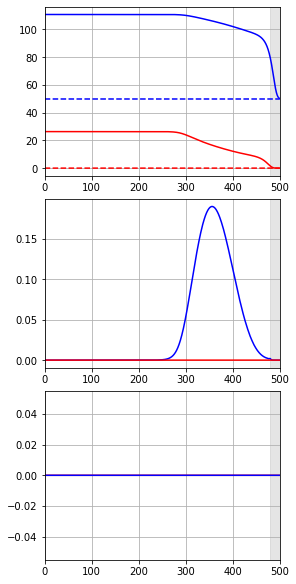

-------  69 0.4250000000000001 0.6750000000000004
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  16023.229256890252
RUN  0 , total integrated cost =  16023.229256890252
Gradient descend method:  None
RUN  1 , total integrated cost =  16011.344493355311
RUN  2 , total integrated cost =  16002.390281526692
RUN  3 , total integrated cost =  15992.216875854674
RUN  4 , total integrated cost =  15984.01758286488
RUN  5 , total integrated cost =  15974.713205882043
RUN  6 , total integrated cost =  15967.821611687506
RUN  7 , total integrated cost =  15952.662859980186
RUN  8 , total integrated cost =  15941.53887874223
RUN  9 , total integrated cost =  15926.236423351414
RUN  10 , total integrated cost =  15915.152928324018
RUN  11 , total integrated cost =  15903.567401021559
RUN  12 , total integrated cost =  15895.114123310435
RUN  13 , total integrated cost =  15857.173009601638
RUN  14 , total integrated cost =  15835.1355662

RUN  1 , total integrated cost =  23001.193772358256
RUN  2 , total integrated cost =  23001.191801826437
RUN  3 , total integrated cost =  23001.17968832235
RUN  4 , total integrated cost =  23001.173756072545
RUN  5 , total integrated cost =  23001.13994002847
RUN  6 , total integrated cost =  23001.105753666518
RUN  7 , total integrated cost =  23001.10351197545
RUN  8 , total integrated cost =  23001.094995908796
RUN  9 , total integrated cost =  23001.089793015948
RUN  10 , total integrated cost =  23000.87531788103
RUN  11 , total integrated cost =  23000.63731561173
RUN  12 , total integrated cost =  23000.63731561173
Control only changes marginally.
RUN  12 , total integrated cost =  23000.63731561173
Improved over  12  iterations in  16.05348193703685  seconds by  0.002499865021221126  percent.
cost splitting :  8.683732828919664 [0.         1.55194838 0.         0.        ]
--------------- k  6
set cost params:  1.0 0.0 15798.168708277099
interpolate adjoint :  True True True

RUN  1 , total integrated cost =  39773.23275390187
Control only changes marginally.
RUN  1 , total integrated cost =  39773.23275390187
Improved over  1  iterations in  1.5521768430480734  seconds by  0.0  percent.
cost splitting :  11.484613688415983 [0.         1.55052522 0.         0.        ]
--------------- k  27
set cost params:  1.0 0.0 36468.08652982838
interpolate adjoint :  True True True
initial cost =  56556.17235024474
RUN  0 , total integrated cost =  56556.17235024474
Gradient descend method:  None
RUN  1 , total integrated cost =  56555.00417944349
RUN  2 , total integrated cost =  56555.00417944349
Control only changes marginally.
RUN  2 , total integrated cost =  56555.00417944349
Improved over  2  iterations in  2.9642030430259183  seconds by  0.002065505412957691  percent.
cost splitting :  17.368283910605292 [0.         1.55033185 0.         0.        ]
--------------- k  28
set cost params:  1.0 0.0 37454.809376571226
interpolate adjoint :  True True True
initial

RUN  1 , total integrated cost =  137424.65512598425
Control only changes marginally.
RUN  1 , total integrated cost =  137424.65512598425
Improved over  1  iterations in  1.6094911079853773  seconds by  0.0  percent.
cost splitting :  44.05699250467947 [0.         1.54987566 0.         0.        ]
--------------- k  91
set cost params:  1.0 0.0 99466.47077932827
interpolate adjoint :  True True True
initial cost =  154204.719125979
RUN  0 , total integrated cost =  154204.719125979
Gradient descend method:  None
RUN  1 , total integrated cost =  154204.34834057928
RUN  2 , total integrated cost =  154204.34834057928
Control only changes marginally.
RUN  2 , total integrated cost =  154204.34834057928
Improved over  2  iterations in  3.118306196993217  seconds by  0.00024045009894280156  percent.
cost splitting :  50.29191094545981 [0.         1.54980925 0.         0.        ]
--------------- k  92
set cost params:  1.0 0.0 100451.28703668201
interpolate adjoint :  True True True
initi

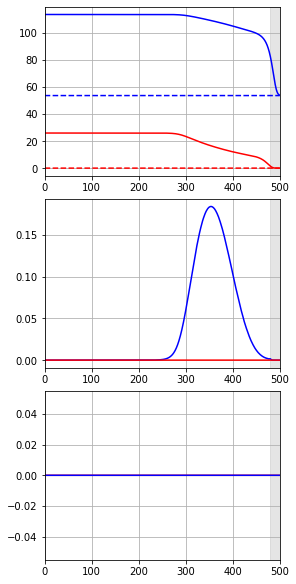

-------  76 0.4250000000000001 0.7000000000000004
--------------- k  0
set cost params:  1.0 0.0 9900.0
interpolate adjoint :  True True True
initial cost =  18187.84264944895
RUN  0 , total integrated cost =  18187.84264944895
Gradient descend method:  None
RUN  1 , total integrated cost =  18123.44458148949
RUN  2 , total integrated cost =  18087.291269921992
RUN  3 , total integrated cost =  18019.01029595672
RUN  4 , total integrated cost =  17980.16201108541
RUN  5 , total integrated cost =  17922.75726082679
RUN  6 , total integrated cost =  17885.66064105501
RUN  7 , total integrated cost =  17820.849290967795
RUN  8 , total integrated cost =  17784.942201095524
RUN  9 , total integrated cost =  17711.615306342603
RUN  10 , total integrated cost =  17670.40111818228
RUN  11 , total integrated cost =  17572.218335720958
RUN  12 , total integrated cost =  17510.84105666359
RUN  13 , total integrated cost =  17367.007389633676
RUN  14 , total integrated cost =  17298.27805882662
RU

RUN  1 , total integrated cost =  22321.260625290408
RUN  2 , total integrated cost =  22321.25850778198
RUN  3 , total integrated cost =  22321.2511540855
RUN  4 , total integrated cost =  22321.245496586467
RUN  5 , total integrated cost =  22321.23032533149
RUN  6 , total integrated cost =  22321.20517422758
RUN  7 , total integrated cost =  22321.203159069963
RUN  8 , total integrated cost =  22321.196803916075
RUN  9 , total integrated cost =  22321.192859084564
RUN  10 , total integrated cost =  22321.170104070705
RUN  11 , total integrated cost =  22321.140281717067
RUN  12 , total integrated cost =  22321.138237482915
RUN  13 , total integrated cost =  22321.131095043438
RUN  14 , total integrated cost =  22321.12552809102
RUN  15 , total integrated cost =  22321.089863617293
RUN  16 , total integrated cost =  22321.043605757783
RUN  17 , total integrated cost =  22321.041198527975
RUN  18 , total integrated cost =  22321.037512192695
RUN  19 , total integrated cost =  22321.03

RUN  1 , total integrated cost =  38697.737338853
RUN  2 , total integrated cost =  38697.737338853
Control only changes marginally.
RUN  2 , total integrated cost =  38697.737338853
Improved over  2  iterations in  1.891687078983523  seconds by  4.621767178036862e-05  percent.
cost splitting :  13.532280712241281 [6.12677996e-13 1.50178931e+00 0.00000000e+00 1.56813542e-18]
--------------- k  17
set cost params:  1.0 0.0 26750.199239283793
interpolate adjoint :  True True True
initial cost =  40186.69564049657
RUN  0 , total integrated cost =  40186.69564049657
Gradient descend method:  None
RUN  1 , total integrated cost =  40186.68475287977
RUN  2 , total integrated cost =  40186.68475287977
Control only changes marginally.
RUN  2 , total integrated cost =  40186.68475287977
Improved over  2  iterations in  1.9559541740454733  seconds by  2.709259027255939e-05  percent.
cost splitting :  14.106736975797084 [6.12677996e-13 1.50176743e+00 0.00000000e+00 1.56813542e-18]
---------------

RUN  1 , total integrated cost =  56556.19528075007
RUN  2 , total integrated cost =  56556.19528075007
Control only changes marginally.
RUN  2 , total integrated cost =  56556.19528075007
Improved over  2  iterations in  1.972108718007803  seconds by  2.3500292613221063e-05  percent.
cost splitting :  17.163393312494684 [6.12677996e-13 1.50083290e+00 0.00000000e+00 1.56813542e-18]
--------------- k  29
set cost params:  1.0 0.0 38663.902986552464
interpolate adjoint :  True True True
initial cost =  58045.22109937127
RUN  0 , total integrated cost =  58045.22109937127
Gradient descend method:  None
RUN  1 , total integrated cost =  58045.1348130051
RUN  2 , total integrated cost =  58045.0232793496
RUN  3 , total integrated cost =  58045.02081195614
RUN  4 , total integrated cost =  58045.00917555988
RUN  5 , total integrated cost =  58045.00119711621
RUN  6 , total integrated cost =  58044.99013238276
RUN  7 , total integrated cost =  58044.969943630305
RUN  8 , total integrated cost

RUN  3 , total integrated cost =  87819.96938614894
Control only changes marginally.
RUN  3 , total integrated cost =  87819.96938614894
Improved over  3  iterations in  2.0377257299842313  seconds by  0.0013427532170879886  percent.
cost splitting :  26.855708954885056 [6.12677996e-13 1.50059087e+00 0.00000000e+00 1.56813542e-18]
--------------- k  50
set cost params:  1.0 0.0 59498.50386423917
interpolate adjoint :  True True True
initial cost =  89309.76754457917
RUN  0 , total integrated cost =  89309.76754457917
Gradient descend method:  None
RUN  1 , total integrated cost =  89309.76413225102
RUN  2 , total integrated cost =  89309.7529216707
RUN  3 , total integrated cost =  89309.7529216707
Control only changes marginally.
RUN  3 , total integrated cost =  89309.7529216707
Improved over  3  iterations in  2.609310279949568  seconds by  1.6373246580769774e-05  percent.
cost splitting :  27.168728128150555 [6.12677996e-13 1.50058537e+00 0.00000000e+00 1.56813542e-18]
------------

RUN  1 , total integrated cost =  136945.1227707885
RUN  2 , total integrated cost =  136944.82444860574
RUN  3 , total integrated cost =  136944.82444860574
Control only changes marginally.
RUN  3 , total integrated cost =  136944.82444860574
Improved over  3  iterations in  2.908673677011393  seconds by  0.00040230978680710905  percent.
cost splitting :  42.233391646873606 [6.12677996e-13 1.50035557e+00 0.00000000e+00 1.56813542e-18]
--------------- k  83
set cost params:  1.0 0.0 92239.21058723184
interpolate adjoint :  True True True
initial cost =  138433.84678612847
RUN  0 , total integrated cost =  138433.84678612847
Gradient descend method:  None
RUN  1 , total integrated cost =  138433.81620539227
RUN  2 , total integrated cost =  138433.81620539227
Control only changes marginally.
RUN  2 , total integrated cost =  138433.81620539227
Improved over  2  iterations in  1.8287713479949161  seconds by  2.209050525436851e-05  percent.
cost splitting :  43.78335296292028 [6.12677996e

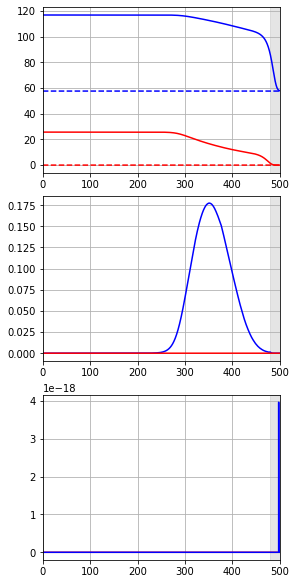

In [71]:
tol = 1e-6
c_var = [2,3,4,5]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    k = 0
        
    if i in bad:
        continue
        
    while not conv[i]:
        print('--------------- k ', k)
        max_it = min(1000, int(100*k))
        
        if k == 0:
            max_it = 100
            weight_ = w_[i]
        else:
            weight_ = ( cost_uncontrolled[i] - costnode_[i][0][0][0] ) / sum( costnode_[i][cost_index][0][:] )
            if k < 100:
                weight_ = w_[i] + 0.01 *k * (weight_ - w_[i])
            
        aln.params.duration = dur
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            if k > 100:
                conv[i] = True
            else: 
                k += 10

        #print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])

        if conv[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for l in range(3):
                ax[l].set_xlim(0.,dur)
                ax[l].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        if np.abs(target_[0,0,0] - bestState_[i][0,0,-1]) < 3.:
            with open(file_,'wb') as f:
                pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        else:
            print("converged to zero, reload and break")
            if os.path.isfile(file_) :
                print("file found")

                with open(file_,'rb') as f:
                    load_array = pickle.load(f)

                bestControl_ = load_array[0]
                bestState_ = load_array[1]
                cost_ = load_array[2]
                costnode_ = load_array[3]
                weights_ = load_array[4]   
            break
        
        k += 1

ERROR:root:Problem in initial value trasfer pre


-------  1 0.4250000000000001 0.3500000000000001
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2598247467769608
RUN  0 , total integrated cost =  2.2598247467769608
Gradient descend method:  None
RUN  0 , total integrated cost =  2.2598247467769608
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951152661352
uncontrolled cost :  244234.70502182204
cost splitting :  0.021664437531058782 [0. 0.]


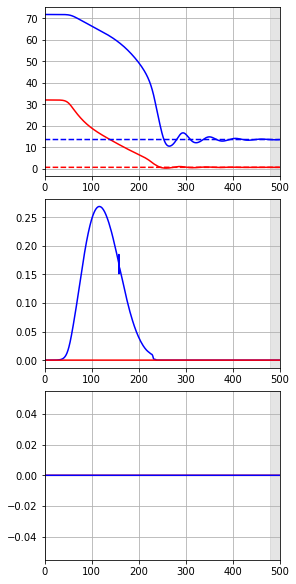

ERROR:root:Problem in initial value trasfer pre


-------  2 0.4000000000000001 0.3750000000000001
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.33305092287318466
RUN  0 , total integrated cost =  0.33305092287318466
Gradient descend method:  None
RUN  0 , total integrated cost =  0.33305092287318466
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.503837337451138 1.5038373230326747
uncontrolled cost :  137806.3558139294
cost splitting :  8.980178174941795e-15 [0. 0.]


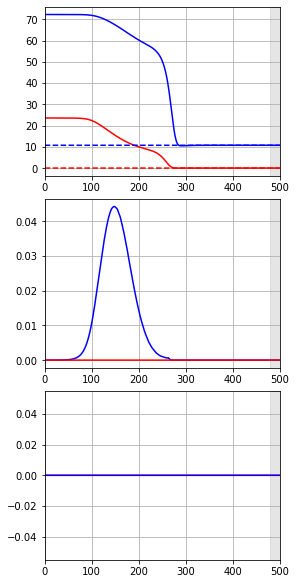

ERROR:root:Problem in initial value trasfer pre


-------  3 0.4250000000000001 0.3750000000000001
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.183510405248557
RUN  0 , total integrated cost =  2.183510405248557
Gradient descend method:  None
RUN  0 , total integrated cost =  2.183510405248557
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5025675080425562 1.5025674956192574
uncontrolled cost :  241480.3484875782
cost splitting :  8.860858900662356e-14 [0. 0.]


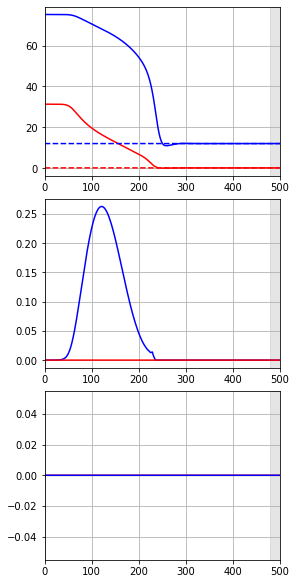

ERROR:root:Problem in initial value trasfer pre


-------  5 0.4000000000000001 0.40000000000000013
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.27970896017850144
RUN  0 , total integrated cost =  0.27970896017850144
Gradient descend method:  None
RUN  0 , total integrated cost =  0.27970896017850144
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5039081989608674 1.5039081865270343
uncontrolled cost :  126823.61408372025
cost splitting :  3.3826299603431705e-11 [0. 0.]


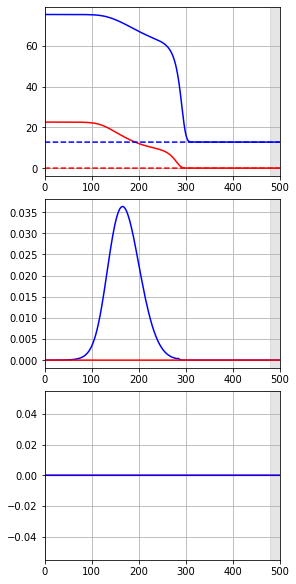

ERROR:root:Problem in initial value trasfer pre


-------  9 0.4000000000000001 0.42500000000000016
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.22436393777069788
RUN  0 , total integrated cost =  0.22436393777069788
Gradient descend method:  None
RUN  0 , total integrated cost =  0.22436393777069788
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5040468738619945 1.5040468630478832
uncontrolled cost :  115502.5972235114
cost splitting :  1.1490632858639839e-10 [0. 0.]


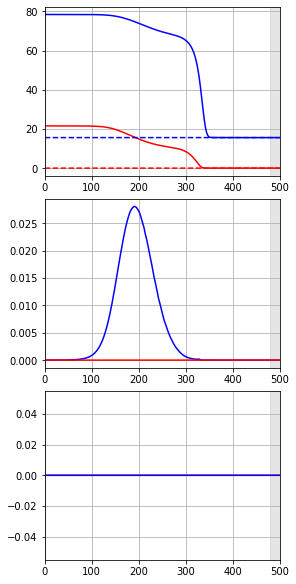

-------  10 0.4250000000000001 0.42500000000000016
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.070886370161383
RUN  0 , total integrated cost =  2.070886370161383
Gradient descend method:  None
RUN  0 , total integrated cost =  2.070886370161383
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  226698.47715197233
cost splitting :  1.1641480424787308e-12 [0. 0.]


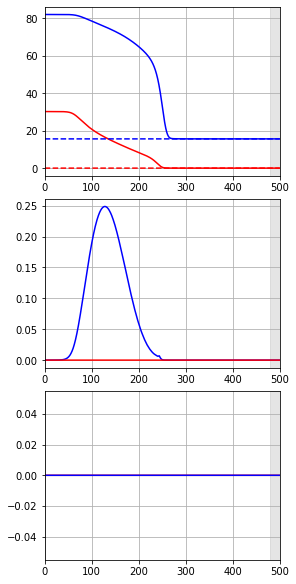

-------  13 0.4000000000000001 0.4500000000000002
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.167362116015119
RUN  0 , total integrated cost =  0.167362116015119
Gradient descend method:  None
RUN  0 , total integrated cost =  0.167362116015119
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  103932.40255255786
cost splitting :  2.1363243170808512e-10 [0. 0.]


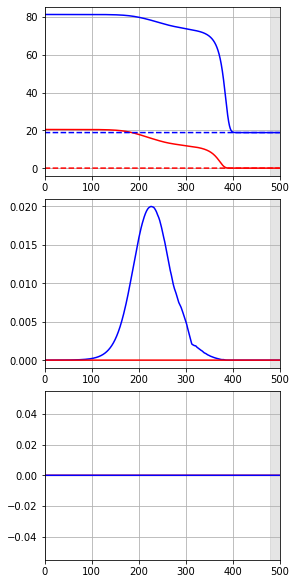

-------  14 0.4250000000000001 0.4500000000000002
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.0159309647507393
RUN  0 , total integrated cost =  2.0159309647507393
Gradient descend method:  None
RUN  0 , total integrated cost =  2.0159309647507393
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  218854.09939826332
cost splitting :  6.792992047694905e-14 [0. 0.]


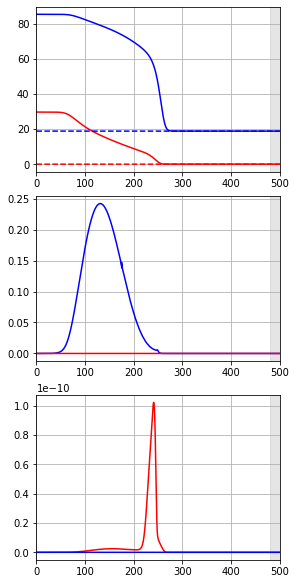

-------  19 0.4250000000000001 0.4750000000000002
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  1.9620562432493815
RUN  0 , total integrated cost =  1.9620562432493815
Gradient descend method:  None
RUN  0 , total integrated cost =  1.9620562432493815
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  211572.5759679924
cost splitting :  3.668471209348478e-15 [0. 0.]


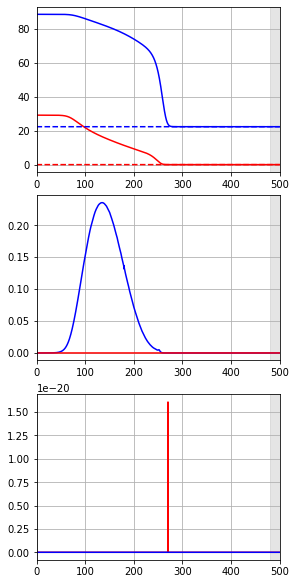

-------  25 0.4250000000000001 0.5000000000000002
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  1.9085131002483686
RUN  0 , total integrated cost =  1.9085131002483686
Gradient descend method:  None
RUN  0 , total integrated cost =  1.9085131002483686
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  204814.76624161197
cost splitting :  1.1013778392545865e-16 [0. 0.]


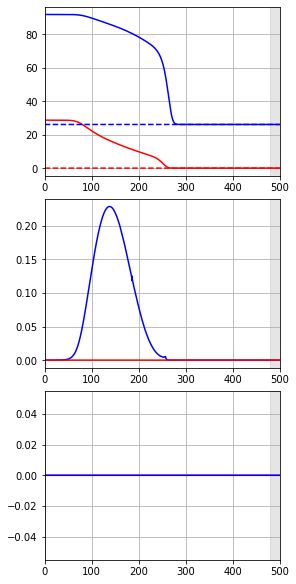

-------  55 0.4250000000000001 0.6250000000000003
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  1.6483905401707615
RUN  0 , total integrated cost =  1.6483905401707615
Gradient descend method:  None
RUN  0 , total integrated cost =  1.6483905401707615
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  176973.53086129532
cost splitting :  2.753793593596519e-21 [0. 0.]


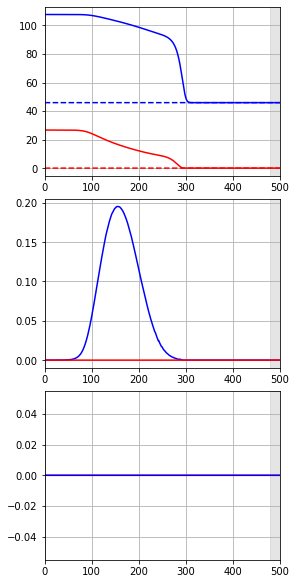

-------  62 0.4250000000000001 0.6500000000000004
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  1.599667089358072
RUN  0 , total integrated cost =  1.599667089358072
Gradient descend method:  None
RUN  0 , total integrated cost =  1.599667089358072
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  172327.22420179544
cost splitting :  5.370234343762207e-22 [0. 0.]


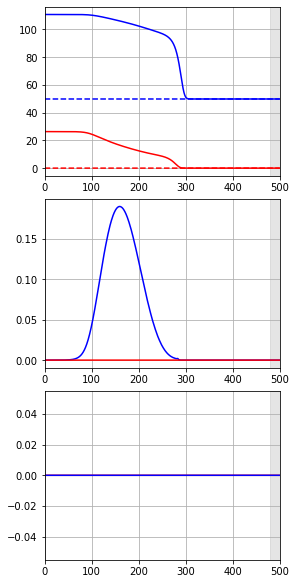

-------  69 0.4250000000000001 0.6750000000000004
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  1.5497213011931634
RUN  0 , total integrated cost =  1.5497213011931634
Gradient descend method:  None
RUN  0 , total integrated cost =  1.5497213011931634
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  167933.86239870195
cost splitting :  2.2592772750296103e-22 [0. 0.]


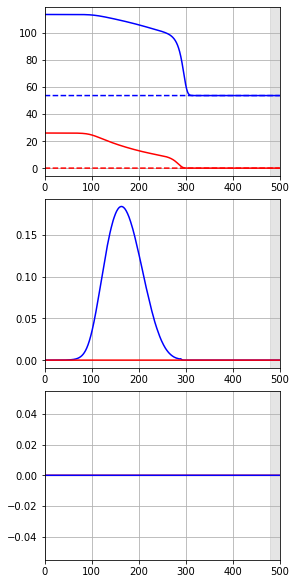

-------  76 0.4250000000000001 0.7000000000000004
init ind =  0
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  1.5002622398704937
RUN  0 , total integrated cost =  1.5002622398704937
Gradient descend method:  None
RUN  0 , total integrated cost =  1.5002622398704937
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  163736.8297408659
cost splitting :  9.612384905131356e-23 [0. 0.]


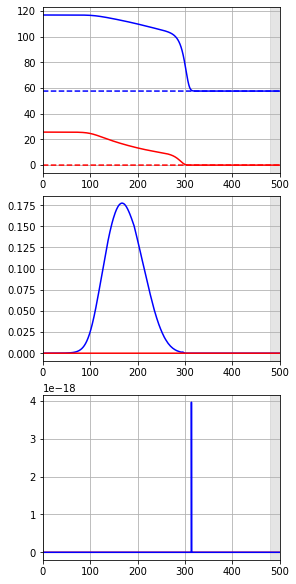

In [79]:
tol = 1.0 * 1e-12

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    max_it = int(0)
    limit = 1e-6
        
    for l in range( bestControl_[i].shape[2] ):
        if ( np.abs(bestControl_[i][0,2,l]) > limit or np.abs(bestControl_[i][0,3,l]) > limit
            or np.abs(bestControl_[i][0,4,l]) > limit or np.abs(bestControl_[i][0,5,l]) > limit ):
            init_ind = l - n_pre
            break
            
    if init_ind == -1:
        init_ind = 0
            
    print("init ind = ", init_ind)

    weight_ = 1.
    cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
    weights_[i] = cost.getParams()

    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    if init_ind != 0:
        control0[:,:,:-init_ind] = bestControl_[i][:,:,n_pre-1+init_ind:-n_post+1]
    else:
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][:2])

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

        ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

        ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
        ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

In [25]:
bad = [12,54,60,66,72]

In [147]:
tol = 1.0 * 1e-12
conv_shift = [None] * len(exc)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    max_it = int(1000)
    
    if i != 1:
        continue
    
    if i in bad:
        continue
    
    while not conv_shift[i]:
            
        weight_ = 1.
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i]= aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][-1] == 0.:
            conv_shift[i] = True

        print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

        if False and conv_shift[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for k in range(3):
                ax[k].set_xlim(0.,dur)
                ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()
            
        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958715401113
RUN  0 , total integrated cost =  2.236958715401113
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369587154009545
RUN  2 , total integrated cost =  2.236958715399257
RUN  3 , total integrated cost =  2.2369587153983215
RUN  4 , total integrated cost =  2.236958715398139
RUN  5 , total integrated cost =  2.236958715396818
RUN  6 , total integrated cost =  2.236958715396337
RUN  7 , total integrated cost =  2.2369587153962143
RUN  8 , total integrated cost =  2.2369587153902217
RUN  9 , total integrated cost =  2.2369587153862467
RUN  10 , total integrated cost =  2.2369587153861117
RUN  11 , total integrated cost =  2.2369587153828143
RUN  12 , total integrated cost =  2.2369587153804784
RUN  13 , total integrated cost =  2.2369587153803083
RUN  14 , total integrated cost =  2.2369587153787585
RUN  15 , total integra

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958708247612
RUN  1000 , total integrated cost =  2.236958708247612
Improved over  1000  iterations in  218.4530103240395  seconds by  3.197868920779001e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151889383
uncontrolled cost :  244234.70502182204
cost splitting :  5.861555913528101e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958708247612
RUN  0 , total integrated cost =  2.236958708247612
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369587082440923
RUN  2 , total integrated cost =  2.2369587082420064
RUN  3 , total integrated cost =  2.2369587082418088
RUN  4 , total integrated cost =  2.236958708240497
RUN  5 , total integrated cost =  2.23695870824002
RUN  6 , total integrated cost =  2.2369587082398708
RUN  7 , total integrated cost =  2.236958708235964
RUN  8 , total integrated cost =  2.2369587082333853
RUN  9 , tota

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369586959344536
RUN  1000 , total integrated cost =  2.2369586959344536
Improved over  1000  iterations in  242.8506293380633  seconds by  5.504419249291459e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151888732
uncontrolled cost :  244234.70502182204
cost splitting :  5.952866053596757e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369586959344536
RUN  0 , total integrated cost =  2.2369586959344536
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369586959341525
RUN  2 , total integrated cost =  2.2369586959330245
RUN  3 , total integrated cost =  2.2369586959328003
RUN  4 , total integrated cost =  2.2369586959325383
RUN  5 , total integrated cost =  2.2369586959314227
RUN  6 , total integrated cost =  2.2369586959310954
RUN  7 , total integrated cost =  2.236958695930822
RUN  8 , total integrated cost =  2.2369586959296974
RUN  9

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369586883380674
RUN  1000 , total integrated cost =  2.2369586883380674
Improved over  1000  iterations in  243.76267685496714  seconds by  3.3958545486711955e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151888328
uncontrolled cost :  244234.70502182204
cost splitting :  5.974448351361401e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369586883380674
RUN  0 , total integrated cost =  2.2369586883380674
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369586883378854
RUN  2 , total integrated cost =  2.236958688336617
RUN  3 , total integrated cost =  2.2369586883360872
RUN  4 , total integrated cost =  2.2369586883359025
RUN  5 , total integrated cost =  2.236958688334316
RUN  6 , total integrated cost =  2.236958688333497
RUN  7 , total integrated cost =  2.2369586883332895
RUN  8 , total integrated cost =  2.236958688332079
RUN  9 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958627117738
RUN  1000 , total integrated cost =  2.236958627117738
Improved over  1000  iterations in  453.79876690206584  seconds by  2.736766205657659e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151885064
uncontrolled cost :  244234.70502182204
cost splitting :  7.098166557576688e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958627117738
RUN  0 , total integrated cost =  2.236958627117738
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958627113532
RUN  2 , total integrated cost =  2.23695862711314
RUN  3 , total integrated cost =  2.236958627112029
RUN  4 , total integrated cost =  2.236958627111568
RUN  5 , total integrated cost =  2.2369586265077968
RUN  6 , total integrated cost =  2.236958626157433
RUN  7 , total integrated cost =  2.2369586261539944
RUN  8 , total integrated cost =  2.236958626151194
RUN  9 , total 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958582273515
RUN  1000 , total integrated cost =  2.236958582273515
Improved over  1000  iterations in  368.4249834360089  seconds by  2.0046961282105258e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151882681
uncontrolled cost :  244234.70502182204
cost splitting :  6.312648580785805e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958582273515
RUN  0 , total integrated cost =  2.236958582273515
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958582273018
RUN  2 , total integrated cost =  2.236958582272803
RUN  3 , total integrated cost =  2.236958582271641
RUN  4 , total integrated cost =  2.236958582271205
RUN  5 , total integrated cost =  2.2369585822708022
RUN  6 , total integrated cost =  2.2369585822696227
RUN  7 , total integrated cost =  2.236958582269394
RUN  8 , total integrated cost =  2.23695858226856
RUN  9 , total 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958572053032
RUN  1000 , total integrated cost =  2.236958572053032
Improved over  1000  iterations in  407.1434727240121  seconds by  4.5689192518238997e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151882137
uncontrolled cost :  244234.70502182204
cost splitting :  6.439642002477007e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958572053032
RUN  0 , total integrated cost =  2.236958572053032
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369585720520737
RUN  2 , total integrated cost =  2.2369585720519436
RUN  3 , total integrated cost =  2.236958572045666
RUN  4 , total integrated cost =  2.2369585720411553
RUN  5 , total integrated cost =  2.2369585720410337
RUN  6 , total integrated cost =  2.2369585720351393
RUN  7 , total integrated cost =  2.236958572031114
RUN  8 , total integrated cost =  2.2369585720309826
RUN  9 , t

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369585377886794
RUN  1000 , total integrated cost =  2.2369585377886794
Improved over  1000  iterations in  379.6794122509891  seconds by  1.5317383628143943e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151880308
uncontrolled cost :  244234.70502182204
cost splitting :  6.257402937576543e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369585377886794
RUN  0 , total integrated cost =  2.2369585377886794
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369585377884493
RUN  2 , total integrated cost =  2.2369585340897866
RUN  3 , total integrated cost =  2.236958532120964
RUN  4 , total integrated cost =  2.2369585320110317
RUN  5 , total integrated cost =  2.236958531911953
RUN  6 , total integrated cost =  2.236958530990645
RUN  7 , total integrated cost =  2.236958530468007
RUN  8 , total integrated cost =  2.2369585304267314
RUN  9 ,

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958346443564
RUN  1000 , total integrated cost =  2.236958346443564
Improved over  1000  iterations in  284.75471587094944  seconds by  8.553806978284229e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115186905
uncontrolled cost :  244234.70502182204
cost splitting :  1.8835819227709365e-08 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958346443564
RUN  0 , total integrated cost =  2.236958346443564
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369583463520915
RUN  2 , total integrated cost =  2.236958346268487
RUN  3 , total integrated cost =  2.236958346165855
RUN  4 , total integrated cost =  2.236958346061953
RUN  5 , total integrated cost =  2.2369583459803084
RUN  6 , total integrated cost =  2.2369583459067357
RUN  7 , total integrated cost =  2.2369583457938638
RUN  8 , total integrated cost =  2.236958345687935
RUN  9 , tot

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958317138053
RUN  1000 , total integrated cost =  2.236958317138053
Improved over  1000  iterations in  320.106928342022  seconds by  1.3100606537364001e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151868457
uncontrolled cost :  244234.70502182204
cost splitting :  7.063964007951463e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958317138053
RUN  0 , total integrated cost =  2.236958317138053
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958317133005
RUN  2 , total integrated cost =  2.236958317132816
RUN  3 , total integrated cost =  2.2369583171317826
RUN  4 , total integrated cost =  2.2369583171314096
RUN  5 , total integrated cost =  2.2369583171312226
RUN  6 , total integrated cost =  2.236958317130046
RUN  7 , total integrated cost =  2.236958317129429
RUN  8 , total integrated cost =  2.236958317129189
RUN  9 , total

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958297508955
RUN  1000 , total integrated cost =  2.236958297508955
Improved over  1000  iterations in  412.7303094830131  seconds by  8.774905637665142e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151867391
uncontrolled cost :  244234.70502182204
cost splitting :  6.249714333456327e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958297508955
RUN  0 , total integrated cost =  2.236958297508955
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958297503894
RUN  2 , total integrated cost =  2.23695829749761
RUN  3 , total integrated cost =  2.2369582974974382
RUN  4 , total integrated cost =  2.236958297495109
RUN  5 , total integrated cost =  2.2369582974937097
RUN  6 , total integrated cost =  2.2369582974931577
RUN  7 , total integrated cost =  2.2369582974920337
RUN  8 , total integrated cost =  2.2369582974918405
RUN  9 , tota

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369582843542672
RUN  1000 , total integrated cost =  2.2369582843542672
Improved over  1000  iterations in  386.6609068890102  seconds by  5.880613684894342e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151866677
uncontrolled cost :  244234.70502182204
cost splitting :  6.148822058538856e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369582843542672
RUN  0 , total integrated cost =  2.2369582843542672
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958284353256
RUN  2 , total integrated cost =  2.2369582843529474
RUN  3 , total integrated cost =  2.2369582843527724
RUN  4 , total integrated cost =  2.236958284351473
RUN  5 , total integrated cost =  2.2369582843508606
RUN  6 , total integrated cost =  2.236958284350493
RUN  7 , total integrated cost =  2.236958284349417
RUN  8 , total integrated cost =  2.2369582843491984
RUN  9 , 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369582600730116
RUN  1000 , total integrated cost =  2.2369582600730116
Improved over  1000  iterations in  312.50111666100565  seconds by  1.0854585781316928e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151865362
uncontrolled cost :  244234.70502182204
cost splitting :  6.463370022308923e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369582600730116
RUN  0 , total integrated cost =  2.2369582600730116
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369582600728077
RUN  2 , total integrated cost =  2.2369582600724227
RUN  3 , total integrated cost =  2.2369582600713565
RUN  4 , total integrated cost =  2.236958260071146
RUN  5 , total integrated cost =  2.2369582600705358
RUN  6 , total integrated cost =  2.236958260069139
RUN  7 , total integrated cost =  2.236958260069004
RUN  8 , total integrated cost =  2.2369582600618156
RUN  9

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958243335138
RUN  1000 , total integrated cost =  2.236958243335138
Improved over  1000  iterations in  325.09002128604334  seconds by  7.482425559146577e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151864456
uncontrolled cost :  244234.70502182204
cost splitting :  6.367080342609783e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958243335138
RUN  0 , total integrated cost =  2.236958243335138
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958243334947
RUN  2 , total integrated cost =  2.236958243333769
RUN  3 , total integrated cost =  2.236958243333314
RUN  4 , total integrated cost =  2.236958243333064
RUN  5 , total integrated cost =  2.2369582433319963
RUN  6 , total integrated cost =  2.2369582433315855
RUN  7 , total integrated cost =  2.2369582433313133
RUN  8 , total integrated cost =  2.2369582433302737
RUN  9 , tot

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369582253245586
RUN  1000 , total integrated cost =  2.2369582253245586
Improved over  1000  iterations in  297.19902914902195  seconds by  8.051370343764574e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151863481
uncontrolled cost :  244234.70502182204
cost splitting :  6.575141934795283e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369582253245586
RUN  0 , total integrated cost =  2.2369582253245586
Gradient descend method:  None
RUN  1 , total integrated cost =  2.23695822532413
RUN  2 , total integrated cost =  2.236958225323925
RUN  3 , total integrated cost =  2.236958225322916
RUN  4 , total integrated cost =  2.2369582253225855
RUN  5 , total integrated cost =  2.2369582253221814
RUN  6 , total integrated cost =  2.236958225321159
RUN  7 , total integrated cost =  2.236958225320936
RUN  8 , total integrated cost =  2.236958225320734
RUN  9 , to

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.23695821270523
RUN  1000 , total integrated cost =  2.23695821270523
Improved over  1000  iterations in  422.2346877149539  seconds by  5.641289391178361e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151862797
uncontrolled cost :  244234.70502182204
cost splitting :  6.352218016685503e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.23695821270523
RUN  0 , total integrated cost =  2.23695821270523
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369582127043826
RUN  2 , total integrated cost =  2.2369582127027132
RUN  3 , total integrated cost =  2.2369582127025534
RUN  4 , total integrated cost =  2.2369582127022167
RUN  5 , total integrated cost =  2.2369582127011736
RUN  6 , total integrated cost =  2.236958212700954
RUN  7 , total integrated cost =  2.236958212700736
RUN  8 , total integrated cost =  2.2369582126996845
RUN  9 , total 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581968650722
RUN  1000 , total integrated cost =  2.2369581968650722
Improved over  1000  iterations in  425.7128206010675  seconds by  7.081114716811499e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151861936
uncontrolled cost :  244234.70502182204
cost splitting :  6.692317368081299e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581968650722
RUN  0 , total integrated cost =  2.2369581968650722
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581968642676
RUN  2 , total integrated cost =  2.2369581968639674
RUN  3 , total integrated cost =  2.236958196862963
RUN  4 , total integrated cost =  2.2369581968626595
RUN  5 , total integrated cost =  2.236958196862417
RUN  6 , total integrated cost =  2.2369581968613854
RUN  7 , total integrated cost =  2.236958196861059
RUN  8 , total integrated cost =  2.236958196860828
RUN  9 , 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581905354208
RUN  1000 , total integrated cost =  2.2369581905354208
Improved over  1000  iterations in  389.92182344105095  seconds by  2.8295796994370903e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151861592
uncontrolled cost :  244234.70502182204
cost splitting :  6.526095856268889e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581905354208
RUN  0 , total integrated cost =  2.2369581905354208
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581905351947
RUN  2 , total integrated cost =  2.2369581905348763
RUN  3 , total integrated cost =  2.236958190533835
RUN  4 , total integrated cost =  2.2369581905335973
RUN  5 , total integrated cost =  2.236958190533298
RUN  6 , total integrated cost =  2.236958190532285
RUN  7 , total integrated cost =  2.2369581905320546
RUN  8 , total integrated cost =  2.236958190531842
RUN  9 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581863977923
RUN  1000 , total integrated cost =  2.2369581863977923
Improved over  1000  iterations in  410.92783131590113  seconds by  1.849667370379393e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151861365
uncontrolled cost :  244234.70502182204
cost splitting :  6.612442816786506e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581863977923
RUN  0 , total integrated cost =  2.2369581863977923
Gradient descend method:  None
RUN  1 , total integrated cost =  2.23695818639735
RUN  2 , total integrated cost =  2.2369581863971866
RUN  3 , total integrated cost =  2.236958186395872
RUN  4 , total integrated cost =  2.2369581863952703
RUN  5 , total integrated cost =  2.236958186395078
RUN  6 , total integrated cost =  2.236958186393993
RUN  7 , total integrated cost =  2.236958186393621
RUN  8 , total integrated cost =  2.2369581863933305
RUN  9 , t

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958180688968
RUN  1000 , total integrated cost =  2.236958180688968
Improved over  1000  iterations in  355.0630348069826  seconds by  2.55204795962527e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151861057
uncontrolled cost :  244234.70502182204
cost splitting :  6.418002783264575e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958180688968
RUN  0 , total integrated cost =  2.236958180688968
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958180688832
RUN  2 , total integrated cost =  2.2369581806844807
RUN  3 , total integrated cost =  2.236958180681743
RUN  4 , total integrated cost =  2.2369581806814707
RUN  5 , total integrated cost =  2.236958180680446
RUN  6 , total integrated cost =  2.2369581806802037
RUN  7 , total integrated cost =  2.2369581806800065
RUN  8 , total integrated cost =  2.2369581806789434
RUN  9 , tota

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581734254123
RUN  1000 , total integrated cost =  2.2369581734254123
Improved over  1000  iterations in  431.33831790997647  seconds by  3.247068036671408e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115186066
uncontrolled cost :  244234.70502182204
cost splitting :  6.437244937781298e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581734254123
RUN  0 , total integrated cost =  2.2369581734254123
Gradient descend method:  None
RUN  1 , total integrated cost =  2.23695817342523
RUN  2 , total integrated cost =  2.2369581734223942
RUN  3 , total integrated cost =  2.2369581734203074
RUN  4 , total integrated cost =  2.2369581734197532
RUN  5 , total integrated cost =  2.2369581734186723
RUN  6 , total integrated cost =  2.23695817341844
RUN  7 , total integrated cost =  2.236958173411871
RUN  8 , total integrated cost =  2.23695817340303
RUN  9 , tot

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581653976445
RUN  1000 , total integrated cost =  2.2369581653976445
Improved over  1000  iterations in  366.8074245590251  seconds by  3.5886982630017883e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115186022
uncontrolled cost :  244234.70502182204
cost splitting :  6.516432564714749e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581653976445
RUN  0 , total integrated cost =  2.2369581653976445
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958165397447
RUN  2 , total integrated cost =  2.236958165397175
RUN  3 , total integrated cost =  2.2369581653961834
RUN  4 , total integrated cost =  2.236958165395907
RUN  5 , total integrated cost =  2.236958165395441
RUN  6 , total integrated cost =  2.23695816539431
RUN  7 , total integrated cost =  2.2369581653940944
RUN  8 , total integrated cost =  2.2369581653934256
RUN  9 , to

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581621406813
RUN  1000 , total integrated cost =  2.2369581621406813
Improved over  1000  iterations in  372.1432942659594  seconds by  1.455978519970813e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151860042
uncontrolled cost :  244234.70502182204
cost splitting :  6.587098854073569e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581621406813
RUN  0 , total integrated cost =  2.2369581621406813
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958162140333
RUN  2 , total integrated cost =  2.2369581621401182
RUN  3 , total integrated cost =  2.236958162139057
RUN  4 , total integrated cost =  2.2369581621386883
RUN  5 , total integrated cost =  2.2369581621383583
RUN  6 , total integrated cost =  2.2369581621373333
RUN  7 , total integrated cost =  2.2369581621370966
RUN  8 , total integrated cost =  2.2369581621368884
RUN  9 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958159957988
RUN  1000 , total integrated cost =  2.236958159957988
Improved over  1000  iterations in  427.25124703196343  seconds by  9.757415853073326e-08  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151859922
uncontrolled cost :  244234.70502182204
cost splitting :  6.598255992631075e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958159957988
RUN  0 , total integrated cost =  2.236958159957988
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581599576245
RUN  2 , total integrated cost =  2.236958159957425
RUN  3 , total integrated cost =  2.236958159956369
RUN  4 , total integrated cost =  2.2369581599559787
RUN  5 , total integrated cost =  2.2369581599557855
RUN  6 , total integrated cost =  2.2369581599546486
RUN  7 , total integrated cost =  2.2369581599541672
RUN  8 , total integrated cost =  2.2369581599540025
RUN  9 , t

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581585895837
RUN  1000 , total integrated cost =  2.2369581585895837
Improved over  1000  iterations in  397.9420050730696  seconds by  6.117255679782829e-08  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151859846
uncontrolled cost :  244234.70502182204
cost splitting :  6.404860269466507e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581585895837
RUN  0 , total integrated cost =  2.2369581585895837
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581585893528
RUN  2 , total integrated cost =  2.2369581585883194
RUN  3 , total integrated cost =  2.2369581585879383
RUN  4 , total integrated cost =  2.2369581585872087
RUN  5 , total integrated cost =  2.236958158585671
RUN  6 , total integrated cost =  2.2369581585855
RUN  7 , total integrated cost =  2.2369581585849256
RUN  8 , total integrated cost =  2.2369581585836333
RUN  9 , 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958146939134
RUN  1000 , total integrated cost =  2.236958146939134
Improved over  1000  iterations in  377.2328924139729  seconds by  5.208165987369284e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115185921
uncontrolled cost :  244234.70502182204
cost splitting :  6.512836002167397e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958146939134
RUN  0 , total integrated cost =  2.236958146939134
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581469389557
RUN  2 , total integrated cost =  2.2369581469379667
RUN  3 , total integrated cost =  2.236958146936287
RUN  4 , total integrated cost =  2.2369581469361197
RUN  5 , total integrated cost =  2.2369581469272584
RUN  6 , total integrated cost =  2.236958146917317
RUN  7 , total integrated cost =  2.236958146917153
RUN  8 , total integrated cost =  2.236958146912207
RUN  9 , total

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958135975767
RUN  1000 , total integrated cost =  2.236958135975767
Improved over  1000  iterations in  403.2955855500186  seconds by  4.901015699942946e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115185861
uncontrolled cost :  244234.70502182204
cost splitting :  6.406706236595252e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958135975767
RUN  0 , total integrated cost =  2.236958135975767
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581359750836
RUN  2 , total integrated cost =  2.23695813597372
RUN  3 , total integrated cost =  2.236958135973537
RUN  4 , total integrated cost =  2.2369581359091444
RUN  5 , total integrated cost =  2.2369581358523853
RUN  6 , total integrated cost =  2.2369581358520856
RUN  7 , total integrated cost =  2.2369581358508603
RUN  8 , total integrated cost =  2.236958135848811
RUN  9 , total

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958125332858
RUN  1000 , total integrated cost =  2.236958125332858
Improved over  1000  iterations in  417.4250663620187  seconds by  4.757759626272673e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151858026
uncontrolled cost :  244234.70502182204
cost splitting :  6.393485137459184e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958125332858
RUN  0 , total integrated cost =  2.236958125332858
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581253249033
RUN  2 , total integrated cost =  2.236958125315761
RUN  3 , total integrated cost =  2.2369581253155837
RUN  4 , total integrated cost =  2.236958125237126
RUN  5 , total integrated cost =  2.2369581251676247
RUN  6 , total integrated cost =  2.2369581251672623
RUN  7 , total integrated cost =  2.236958125164086
RUN  8 , total integrated cost =  2.236958125160232
RUN  9 , tota

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581166530597
RUN  1000 , total integrated cost =  2.2369581166530597
Improved over  1000  iterations in  395.9706341829151  seconds by  3.8801790935849567e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115185755
uncontrolled cost :  244234.70502182204
cost splitting :  6.444054411748533e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581166530597
RUN  0 , total integrated cost =  2.2369581166530597
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369581166527417
RUN  2 , total integrated cost =  2.236958116651757
RUN  3 , total integrated cost =  2.236958116651519
RUN  4 , total integrated cost =  2.236958116651191
RUN  5 , total integrated cost =  2.236958116650214
RUN  6 , total integrated cost =  2.236958116649925
RUN  7 , total integrated cost =  2.2369581166494847
RUN  8 , total integrated cost =  2.2369581166483368
RUN  9 , t

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369581092635857
RUN  1000 , total integrated cost =  2.2369581092635857
Improved over  1000  iterations in  413.02180764602963  seconds by  3.303358084849606e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151857146
uncontrolled cost :  244234.70502182204
cost splitting :  6.237516872499199e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369581092635857
RUN  0 , total integrated cost =  2.2369581092635857
Gradient descend method:  None
RUN  1 , total integrated cost =  2.23695810926249
RUN  2 , total integrated cost =  2.2369581092622712
RUN  3 , total integrated cost =  2.236958109261859
RUN  4 , total integrated cost =  2.236958109260706
RUN  5 , total integrated cost =  2.236958109260525
RUN  6 , total integrated cost =  2.236958109259558
RUN  7 , total integrated cost =  2.236958109257848
RUN  8 , total integrated cost =  2.236958109257684
RUN  9 , tot

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369580971819976
RUN  1000 , total integrated cost =  2.2369580971819976
Improved over  1000  iterations in  388.3227653099457  seconds by  5.400900562335664e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151856487
uncontrolled cost :  244234.70502182204
cost splitting :  6.569112588655243e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369580971819976
RUN  0 , total integrated cost =  2.2369580971819976
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369580971818284
RUN  2 , total integrated cost =  2.236958097175258
RUN  3 , total integrated cost =  2.236958097166337
RUN  4 , total integrated cost =  2.2369580971661907
RUN  5 , total integrated cost =  2.2369580971596847
RUN  6 , total integrated cost =  2.2369580971549086
RUN  7 , total integrated cost =  2.2369580971547016
RUN  8 , total integrated cost =  2.2369580971536225
RUN  9 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369580861182583
RUN  1000 , total integrated cost =  2.2369580861182583
Improved over  1000  iterations in  384.46628625306766  seconds by  4.94588576316346e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151855883
uncontrolled cost :  244234.70502182204
cost splitting :  6.478605849369946e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369580861182583
RUN  0 , total integrated cost =  2.2369580861182583
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369580861179332
RUN  2 , total integrated cost =  2.2369580861169314
RUN  3 , total integrated cost =  2.2369580861167235
RUN  4 , total integrated cost =  2.236958086115997
RUN  5 , total integrated cost =  2.2369580861144494
RUN  6 , total integrated cost =  2.2369580861142846
RUN  7 , total integrated cost =  2.2369580861132845
RUN  8 , total integrated cost =  2.236958086111391
RUN  9 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369580789047525
RUN  1000 , total integrated cost =  2.2369580789047525
Improved over  1000  iterations in  386.11377653107047  seconds by  3.2246941827906994e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151855488
uncontrolled cost :  244234.70502182204
cost splitting :  6.445913894816887e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369580789047525
RUN  0 , total integrated cost =  2.2369580789047525
Gradient descend method:  None
RUN  1 , total integrated cost =  2.236958078897453
RUN  2 , total integrated cost =  2.236958078887573
RUN  3 , total integrated cost =  2.236958078887432
RUN  4 , total integrated cost =  2.2369580788814245
RUN  5 , total integrated cost =  2.2369580788769894
RUN  6 , total integrated cost =  2.236958078876788
RUN  7 , total integrated cost =  2.236958078875751
RUN  8 , total integrated cost =  2.236958078875453
RUN  9 , 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369580753566334
RUN  1000 , total integrated cost =  2.2369580753566334
Improved over  1000  iterations in  383.08030547900125  seconds by  1.5861357383073482e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151855295
uncontrolled cost :  244234.70502182204
cost splitting :  6.322472600476736e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369580753566334
RUN  0 , total integrated cost =  2.2369580753566334
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369580753556257
RUN  2 , total integrated cost =  2.2369580753553846
RUN  3 , total integrated cost =  2.236958075355089
RUN  4 , total integrated cost =  2.236958075354064
RUN  5 , total integrated cost =  2.236958075353848
RUN  6 , total integrated cost =  2.236958075353621
RUN  7 , total integrated cost =  2.2369580753525926
RUN  8 , total integrated cost =  2.2369580753522533
RUN  9 

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369580722839784
RUN  1000 , total integrated cost =  2.2369580722839784
Improved over  1000  iterations in  408.1196473510936  seconds by  1.3735864001773734e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151855126
uncontrolled cost :  244234.70502182204
cost splitting :  6.513898608134364e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369580722839784
RUN  0 , total integrated cost =  2.2369580722839784
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369580722838283
RUN  2 , total integrated cost =  2.236958072278467
RUN  3 , total integrated cost =  2.236958072274221
RUN  4 , total integrated cost =  2.2369580722740277
RUN  5 , total integrated cost =  2.2369580722728606
RUN  6 , total integrated cost =  2.236958072272406
RUN  7 , total integrated cost =  2.2369580722719
RUN  8 , total integrated cost =  2.2369580722706193
RUN  9 , t

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.236958069809022
RUN  1000 , total integrated cost =  2.236958069809022
Improved over  1000  iterations in  405.0557448180625  seconds by  1.106393625605051e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.5026951151854993
uncontrolled cost :  244234.70502182204
cost splitting :  6.484722380207746e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.236958069809022
RUN  0 , total integrated cost =  2.236958069809022
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369580698086127
RUN  2 , total integrated cost =  2.236958069807487
RUN  3 , total integrated cost =  2.2369580698072595
RUN  4 , total integrated cost =  2.236958069806969
RUN  5 , total integrated cost =  2.236958069805925
RUN  6 , total integrated cost =  2.23695806980566
RUN  7 , total integrated cost =  2.2369580698052514
RUN  8 , total integrated cost =  2.2369580698040537
RUN  9 , total

ERROR:root:Problem in initial value trasfer pre


RUN  1000 , total integrated cost =  2.2369580650224
RUN  1000 , total integrated cost =  2.2369580650224
Improved over  1000  iterations in  393.98604558291845  seconds by  2.1397907801201654e-07  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.502695115185473
uncontrolled cost :  244234.70502182204
cost splitting :  6.515718516919506e-10 [0. 0.]
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2.2369580650224
RUN  0 , total integrated cost =  2.2369580650224
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2369580650222454
RUN  2 , total integrated cost =  2.2369580650204686
RUN  3 , total integrated cost =  2.2369580650195258
RUN  4 , total integrated cost =  2.2369580650193894
RUN  5 , total integrated cost =  2.2369580650164718
RUN  6 , total integrated cost =  2.2369580650148015
RUN  7 , total integrated cost =  2.236958065014686
RUN  8 , total integrated cost =  2.2369580648186185
RUN  9 , total in

ERROR:root:Problem in initial value trasfer pre


Control only changes marginally.
RUN  69 , total integrated cost =  2.2369580644663105
Improved over  69  iterations in  26.84370686498005  seconds by  2.4859176050995302e-08  percent.
Problem in initial value trasfer pre:  sigmae_f 1.502695129860425 1.50269511518547
uncontrolled cost :  244234.70502182204
cost splitting :  6.562062664194382e-10 [0. 0.]
-------  2 0.4000000000000001 0.3750000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  10 0.4250000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  14 0.4250000000000001 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  55 0.4250000000000001 0.6250000000000003
-------  62 0.4250000000000001 0.6500000000000004
-------  69 0.4250000000000001 0.6750000000000004
-------  76 0.4250000000000001 0.700000000000

-------  0 0.4000000000000001 0.3500000000000001


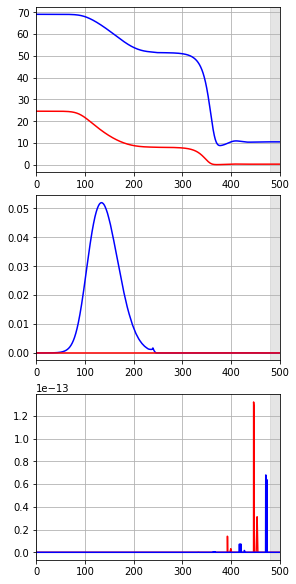

-------  6 0.4250000000000001 0.40000000000000013


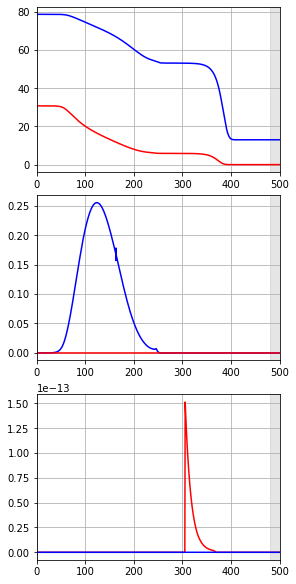

-------  12 0.47500000000000014 0.42500000000000016


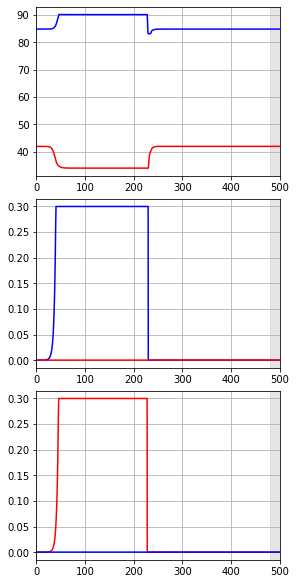

-------  18 0.4000000000000001 0.4750000000000002


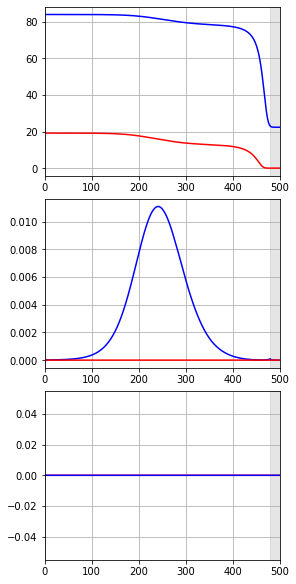

-------  24 0.4000000000000001 0.5000000000000002


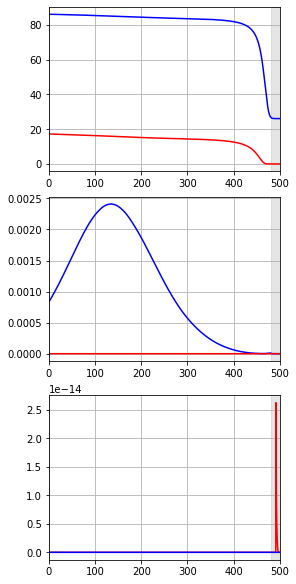

-------  30 0.4250000000000001 0.5250000000000002


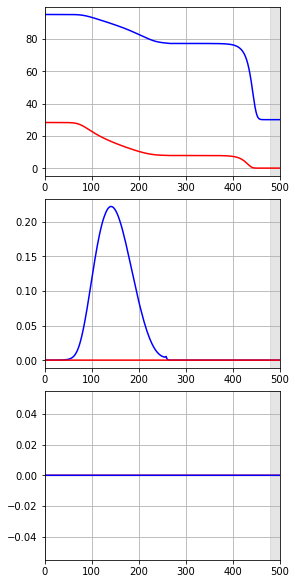

-------  36 0.4250000000000001 0.5500000000000003


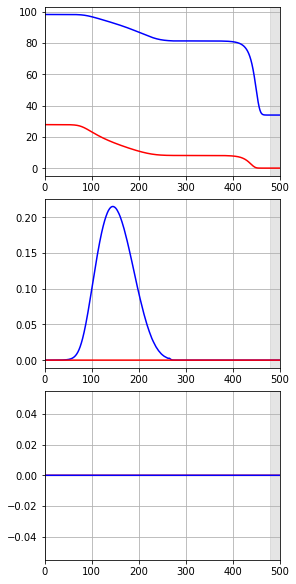

-------  42 0.4250000000000001 0.5750000000000003


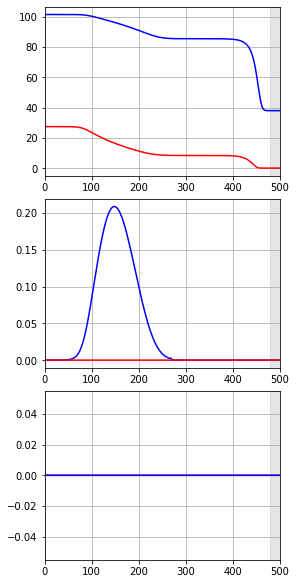

-------  48 0.4250000000000001 0.6000000000000003


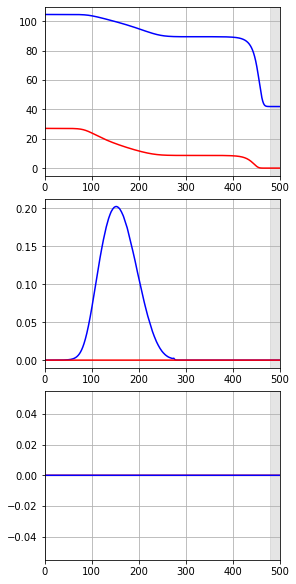

-------  54 0.5750000000000002 0.6000000000000003


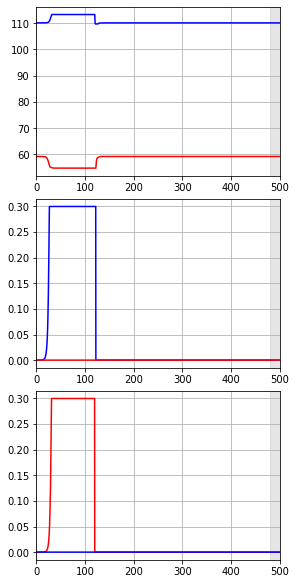

-------  60 0.5500000000000003 0.6250000000000003


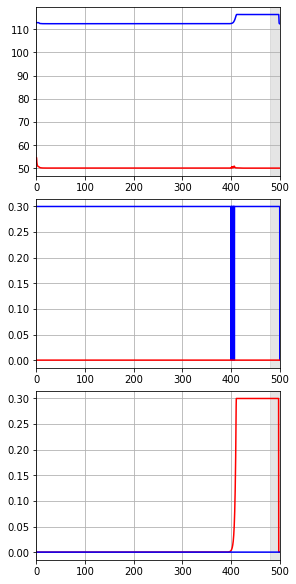

-------  66 0.5250000000000001 0.6500000000000004


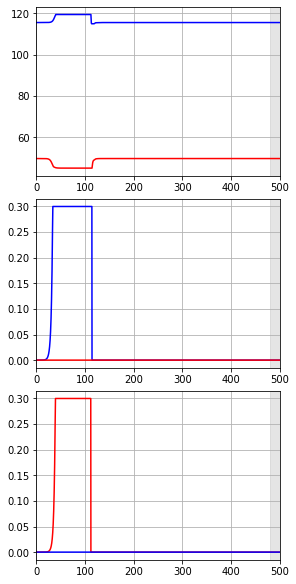

-------  72 0.5000000000000002 0.6750000000000004


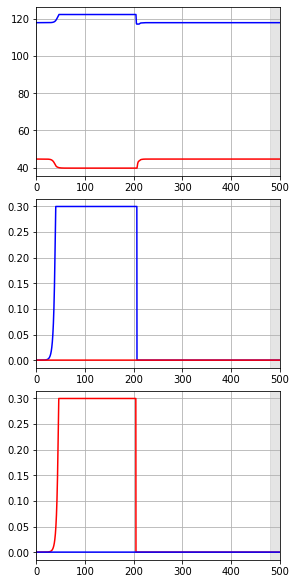

In [29]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    if i in bad:
        continue
        
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)


    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

    ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')

    ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

    ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
    ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

    for k in range(3):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

In [35]:
bad = [0, 18, 24]

------------------------------ 11
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  0.08133010744658913
RUN  0 , total integrated cost =  0.08133010744658913
Gradient descend method:  None
RUN  0 , total integrated cost =  0.08133010744658913
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


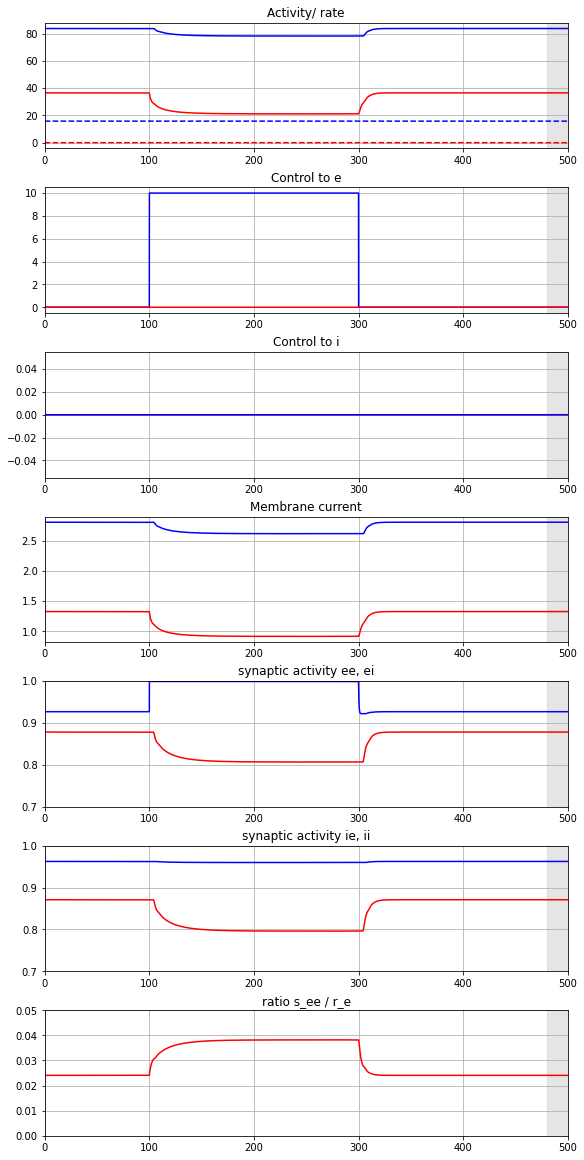

In [177]:
i_range = [11]

for i in i_range:
    
    if i > 24:
        continue
        
    print('------------------------------', i)
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.dt = 0.001
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    #control0 = 3.2 * bestControl_[6][:,:,n_pre-1:-n_post+1]
    #control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]
    if i in [9,10,11,12]:
        #control0 = 3. * bestControl_[6][:,:,n_pre-1:-n_post+1]
        control0[0,3,100000:300000] = 100.
            
    #control0[0,2,1320:1340] = 0.5
    cost.setParams(1., 0., 0.)
    max_it = int(0)

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur ,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)

    plot_time_array = np.arange(0.,round(dur+aln.params.dt,3),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(7,1, constrained_layout=True, figsize = (8,16) )

    ax[0].plot(plot_time_array, bestState_init_[0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_init_[0,1,n_pre-1:-n_post+1], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

    ax[1].plot(plot_time_array, bestControl_init_[0,3,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_init_[0,2,n_pre-1:-n_post+1], color = 'red')

    ax[2].plot(plot_time_array, bestControl_init_[0,4,n_pre-1:-n_post+1], color = 'red')
    ax[2].plot(plot_time_array, bestControl_init_[0,5,n_pre-1:-n_post+1], color = 'blue')

    # mu
    ax[3].plot(plot_time_array, bestState_init_[0,2,n_pre-1:-n_post+1], color= 'red', label='mue')
    ax[3].plot(plot_time_array, bestState_init_[0,3,n_pre-1:-n_post+1], color= 'blue', label='mui')

    # s
    ax[4].plot(plot_time_array, bestState_init_[0,5,n_pre-1:-n_post+1], color= 'red')
    ax[4].plot(plot_time_array, bestState_init_[0,6,n_pre-1:-n_post+1], color= 'blue')
    ax[5].plot(plot_time_array, bestState_init_[0,7,n_pre-1:-n_post+1], color= 'red')
    ax[5].plot(plot_time_array, bestState_init_[0,8,n_pre-1:-n_post+1], color= 'blue')
    
    ax[4].set_ylim(0.7, 1.)
    ax[5].set_ylim(0.7, 1.)
    
    ax[6].plot(plot_time_array,
               bestState_init_[0,5,n_pre-1:-n_post+1]/bestState_init_[0,0,n_pre-1:-n_post+1], color= 'red')
    ax[6].set_ylim(0., 0.05)

    title_ = ['Activity/ rate', 'Control to e', 'Control to i', 'Membrane current', 'synaptic activity ee, ei',
             'synaptic activity ie, ii', 'ratio s_ee / r_e']

    for k in range(7):
        ax[k].set_xlim(100.,250.)
        ax[k].set_xlim(0.,500.)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        ax[k].set_title(title_[k])
    plt.show()

------------------------------ 1


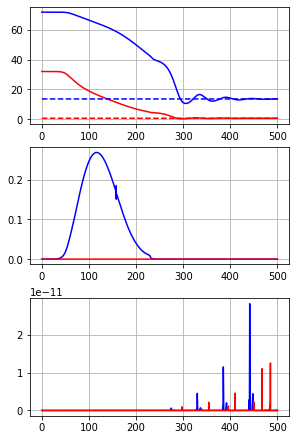

1
------------------------------ 2


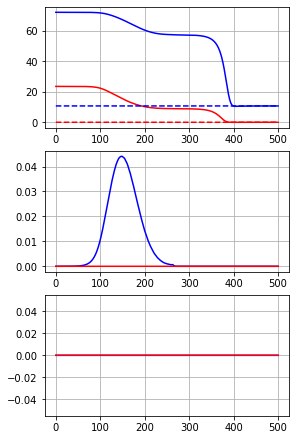

2
------------------------------ 3


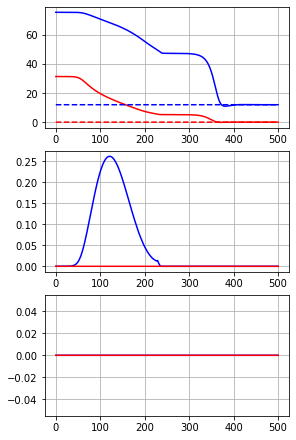

3
------------------------------ 5


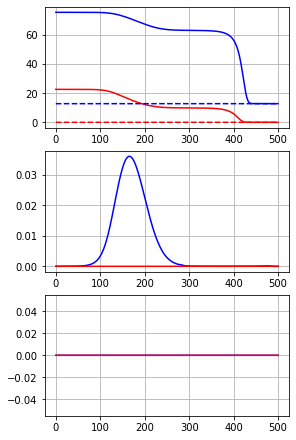

5
------------------------------ 9


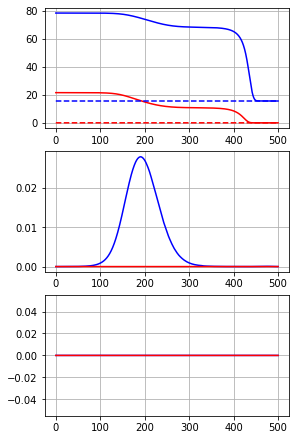

9
------------------------------ 10


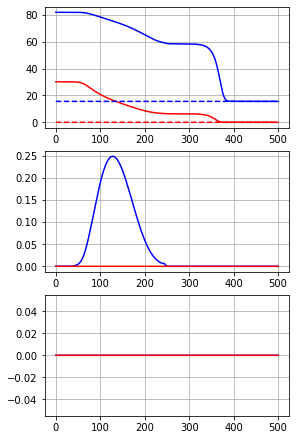

10
------------------------------ 13


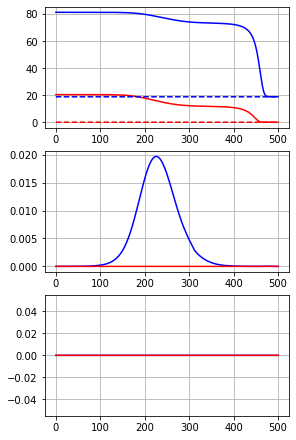

13
------------------------------ 14


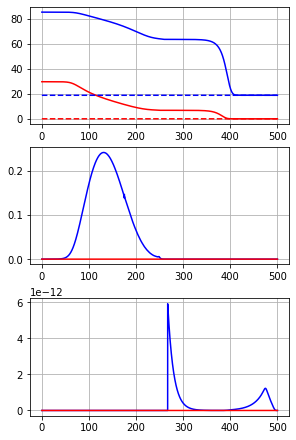

14
------------------------------ 19


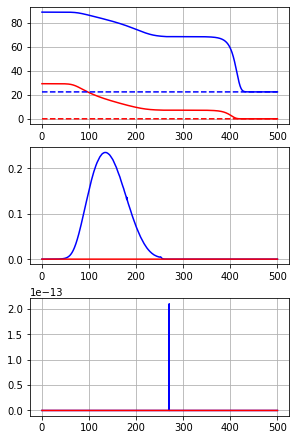

19
------------------------------ 25


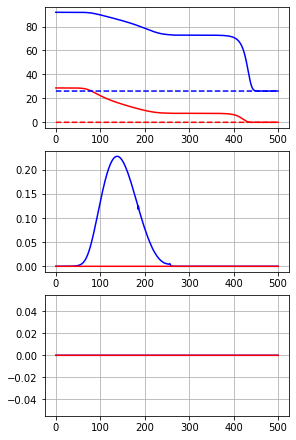

25
------------------------------ 55


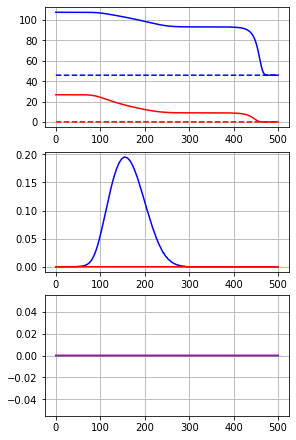

55
------------------------------ 62


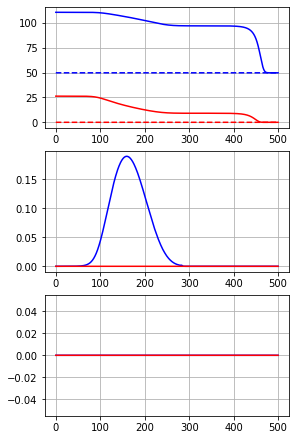

62
------------------------------ 69


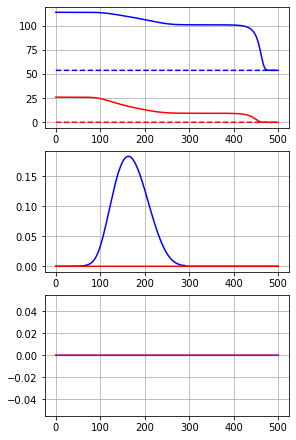

69
------------------------------ 76


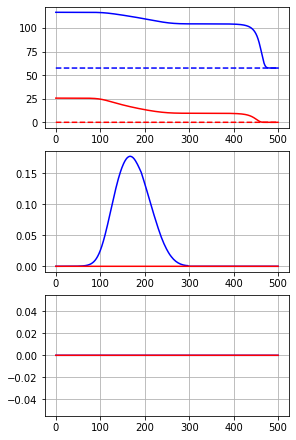

76


In [12]:
for i in i_range:
        
    print('------------------------------', i)
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]
        
    aln.run(control=control0)
    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,6) )

    ax[0].plot(aln.t, aln.rates_exc[0,:], color= 'red')
    ax[0].plot(aln.t, aln.rates_inh[0,:], color= 'blue')
    ax[0].plot(aln.t, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(aln.t, target_[0,1,:], linestyle = '--', color='blue')
    
    ax[1].plot(aln.t, control0[0,3,:], color = 'blue')
    ax[1].plot(aln.t, control0[0,2,:], color = 'red')
    
    ax[2].plot(aln.t, control0[0,4,:], color = 'blue')
    ax[2].plot(aln.t, control0[0,5,:], color = 'red')
    
    """
    z1ee = aln.rates_exc[0,:] * 1e-3 * aln.params.cee * aln.params.Ke * aln.params.tau_se / abs(aln.params.Jee_max)
    z1ee_mult = z1ee * (1. - aln.state['seem'][0,:])
    
    #ax[2].plot(aln.t, z1ee, color='orange')
    ax[2].plot(aln.t, z1ee_mult, color='red')
    #ax[2].plot(aln.t, - aln.state['seem'][0,:], color='purple')
    ax[3].plot(aln.t, z1ee_mult - aln.state['seem'][0,:], color='green')
    
    for k in range(4):
        ax[k].set_xlim(99.,150.)
    """
    
    plt.show()
    

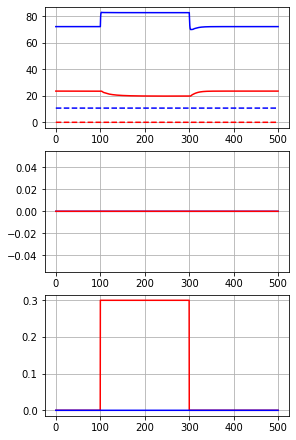

In [13]:
i_ = []

for i in [2]:
        
    #print('------------------------------', i)
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    control0[0,4,1000:3000] = 0.3
        
    aln.run(control=control0)
    
    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,6) )

    ax[0].plot(aln.t, aln.rates_exc[0,:], color= 'red')
    ax[0].plot(aln.t, aln.rates_inh[0,:], color= 'blue')
    ax[0].plot(aln.t, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(aln.t, target_[0,1,:], linestyle = '--', color='blue')
    
    ax[1].plot(aln.t, control0[0,3,:], color = 'blue')
    ax[1].plot(aln.t, control0[0,2,:], color = 'red')
    
    ax[2].plot(aln.t, control0[0,4,:], color = 'red')
    ax[2].plot(aln.t, control0[0,5,:], color = 'blue')